In [213]:
from helpers import NormalizedEnv
from helpers import RandomAgent

import gym as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
import random
random.seed(10)

from copy import deepcopy
from tqdm import tqdm
import importlib
# import warnings
# warnings.simplefilter("ignore")



#### 3 Heuristic policy
Define a simple heuristic policy to (attempt to) stabilize the pendulum. 
By comparing the heuristic policy with a random policy, verify that it leads to an increase in average reward.

In [214]:
# creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
# wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)
# create random agent
Random_Agent = RandomAgent(pendulum)

In [215]:
def run_episode(agent = Random_Agent):
  """Execute one episode of an agent in the pendulum environment"""
  current_state = pendulum.reset()[0] # returns the initial state
  max_it = False
  i = 0
  total_reward = 0
  while not max_it:
    # The instructions state that trunc becomes True once max_it has been surpassed
    # The source code however outputs a False statically, hence this break section of code
    if i >= 200:
      max_it = True
      break
    action = agent.compute_action(state = current_state)
    transformed_action = pendulum.action(action) # maps an action to [-1, 1] interval
    next_state, reward, term, trunc, info = pendulum.step(transformed_action) 

    current_state = next_state
    total_reward += reward
    i += 1
  return total_reward

In [216]:
# execute 10 episodes with random agent to get an average cumulative reward
reward_vector_random_agent = []
for j in range(10):
  total_reward = run_episode()
  reward_vector_random_agent.append(total_reward)
  
print("The average cumulative reward obtained with random agent:", np.mean(reward_vector_random_agent))

The average cumulative reward obtained with random agent: -1304.736843550231


In [217]:
class HeuristicPendulumAgent:
  """Heuristic policy for the pendulum"""
  def __init__(self, env, fixed_torque = 1):
    self.state_size = env.observation_space.shape[0]
    self.action_size = env.action_space.shape[0]
    self.fixed_torque = fixed_torque

  def compute_action(self, state):
    """Computes an action which indicates the torque to apply to the pendulum’s joint"""
    x, y, theta = state # x, y position and angular velocity
    if torch.is_tensor(state):
      action = np.zeros(len(x))
      for i in range(len(x)):
        if x[i] < 0:
          # the pendulum is in the lower half of the domain, 
          # applies a fixed torque in the same direction as the pendulum’s angular velocity
          action[i] = np.sign(theta[i])*self.fixed_torque
        else:
          # the pendulum is in the upper half of the domain,
          # applies a fixed torque in the opposite direction as the pendulum’s angular velocity
          action[i] = -np.sign(theta[i])*self.fixed_torque
    else:
      if x < 0:
        action = np.sign(theta)*self.fixed_torque
      else:
        action = -np.sign(theta)*self.fixed_torque

    return action

In [218]:
# execute 10 episodes with heuristic policy to get an average cumulative reward
heuristic_agent = HeuristicPendulumAgent(pendulum)
reward_vector_heuristic_agent = []

for j in range(10):
  total_reward = run_episode(agent = heuristic_agent)
  reward_vector_heuristic_agent.append(total_reward)
  
print("The average cumulative reward obtained with heuristic policy:",np.mean(reward_vector_heuristic_agent))

The average cumulative reward obtained with heuristic policy: -443.5172562588803


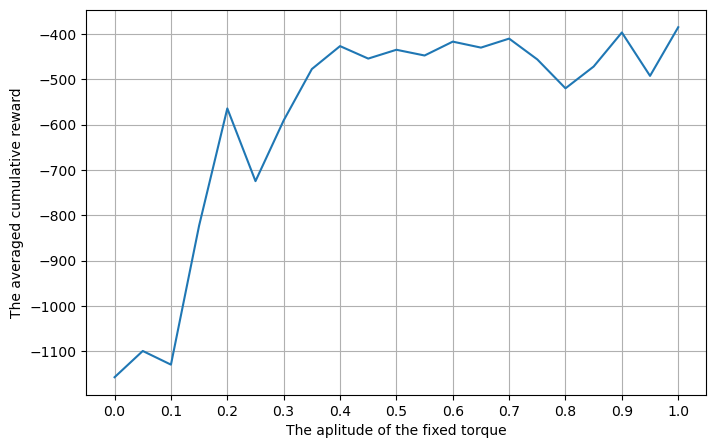

In [219]:
# effect of fixed torque amplitude on mean reward of 10 episodes (ten or one??)
reward_vector_heuristic_agent_varying_torque = []
torque = np.arange(0,1.05,0.05)
for t in torque:
  heuristic_agent = HeuristicPendulumAgent(pendulum, fixed_torque = t)
  reward_vector_heuristic_agent = []
  for j in range(10):
    total_reward = run_episode(agent = heuristic_agent)
    reward_vector_heuristic_agent.append(total_reward)
  reward_vector_heuristic_agent_varying_torque.append(np.mean(reward_vector_heuristic_agent))

plt.figure(figsize=(8,5))
plt.plot(torque, reward_vector_heuristic_agent_varying_torque)
plt.grid()

plt.xticks(np.arange(0,1.1,0.1))
plt.xlabel("The amplitude of the fixed torque")
plt.ylabel("The averaged cumulative reward")
plt.show()

#### 4 Q function of the heuristic policy
Implementation of the training procedure for the _critic_ – the Q network

In [220]:
class ReplayBuffer:
  
  def __init__(self, max_size = 200):
      """
          Create a a replay buffer which stores a sequence of transitions. 
          A transition is a tuple: (state, action, reward, next state, trunc).
          Is used to compute the 1-step TD-learning update rule.
          Variable trunc is a boolean that assumes a positive value after max steps (max_it).

          Parameters
          ----------
          max_size: int
              Max number of transitions to store in the buffer. When the buffer
              overflows the old memories are dropped.
          """
      self.num_exp=0
      self.buffer = []
      self.max_size = max_size # buffer size: how many transitions it can store at most

  def count(self):
      return self.num_exp
  
  def add_transition(self, state, action, reward, next_state, trunc):
      """Adds a new transition in the buffer."""
      transition = (state, action, reward, next_state, trunc)
      if self.num_exp < self.max_size:
          self.buffer.append(transition)
          self.num_exp +=1
      else:
          self.buffer.pop(0)
          self.buffer.append(transition)          

  def sample_transition(self, batch_size):
      """Samples a batch of experiences."""
      size = 0
      if self.num_exp < batch_size:
          size = self.num_exp
      else:
          size = batch_size
      
      batch_transitions=random.sample(self.buffer, size)
      state_batch, action_batch, reward_batch, next_state_batch, trunc = map(np.stack, zip(*batch_transitions))
      
      return state_batch, action_batch, reward_batch, next_state_batch, trunc

In [221]:
class QNetwork(nn.Module):
  # implementation of a fully-connected network with two layers
  def __init__(self):
    super().__init__()
    self.Lin1 = nn.Linear(4,32)
    self.Relu1 = nn.ReLU()
    self.Lin2 = nn.Linear(32,32)
    self.Relu2 = nn.ReLU()
    self.Lin3 = nn.Linear(32,1) # output a scalar value (the expected cumulative reward)

  def forward(self,x):
    x = self.Lin1(x)
    x = self.Relu1(x)
    x = self.Lin2(x)
    x = self.Relu2(x)
    x = self.Lin3(x)
    return x

Code to create critic network heatmaps

In [222]:
def Multiple_HeatMap(Neural_Network, Action = 0, Velocity = 0):
    
    nr_of_states = 500
    fig = plt.figure(figsize=(15,5))
    vmin = 0
    vmax = 0
    for i in np.arange(len(Action)):
        ########
        action = np.zeros((nr_of_states,1)) + Action[i]
        velocity = np.zeros((nr_of_states,1)) + Velocity[i]
        q_value = []
        theta = np.reshape(np.linspace(0,2*np.pi,nr_of_states),(nr_of_states,1))
        x = np.cos(theta)
        y = np.sin(theta)

        state = np.concatenate((x,y,velocity,action),1)

        with torch.no_grad():
            state = torch.tensor(state, dtype = torch.float32)
            new_q_value = Neural_Network(state)
            

        rad = np.linspace(0, 1, nr_of_states)
        azm = np.linspace(0, 2 * np.pi, nr_of_states)
        r, th = np.meshgrid(rad, azm)

        z = np.repeat(new_q_value, [nr_of_states], axis=1)
        #######3

        cmap = mpl.cm.plasma

        ax = plt.subplot(1, len(Action), i+1, projection = 'polar')
        ax.set_theta_offset(np.pi/2)
        ax.set_theta_direction(-1)
        ax.set_yticklabels([])
        ax.set_title("Velocity = {}, Action = {}".format(Velocity[i], Action[i]))
        ax.pcolormesh(th, r, z, cmap=cmap)
        ax.plot(th, r, color='k', ls='none') 
        ax.grid()
        vmin = min(vmin, torch.min(z))
        vmax = max(vmax, torch.max(z))


    fig.suptitle("q value as a function of the pendulum angle", x = 0.5, y = 0.85)


    cax = plt.axes([0.95, 0.25, 0.05, 0.55])
    norm = mpl.colors.Normalize(vmin=-1300, vmax=0)

    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = cax) 
    cbar.set_label('q value')
    plt.show()

def Single_HeatMap(Neural_Network, Action = 0, Velocity = 0):

    nr_of_states = 500

    action = np.zeros((nr_of_states,1)) + Action
    velocity = np.zeros((nr_of_states,1)) + Velocity
    q_value = []
    theta = np.reshape(np.linspace(0,2*np.pi,nr_of_states),(nr_of_states,1))
    x = np.cos(theta)
    y = np.sin(theta)

    state = np.concatenate((x,y,velocity,action),1)

    with torch.no_grad():
        state = torch.tensor(state, dtype = torch.float32)
        new_q_value = Neural_Network(state)
        

    rad = np.linspace(0, 1, nr_of_states)
    azm = np.linspace(0, 2 * np.pi, nr_of_states)
    r, th = np.meshgrid(rad, azm)

    z = np.repeat(new_q_value, [nr_of_states], axis=1)


    cmap = mpl.cm.plasma
    norm = mpl.colors.Normalize(vmin=-1300, vmax=0)

    fig = plt.figure()

    ax = plt.subplot(projection='polar')
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.pcolormesh(th, r, z, cmap=cmap)
    ax.plot(th, r, color='k', ls='none') 
    ax.grid()
    ax.set_yticklabels([])
    cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    plt.title("q value as a function of the pendulum angle with velocity = {} and action = {}".format(Velocity, Action), x = -3, y = 1.05)

    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax = cax) 
    cbar.set_label('q value')
    plt.show()
    

In [223]:
device   = torch.device("cpu")
torch.manual_seed(-1)

MAX_IT = 200
BUFFER_SIZE = 1e4

BATCH_SIZE = 128
LEARNING_RATE = 1e-4
NUM_EPISODES = 1000
GAMMA = 0.99
MSE = nn.MSELoss()

In [224]:
heuristic_agent = HeuristicPendulumAgent(pendulum)
critic  = QNetwork().to(device) # critic
memory = ReplayBuffer(max_size=BUFFER_SIZE)
q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)

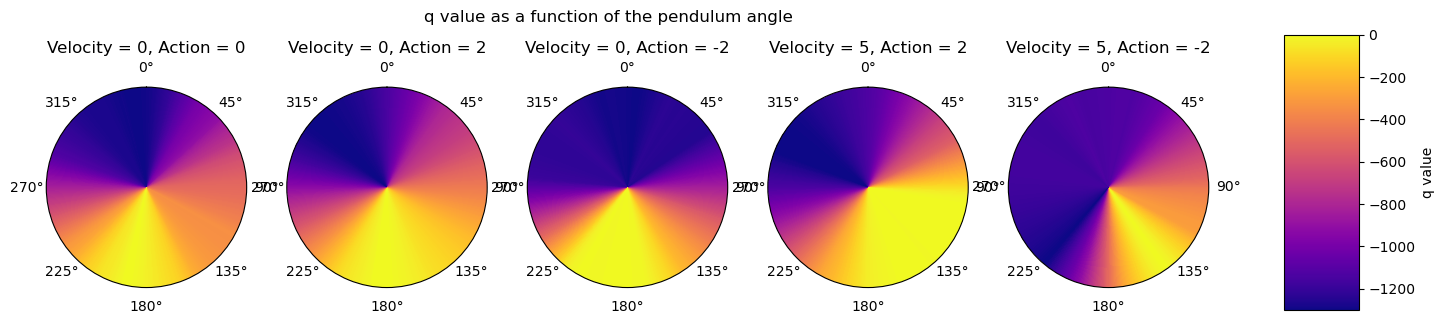

In [225]:
Velocity = [0,0,0,5,5]
Action = [0,2,-2,2,-2]

Multiple_HeatMap(critic, Action, Velocity)

In [226]:
def onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, agent, gamma, critic, iter):
    """1-step TD-learning rule"""                                 
    with torch.no_grad():
        action_next_state = agent.compute_action(state = next_state_batch.T)
        network_input_next_state = torch.cat((next_state_batch, torch.Tensor([action_next_state]).T), 1)
        q_next = critic(network_input_next_state) # should not be differentiated 

    if iter == MAX_IT:
        q_next = 0
    target_state = reward_batch + gamma * q_next # the last update in each episode should use q = 0 
    
    network_input_state = torch.cat((state_batch, action_batch),1)
    q = critic(network_input_state)

    q_optimizer.zero_grad()
    q_loss = MSE(target_state, q)
    q_loss.backward()
    q_optimizer.step()

    return q_loss

In [227]:
plot_reward = []
plot_policy = []
q_loss_plot = []

average_reward = 0
global_step = 0
nr_of_samples = 128

In [228]:
for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        action = heuristic_agent.compute_action(state = current_state)
        transformed_action = pendulum.action(action)
        next_state, reward, term, trunc, info = pendulum.step(transformed_action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # converting to tensors
            state_batch = torch.FloatTensor(state_batch).to(device)
            action_batch = torch.FloatTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device) #.unsqueeze(1)
            trunc_batch = torch.Tensor(np.float32(trunc_batch)).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(next_state_batch).to(device)

            # 1-step TD-learning rule
            q_loss = onestepTD(state_batch, action_batch, reward_batch, next_state_batch, trunc_batch, heuristic_agent, GAMMA, critic, i)
                       
        
        current_state = deepcopy(next_state)
        ep_reward += reward
    try:
        #plot_reward.append([ep_reward, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        q_loss_plot.append(q_loss.data)

        if (episode % 100 == 0):
            print(q_loss.item())
    except:
        continue


  0%|          | 1/1000 [00:01<22:14,  1.34s/it]

28.763565063476562


 10%|█         | 101/1000 [07:03<1:03:03,  4.21s/it]

29.16640281677246


 20%|██        | 201/1000 [14:37<1:03:19,  4.76s/it]

19.814815521240234


 30%|███       | 301/1000 [22:01<53:21,  4.58s/it]  

17.537355422973633


 40%|████      | 401/1000 [29:41<45:33,  4.56s/it]  

18.012083053588867


 50%|█████     | 501/1000 [37:25<37:33,  4.52s/it]

12.266275405883789


 60%|██████    | 601/1000 [44:58<30:52,  4.64s/it]

15.193023681640625


 70%|███████   | 701/1000 [52:30<22:16,  4.47s/it]

20.909530639648438


 80%|████████  | 801/1000 [1:00:06<15:10,  4.58s/it]

13.319964408874512


 90%|█████████ | 901/1000 [1:07:52<08:36,  5.22s/it]

12.869600296020508


100%|██████████| 1000/1000 [1:14:46<00:00,  4.49s/it]


Text(0, 0.5, 'MSE')

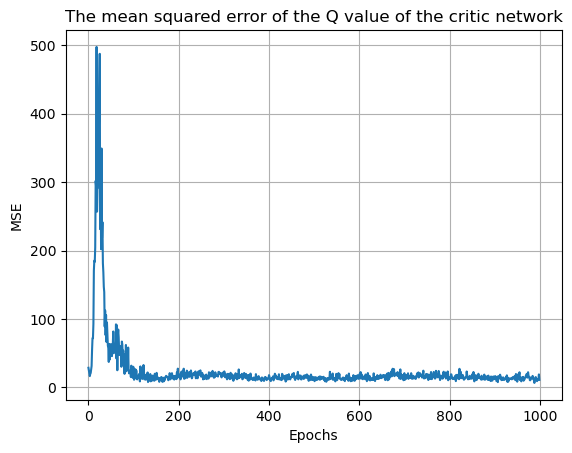

In [229]:
plt.plot(q_loss_plot)
plt.grid()
plt.title('The mean squared error of the Q value of the critic network')
plt.xlabel('Epochs')
plt.ylabel('MSE')

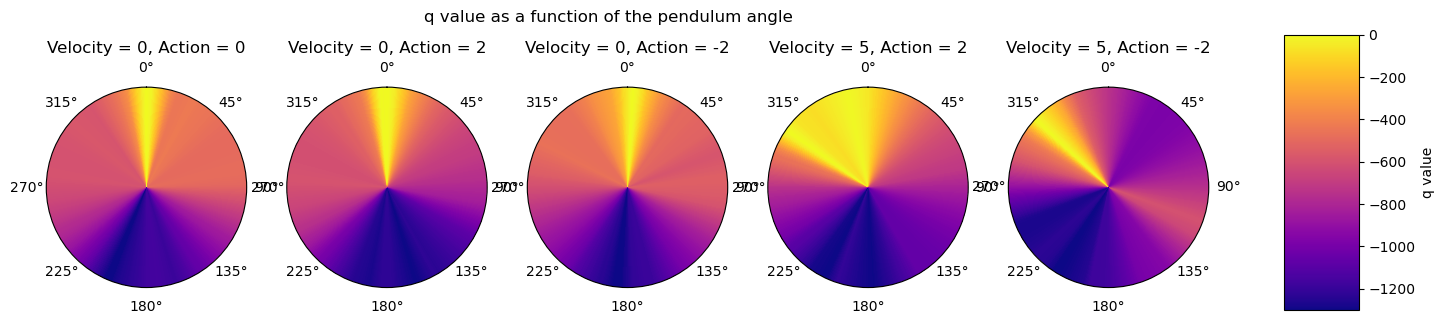

In [230]:
# a polar heatmap for different values of the pendulum’s velocity and torque (action)

Velocity = [0,0,0,5,5]
Action = [0,2,-2,2,-2]

# each angle corresponds to the angular position of the pendulum
# the color corresponds to the magnitude of the q function

# TODO: two polar heatmap plots for each velocity and action pair, 
# one before and one after training the HeuristicPendulumAgent ??
Multiple_HeatMap(critic, Action, Velocity)

#### 5 Minimal implementation of DDPG
Implementation of the first version of the DDPG algorithm: the actor network, the critic network, the action noise and the learning rule.

In [231]:
class PolicyNetwork(nn.Module):
  # actor
  def __init__(self): 
    super().__init__()
    self.Lin1 = nn.Linear(3,32)
    self.Relu1 = nn.ReLU()
    self.Lin2 = nn.Linear(32,32)
    self.Relu2 = nn.ReLU()
    self.Lin3 = nn.Linear(32,1) # output a scalar value (the expected cumulative reward)
    self.Tanh = nn.Tanh()

  def forward(self,x):
    x = self.Lin1(x)
    x = self.Relu1(x)
    x = self.Lin2(x)
    x = self.Relu2(x)
    x = self.Lin3(x)
    x = self.Tanh(x)
    return x

In [232]:
class GaussianActionNoise():
    def __init__(self, std_deviation=1):
        self.std_deviation = std_deviation

    def get_noisy_action(self, action):
        """Adds noise to an input action, by summing it with a value sampled 
        from a Gaussian of a given standard deviation (std_deviation)"""
        
        noise = random.gauss(0, self.std_deviation)
        noisy_action = action + noise
        noisy_action = np.clip(noisy_action, -1., 1.)

        return noisy_action

In [233]:
class DDPGAgent:
    def __init__(self, policy_network, noisy_action):
        self.policy_network = policy_network
        self.noisy_action = noisy_action

    def compute_action(self, state, device, deterministic=True):
        """Processes an input state with the policy network and returns an action. 
        The parameter "deterministic" regulates whether to add random noise to the action or not"""
        
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.policy_network(state)

        if not deterministic:
            out = action.detach().cpu().numpy()[0]
            out = self.noisy_action.get_noisy_action(out)
        else:
            out = action[0]

        return out

    def update_target_params(self, network, target_network, Tau):
        for p_target, p in zip(target_network.parameters(), network.parameters()):
            p_target.data = Tau*p.data + (1-Tau)*p_target.data



In [234]:
NOISE_STD = 0.3

noise = GaussianActionNoise(NOISE_STD)

critic  = QNetwork().to(device) # critic
actor = PolicyNetwork().to(device) # policy_network

memory = ReplayBuffer(max_size=BUFFER_SIZE)
ddpg_agent = DDPGAgent(actor, noise)

q_optimizer  = optim.Adam(critic.parameters(),  lr=LEARNING_RATE)
policy_optimizer  = optim.Adam(actor.parameters(),  lr=LEARNING_RATE)

In [235]:
def learning_policy(state_batch, policy_optimizer, actor, critic):
    """The learning rule for the policy network"""

    policy_optimizer.zero_grad()
    # does not use the ”on-trajectory” actions, 
    # which were computed by a previous version of the policy network, 
    # but computes them with the current actor (DDPG is an off-policy algorithm)
    policy_input_state = torch.cat((state_batch, actor(state_batch)), 1)
    policy_loss = -critic(policy_input_state)
    policy_loss = policy_loss.mean()
    policy_loss.backward()
    policy_optimizer.step()
    
    return policy_loss

In [236]:
reward_plot = []
policy_loss_plot = []
q_loss_plot = []

average_reward = 0
global_step = 0
nr_of_samples = 128

PRINT_EVERY = 10

for episode in tqdm(range(NUM_EPISODES)):
    current_state = deepcopy(pendulum.reset()[0])

    ep_reward = 0.
    ep_q_value = 0.
    step = 0

    # collect experience
    for i in range(MAX_IT):
        action = ddpg_agent.compute_action(state = current_state, device=device, deterministic=False)
        action = action[0]

        next_state, reward, term, trunc, info = pendulum.step(action)

        memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

        if memory.count() > nr_of_samples:
            # sample a batch of transitions from the replay buffer
            state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

            # converting to tensors
            state_batch = torch.FloatTensor(state_batch).to(device)
            action_batch = torch.FloatTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device)
            trunc_batch = torch.Tensor(np.float32(trunc_batch)).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(next_state_batch).to(device)

            # 1-step TD-learning rule                                 
            with torch.no_grad():
                action_next_state = ddpg_agent.compute_action(state = next_state_batch, device=device)
                network_input_next_state = torch.cat((next_state_batch, torch.Tensor(action_next_state)),1)
                q_next = critic(network_input_next_state) # should not be differentiated 

            if iter == MAX_IT:
                q_next = 0
            target_state = reward_batch + GAMMA * q_next # the last update in each episode should use q = 0 
            
            network_input_state = torch.cat((state_batch, action_batch),1)
            q = critic(network_input_state)
    
            q_optimizer.zero_grad()
            q_loss = MSE(target_state, q)
            q_loss.backward()
            q_optimizer.step()

            policy_loss = learning_policy(state_batch, policy_optimizer, actor, critic)
            
        current_state = deepcopy(next_state)
        ep_reward += reward
    try:
        reward_plot.append(ep_reward)
        q_loss_plot.append(q_loss.data)
        policy_loss_plot.append(policy_loss.data)
        # plot_reward.append([ep_reward, episode+1])
        # plot_policy.append([policy_loss.data, episode+1])
        # plot_q.append([q_loss.data, episode+1])
        # plot_steps.append([step+1, episode+1])

    except:
        continue
    average_reward += ep_reward

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        print("Policy loss: ", policy_loss.data)
        print("Q loss: ", q_loss.data)
        print("Episode reward: ", ep_reward)
        #subplot(plot_reward, plot_policy, plot_q)


  1%|          | 10/1000 [00:18<29:50,  1.81s/it]

Policy loss:  tensor(30.3015)
Q loss:  tensor(66.9097)
Episode reward:  -1710.4303333652533


  2%|▏         | 20/1000 [00:40<42:18,  2.59s/it]

Policy loss:  tensor(179.9599)
Q loss:  tensor(165.0558)
Episode reward:  -1454.5292582476754


  3%|▎         | 30/1000 [01:04<37:25,  2.31s/it]

Policy loss:  tensor(412.6253)
Q loss:  tensor(575.0208)
Episode reward:  -1401.018423268548


  4%|▍         | 40/1000 [01:50<44:10,  2.76s/it]  

Policy loss:  tensor(435.8434)
Q loss:  tensor(404.0859)
Episode reward:  -1130.905939608888


  5%|▌         | 50/1000 [02:17<50:04,  3.16s/it]

Policy loss:  tensor(454.8158)
Q loss:  tensor(747.2658)
Episode reward:  -1370.1754481948394


  6%|▌         | 60/1000 [02:44<39:28,  2.52s/it]

Policy loss:  tensor(476.0061)
Q loss:  tensor(616.2386)
Episode reward:  -1544.8589938394605


  7%|▋         | 70/1000 [03:10<41:30,  2.68s/it]

Policy loss:  tensor(437.9640)
Q loss:  tensor(348.5946)
Episode reward:  -1179.5768160890066


  8%|▊         | 80/1000 [03:37<43:05,  2.81s/it]

Policy loss:  tensor(428.7846)
Q loss:  tensor(86.2700)
Episode reward:  -927.0573766185726


  9%|▉         | 90/1000 [03:57<28:21,  1.87s/it]

Policy loss:  tensor(507.0284)
Q loss:  tensor(55.9449)
Episode reward:  -1188.4351286522524


 10%|█         | 100/1000 [04:19<40:17,  2.69s/it]

Policy loss:  tensor(582.7598)
Q loss:  tensor(26.7327)
Episode reward:  -1126.6138877379487


 11%|█         | 110/1000 [04:39<32:15,  2.18s/it]

Policy loss:  tensor(575.6063)
Q loss:  tensor(23.0745)
Episode reward:  -923.1746517025481


 12%|█▏        | 120/1000 [05:05<41:16,  2.81s/it]

Policy loss:  tensor(487.3888)
Q loss:  tensor(30.8262)
Episode reward:  -658.03139462108


 13%|█▎        | 130/1000 [05:30<30:41,  2.12s/it]

Policy loss:  tensor(392.1846)
Q loss:  tensor(42.4554)
Episode reward:  -789.8296498437875


 14%|█▍        | 140/1000 [05:50<29:02,  2.03s/it]

Policy loss:  tensor(310.4722)
Q loss:  tensor(55.1605)
Episode reward:  -610.7730440173239


 15%|█▌        | 150/1000 [06:19<43:35,  3.08s/it]

Policy loss:  tensor(260.4061)
Q loss:  tensor(24.6712)
Episode reward:  -254.85835103670362


 16%|█▌        | 160/1000 [06:42<31:38,  2.26s/it]

Policy loss:  tensor(212.8273)
Q loss:  tensor(41.1606)
Episode reward:  -1636.1154798885868


 17%|█▋        | 170/1000 [07:04<31:03,  2.24s/it]

Policy loss:  tensor(242.5496)
Q loss:  tensor(58.9530)
Episode reward:  -1027.3400721091189


 18%|█▊        | 180/1000 [07:28<34:13,  2.50s/it]

Policy loss:  tensor(290.9215)
Q loss:  tensor(62.3536)
Episode reward:  -167.5427736742967


 19%|█▉        | 190/1000 [07:51<29:42,  2.20s/it]

Policy loss:  tensor(291.1224)
Q loss:  tensor(58.1070)
Episode reward:  -256.29525091015796


 20%|██        | 200/1000 [08:11<25:29,  1.91s/it]

Policy loss:  tensor(276.3454)
Q loss:  tensor(43.3745)
Episode reward:  -138.54063917799223


 21%|██        | 210/1000 [08:30<24:24,  1.85s/it]

Policy loss:  tensor(207.9120)
Q loss:  tensor(35.6621)
Episode reward:  -132.80435977730394


 22%|██▏       | 220/1000 [08:49<25:30,  1.96s/it]

Policy loss:  tensor(146.0704)
Q loss:  tensor(53.1715)
Episode reward:  -1582.1278262735418


 23%|██▎       | 230/1000 [09:09<24:33,  1.91s/it]

Policy loss:  tensor(182.8670)
Q loss:  tensor(73.8976)
Episode reward:  -528.3914055435047


 24%|██▍       | 240/1000 [09:28<23:31,  1.86s/it]

Policy loss:  tensor(174.3084)
Q loss:  tensor(64.9127)
Episode reward:  -388.56530026019186


 25%|██▌       | 250/1000 [09:47<23:07,  1.85s/it]

Policy loss:  tensor(130.2581)
Q loss:  tensor(48.1920)
Episode reward:  -393.5785677878968


 26%|██▌       | 260/1000 [10:16<30:43,  2.49s/it]

Policy loss:  tensor(89.6766)
Q loss:  tensor(44.5108)
Episode reward:  -261.05906786454756


 27%|██▋       | 270/1000 [10:43<38:26,  3.16s/it]

Policy loss:  tensor(54.8842)
Q loss:  tensor(23.6466)
Episode reward:  -890.5698042417598


 28%|██▊       | 280/1000 [11:06<25:32,  2.13s/it]

Policy loss:  tensor(16.6094)
Q loss:  tensor(24.7620)
Episode reward:  -498.2836154201264


 29%|██▉       | 290/1000 [11:34<34:44,  2.94s/it]

Policy loss:  tensor(28.9389)
Q loss:  tensor(30.8979)
Episode reward:  -266.9030594035299


 30%|███       | 300/1000 [11:59<26:47,  2.30s/it]

Policy loss:  tensor(41.9099)
Q loss:  tensor(60.6760)
Episode reward:  -261.1126602873979


 31%|███       | 310/1000 [12:20<25:00,  2.17s/it]

Policy loss:  tensor(26.9708)
Q loss:  tensor(40.8285)
Episode reward:  -132.35274078067638


 32%|███▏      | 320/1000 [12:42<25:51,  2.28s/it]

Policy loss:  tensor(-41.4307)
Q loss:  tensor(15.8121)
Episode reward:  -248.03428178274712


 33%|███▎      | 330/1000 [13:04<22:38,  2.03s/it]

Policy loss:  tensor(-26.6288)
Q loss:  tensor(18.6794)
Episode reward:  -253.03189148389927


 34%|███▍      | 340/1000 [13:32<33:30,  3.05s/it]

Policy loss:  tensor(-61.8270)
Q loss:  tensor(9.3678)
Episode reward:  -466.80752337480317


 35%|███▌      | 350/1000 [14:02<30:50,  2.85s/it]

Policy loss:  tensor(-55.8432)
Q loss:  tensor(27.5226)
Episode reward:  -235.1867316620341


 36%|███▌      | 360/1000 [14:38<37:34,  3.52s/it]

Policy loss:  tensor(-79.2062)
Q loss:  tensor(6.6073)
Episode reward:  -4.536988378389041


 37%|███▋      | 370/1000 [15:02<28:45,  2.74s/it]

Policy loss:  tensor(-48.4012)
Q loss:  tensor(12.3161)
Episode reward:  -345.11411393736216


 38%|███▊      | 380/1000 [15:26<23:43,  2.30s/it]

Policy loss:  tensor(-60.0428)
Q loss:  tensor(7.1260)
Episode reward:  -614.3921081156831


 39%|███▉      | 390/1000 [16:02<28:14,  2.78s/it]

Policy loss:  tensor(-37.0501)
Q loss:  tensor(5.8949)
Episode reward:  -120.66069700262665


 40%|████      | 400/1000 [16:29<25:56,  2.59s/it]

Policy loss:  tensor(-38.6220)
Q loss:  tensor(9.8115)
Episode reward:  -246.4410416229503


 41%|████      | 410/1000 [16:59<29:20,  2.98s/it]

Policy loss:  tensor(-17.8370)
Q loss:  tensor(4.8982)
Episode reward:  -248.8307960220607


 42%|████▏     | 420/1000 [17:26<24:52,  2.57s/it]

Policy loss:  tensor(5.3898)
Q loss:  tensor(38.2926)
Episode reward:  -372.10810702126287


 43%|████▎     | 430/1000 [17:52<24:23,  2.57s/it]

Policy loss:  tensor(-6.0128)
Q loss:  tensor(7.6999)
Episode reward:  -1.971548339775343


 44%|████▍     | 440/1000 [18:17<23:45,  2.55s/it]

Policy loss:  tensor(1.3047)
Q loss:  tensor(14.1239)
Episode reward:  -360.99073738074793


 45%|████▌     | 450/1000 [18:43<23:13,  2.53s/it]

Policy loss:  tensor(4.6790)
Q loss:  tensor(3.4393)
Episode reward:  -261.6579153238948


 46%|████▌     | 460/1000 [19:09<23:13,  2.58s/it]

Policy loss:  tensor(20.7694)
Q loss:  tensor(7.5307)
Episode reward:  -1.6101751638380777


 47%|████▋     | 470/1000 [19:35<22:36,  2.56s/it]

Policy loss:  tensor(-23.5778)
Q loss:  tensor(3.7788)
Episode reward:  -258.61593290560006


 48%|████▊     | 480/1000 [20:01<22:19,  2.58s/it]

Policy loss:  tensor(-23.4573)
Q loss:  tensor(12.1507)
Episode reward:  -388.6090602593701


 49%|████▉     | 490/1000 [20:28<23:59,  2.82s/it]

Policy loss:  tensor(-34.8517)
Q loss:  tensor(7.7727)
Episode reward:  -367.1013708726762


 50%|█████     | 500/1000 [20:55<21:40,  2.60s/it]

Policy loss:  tensor(-44.6902)
Q loss:  tensor(17.9622)
Episode reward:  -387.8199849484942


 51%|█████     | 510/1000 [21:21<21:01,  2.58s/it]

Policy loss:  tensor(-15.4196)
Q loss:  tensor(6.3560)
Episode reward:  -139.96022103972578


 52%|█████▏    | 520/1000 [21:47<21:13,  2.65s/it]

Policy loss:  tensor(-46.8559)
Q loss:  tensor(11.6697)
Episode reward:  -127.39281711881658


 53%|█████▎    | 530/1000 [22:13<20:27,  2.61s/it]

Policy loss:  tensor(-2.9426)
Q loss:  tensor(14.0040)
Episode reward:  -931.6163239683358


 54%|█████▍    | 540/1000 [22:39<19:40,  2.57s/it]

Policy loss:  tensor(-18.2113)
Q loss:  tensor(4.9962)
Episode reward:  -254.74111489269328


 55%|█████▌    | 550/1000 [23:05<19:07,  2.55s/it]

Policy loss:  tensor(4.9840)
Q loss:  tensor(16.4387)
Episode reward:  -1242.0360678896623


 56%|█████▌    | 560/1000 [23:31<18:50,  2.57s/it]

Policy loss:  tensor(-3.0603)
Q loss:  tensor(29.0568)
Episode reward:  -610.5318062373706


 57%|█████▋    | 570/1000 [23:57<18:18,  2.55s/it]

Policy loss:  tensor(-5.1846)
Q loss:  tensor(67.5753)
Episode reward:  -231.07312821737125


 58%|█████▊    | 580/1000 [24:22<17:53,  2.56s/it]

Policy loss:  tensor(-60.1860)
Q loss:  tensor(47.5139)
Episode reward:  -120.48928910870988


 59%|█████▉    | 590/1000 [24:48<17:33,  2.57s/it]

Policy loss:  tensor(-97.3500)
Q loss:  tensor(21.3188)
Episode reward:  -126.54254044360974


 60%|██████    | 600/1000 [25:14<17:46,  2.67s/it]

Policy loss:  tensor(-123.7757)
Q loss:  tensor(22.8082)
Episode reward:  -126.74061246415155


 61%|██████    | 610/1000 [25:42<18:32,  2.85s/it]

Policy loss:  tensor(-127.5482)
Q loss:  tensor(17.5840)
Episode reward:  -123.96018529633889


 62%|██████▏   | 620/1000 [26:07<16:04,  2.54s/it]

Policy loss:  tensor(-89.6695)
Q loss:  tensor(9.8622)
Episode reward:  -124.03978243088517


 63%|██████▎   | 630/1000 [26:34<15:51,  2.57s/it]

Policy loss:  tensor(-34.6533)
Q loss:  tensor(8.4057)
Episode reward:  -240.2767736423211


 64%|██████▍   | 640/1000 [26:59<15:13,  2.54s/it]

Policy loss:  tensor(-59.8797)
Q loss:  tensor(9.1296)
Episode reward:  -252.92017320885597


 65%|██████▌   | 650/1000 [27:25<14:51,  2.55s/it]

Policy loss:  tensor(-33.2568)
Q loss:  tensor(10.3126)
Episode reward:  -244.39419802830074


 66%|██████▌   | 660/1000 [27:52<14:45,  2.61s/it]

Policy loss:  tensor(-20.6841)
Q loss:  tensor(6.7989)
Episode reward:  -237.23443703504296


 67%|██████▋   | 670/1000 [28:18<14:11,  2.58s/it]

Policy loss:  tensor(2.9604)
Q loss:  tensor(4.4765)
Episode reward:  -252.5145386347986


 68%|██████▊   | 680/1000 [28:44<13:50,  2.60s/it]

Policy loss:  tensor(1.3911)
Q loss:  tensor(3.2224)
Episode reward:  -4.772958826814903


 69%|██████▉   | 690/1000 [29:10<13:35,  2.63s/it]

Policy loss:  tensor(-1.0260)
Q loss:  tensor(1.4754)
Episode reward:  -129.3583445118415


 70%|███████   | 700/1000 [29:37<13:00,  2.60s/it]

Policy loss:  tensor(6.8179)
Q loss:  tensor(6.6091)
Episode reward:  -237.61244941834863


 71%|███████   | 710/1000 [30:03<12:19,  2.55s/it]

Policy loss:  tensor(0.6110)
Q loss:  tensor(14.7560)
Episode reward:  -128.88345250633387


 72%|███████▏  | 720/1000 [30:30<12:30,  2.68s/it]

Policy loss:  tensor(0.1739)
Q loss:  tensor(6.6342)
Episode reward:  -234.08542513342428


 73%|███████▎  | 730/1000 [30:57<11:50,  2.63s/it]

Policy loss:  tensor(8.0026)
Q loss:  tensor(5.8349)
Episode reward:  -232.8855848742386


 74%|███████▍  | 740/1000 [31:22<11:05,  2.56s/it]

Policy loss:  tensor(-197.8577)
Q loss:  tensor(17.2191)
Episode reward:  -371.7547401772072


 75%|███████▌  | 750/1000 [31:48<10:42,  2.57s/it]

Policy loss:  tensor(-82.8265)
Q loss:  tensor(20.6043)
Episode reward:  -391.18670493699733


 76%|███████▌  | 760/1000 [32:14<10:16,  2.57s/it]

Policy loss:  tensor(-58.3847)
Q loss:  tensor(16.4389)
Episode reward:  -316.92518626784357


 77%|███████▋  | 770/1000 [32:40<09:48,  2.56s/it]

Policy loss:  tensor(-30.2814)
Q loss:  tensor(21.7506)
Episode reward:  -1193.5173991556248


 78%|███████▊  | 780/1000 [33:06<09:23,  2.56s/it]

Policy loss:  tensor(-50.7914)
Q loss:  tensor(51.9561)
Episode reward:  -241.9663744077891


 79%|███████▉  | 790/1000 [33:32<09:06,  2.60s/it]

Policy loss:  tensor(-150.4037)
Q loss:  tensor(247.8513)
Episode reward:  -1189.790574262236


 80%|████████  | 800/1000 [33:58<08:43,  2.62s/it]

Policy loss:  tensor(-158.0548)
Q loss:  tensor(79.9981)
Episode reward:  -138.97961077484698


 81%|████████  | 810/1000 [34:25<08:27,  2.67s/it]

Policy loss:  tensor(-196.6042)
Q loss:  tensor(126.9783)
Episode reward:  -127.29234318119468


 82%|████████▏ | 820/1000 [34:51<07:42,  2.57s/it]

Policy loss:  tensor(-238.8613)
Q loss:  tensor(90.7603)
Episode reward:  -254.60919437623122


 83%|████████▎ | 830/1000 [35:18<07:21,  2.60s/it]

Policy loss:  tensor(-193.3118)
Q loss:  tensor(70.2635)
Episode reward:  -650.1064899535437


 84%|████████▍ | 840/1000 [35:44<07:08,  2.68s/it]

Policy loss:  tensor(-196.4108)
Q loss:  tensor(47.0346)
Episode reward:  -126.6485659409198


 85%|████████▌ | 850/1000 [36:11<06:29,  2.60s/it]

Policy loss:  tensor(-180.0384)
Q loss:  tensor(31.0137)
Episode reward:  -254.68870434265216


 86%|████████▌ | 860/1000 [36:36<05:59,  2.57s/it]

Policy loss:  tensor(-153.0571)
Q loss:  tensor(21.8604)
Episode reward:  -245.0006549845963


 87%|████████▋ | 870/1000 [37:02<05:35,  2.58s/it]

Policy loss:  tensor(-173.9474)
Q loss:  tensor(15.8290)
Episode reward:  -121.01421750289045


 88%|████████▊ | 880/1000 [37:28<05:09,  2.58s/it]

Policy loss:  tensor(-134.7825)
Q loss:  tensor(24.5323)
Episode reward:  -122.71192897417833


 89%|████████▉ | 890/1000 [37:54<04:40,  2.55s/it]

Policy loss:  tensor(-113.3915)
Q loss:  tensor(13.3648)
Episode reward:  -235.82295296876973


 90%|█████████ | 900/1000 [38:20<04:19,  2.59s/it]

Policy loss:  tensor(-92.2495)
Q loss:  tensor(13.0430)
Episode reward:  -358.93055225150545


 91%|█████████ | 910/1000 [38:46<03:51,  2.57s/it]

Policy loss:  tensor(-74.9924)
Q loss:  tensor(7.4356)
Episode reward:  -132.51483490134675


 92%|█████████▏| 920/1000 [39:13<03:26,  2.58s/it]

Policy loss:  tensor(-42.8927)
Q loss:  tensor(12.1223)
Episode reward:  -405.4252847010788


 93%|█████████▎| 930/1000 [39:38<02:52,  2.47s/it]

Policy loss:  tensor(-31.4170)
Q loss:  tensor(8.0117)
Episode reward:  -128.37129679249267


 94%|█████████▍| 940/1000 [40:04<02:35,  2.59s/it]

Policy loss:  tensor(-24.8114)
Q loss:  tensor(5.9773)
Episode reward:  -120.384087989711


 95%|█████████▌| 950/1000 [40:32<02:14,  2.69s/it]

Policy loss:  tensor(-26.4810)
Q loss:  tensor(3.3970)
Episode reward:  -1.5436475016059168


 96%|█████████▌| 960/1000 [40:57<01:42,  2.57s/it]

Policy loss:  tensor(-22.4188)
Q loss:  tensor(4.1432)
Episode reward:  -0.6907529677182171


 97%|█████████▋| 970/1000 [41:23<01:17,  2.57s/it]

Policy loss:  tensor(-17.4094)
Q loss:  tensor(5.1868)
Episode reward:  -120.11855919865809


 98%|█████████▊| 980/1000 [41:50<00:51,  2.60s/it]

Policy loss:  tensor(-14.7213)
Q loss:  tensor(2.7366)
Episode reward:  -125.43921309696464


 99%|█████████▉| 990/1000 [42:16<00:26,  2.62s/it]

Policy loss:  tensor(7.2194)
Q loss:  tensor(4.8253)
Episode reward:  -235.9293773719311


100%|██████████| 1000/1000 [42:42<00:00,  2.56s/it]

Policy loss:  tensor(-10.5125)
Q loss:  tensor(3.4635)
Episode reward:  -245.4003017186761


In [237]:
def Plotting(q_loss_plot, policy_loss_plot, reward_plot):
    fig, ax = plt.subplots(3,1)
    fig.tight_layout(pad=3.0)
    fig.suptitle("Training Losses and Rewards")
    ax[0].plot(q_loss_plot)
    ax[0].grid()
    ax[0].set_title('The mean squared error of the Q value of the critic network')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSE')

    ax[1].plot(policy_loss_plot)
    ax[1].grid()
    ax[1].set_title('The mean squared error of the policy of the actor network')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('MSE')

    ax[2].plot(reward_plot)
    ax[2].grid()
    ax[2].set_title('The episode reward')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('MSE')



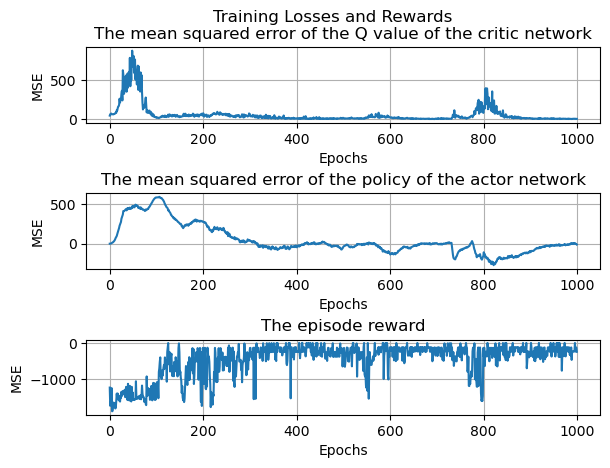

In [238]:
Plotting(q_loss_plot, policy_loss_plot, reward_plot)

In [239]:
def run_episode(agent = Random_Agent):
  """Execute one episode of an agent in the pendulum environment"""
  current_state = pendulum.reset()[0] # returns the initial state
  max_it = False
  i = 0
  total_reward = 0
  while not max_it:
    # The instructions state that trunc becomes True once max_it has been surpassed
    # The source code however outputs a False statically, hence this break section of code
    if i >= 200:
      max_it = True
      break
    action = agent.compute_action(state = current_state, device = device)
    transformed_action = pendulum.action(action.detach().cpu().numpy()) # maps an action to [-1, 1] interval
    next_state, reward, term, trunc, info = pendulum.step(transformed_action) 

    current_state = next_state
    total_reward += reward
    i += 1
  return total_reward

In [240]:
#TODO: Execute 100 test episodes with the trained policy. Remember not to add noise
#  to the actions in this phase. Report the average cumulative reward obtained by it.

#TODO: ask about test learning rule

# execute 100 episodes with DDPG agent to get an average cumulative reward
reward_vector_DDPG_agent = []
for j in range(100):
  total_reward = run_episode(agent = ddpg_agent)
  reward_vector_DDPG_agent.append(total_reward)
  
print("The average cumulative reward obtained with ddpg agent:", np.mean(reward_vector_DDPG_agent))


The average cumulative reward obtained with ddpg agent: -208.6025912255344


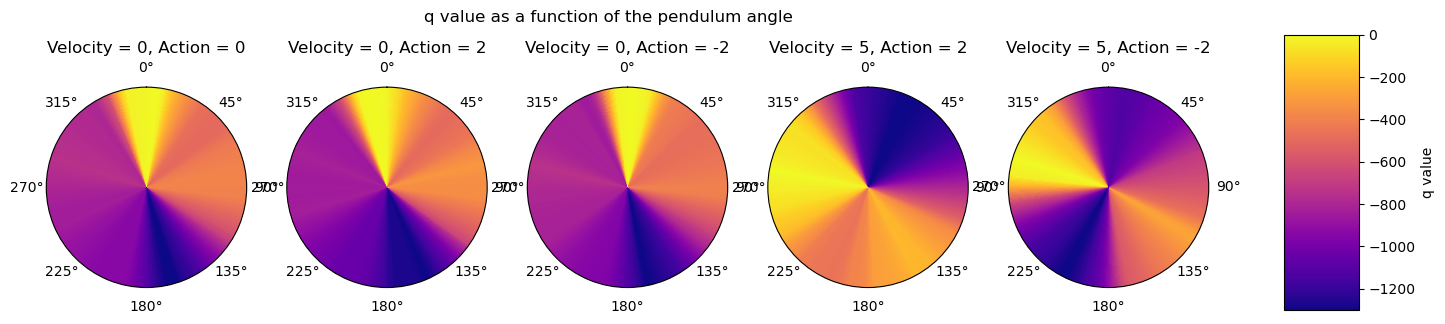

In [241]:
#TODO: Plot the heatmaps visualizing the Q function for the same values of action and angular velocity
# that you used for the Q network trained with the heuristic policy. Report your plots and comment
# about the similarities and differences

Multiple_HeatMap(critic, Action, Velocity)

#### 6 Target Networks
Implementation of the target networks for the DDPG algorithm: the target actor network, the target critic network and the update_target_params() method.

In [242]:
Tau = [0, 0.01, 0.1, 0.5, 0.75, 0.1]

policy_optimizer  = optim.Adam(actor.parameters(),  lr=LEARNING_RATE)


In [243]:
#Creating pendulum object
pendulum = gym.make('Pendulum-v1', g=9.81)
#Wrapping pendulum to map output space to [-1,1]
pendulum = NormalizedEnv(pendulum)

gauss_noise = GaussianActionNoise(NOISE_STD)



In [244]:
class DDPGAgent:
    def __init__(self, policy_network, noisy_action, target_policy_network, theta = 0.5):
        self.policy_network = policy_network
        self.target_policy_network = target_policy_network
        self.noisy_action = noisy_action
        self.theta = theta
    def compute_action(self, state, device, deterministic=True, target = False):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)

        #network selection for action choice. 
        if target == False:
            action = self.policy_network(state)
        elif target == True:
            action = self.target_policy_network(state)


        if not deterministic:
            out = action.detach().cpu().numpy()[0]
            if self.noisy_action == gauss_noise:
                out = self.noisy_action.get_noisy_action(out)
            else:
                out = self.noisy_action.get_noisy_action(out, self.theta)
        else:
            out = action[0]

        return out

    def update_target_params(self, network, target_network, Tau):
        for p_target, p in zip(target_network.parameters(), network.parameters()):
            p_target.data = Tau*p.data + (1-Tau)*p_target.data
    


In [245]:
def train_network_varying_Tau(Tau = 1, noise = gauss_noise, deterministic = True, theta = 0.5):

    critic  = QNetwork().to(device) # critic
    target_critic = QNetwork().to(device) # Target critic network

    actor = PolicyNetwork().to(device) # policy_network
    target_actor = PolicyNetwork().to(device) # Target actor network

    memory = ReplayBuffer(max_size=BUFFER_SIZE)
    agent = DDPGAgent(actor, noise, target_actor, theta = theta)

    plot_reward = []
    plot_policy = []
    plot_q = []
    plot_steps = []


    average_reward = 0
    global_step = 0
    nr_of_samples = 128

    PRINT_EVERY = 10

    for episode in tqdm(range(NUM_EPISODES)):
        current_state = deepcopy(pendulum.reset()[0])

        ep_reward = 0.
        ep_q_value = 0.
        step = 0

        # collect experience
        for iter in range(MAX_IT):
            action = agent.compute_action(state = current_state, device=device, deterministic=deterministic)
            action = action[0]

            next_state, reward, term, trunc, info = pendulum.step(action)

            memory.add_transition(state = current_state, action = action, reward = reward, next_state = next_state, trunc = trunc)

            if memory.count() > nr_of_samples:
                # sample a batch of transitions from the replay buffer
                state_batch, action_batch, reward_batch, next_state_batch, trunc_batch = memory.sample_transition(nr_of_samples)

                # converting to tensors
                state_batch = torch.FloatTensor(state_batch).to(device)
                action_batch = torch.FloatTensor(action_batch).unsqueeze(1).to(device)
                reward_batch = torch.FloatTensor(np.array(reward_batch)).unsqueeze(1).to(device) #.unsqueeze(1)
                trunc_batch = torch.Tensor(np.float32(trunc_batch)).unsqueeze(1).to(device)
                next_state_batch = torch.FloatTensor(next_state_batch).to(device)

                # 1-step TD-learning rule                                 
                with torch.no_grad():
                    action_next_state = agent.compute_action(state = next_state_batch, device=device, target = True) # no grad
                    network_input_next_state = torch.cat((next_state_batch, torch.Tensor(action_next_state)),1)
                    q_next = target_critic(network_input_next_state) # should not be differentiated 

                if iter == MAX_IT:
                    q_next = 0
                target_state = reward_batch + GAMMA * q_next # the last update in each episode should use q = 0 
                
                network_input_state = torch.cat((state_batch, action_batch),1)
                q = critic(network_input_state)
        
                q_optimizer.zero_grad()
                q_loss = MSE(target_state, q)
                q_loss.backward()
                q_optimizer.step()


                #Update target_actor and critic network
                agent.update_target_params(critic, target_critic, Tau)
                agent.update_target_params(actor, target_actor, Tau)

            
                policy_loss = learning_policy(state_batch, policy_optimizer, actor, critic)
                
                        
            
            current_state = deepcopy(next_state)
            ep_reward += reward
        try:
            plot_reward.append(ep_reward)
            plot_policy.append(policy_loss.data)
            plot_q.append(q_loss.data)
            plot_steps.append(step+1)

        except:
            continue
        average_reward += ep_reward

        if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
            print("Policy loss: ", policy_loss.data)
            print("Q loss: ", q_loss.data)
            print("Episode reward: ", ep_reward)
    return agent, plot_reward, plot_policy, plot_q 

  1%|          | 10/1000 [00:21<36:40,  2.22s/it]

Policy loss:  tensor(0.2478)
Q loss:  tensor(56.8954)
Episode reward:  -1867.319104519231


  2%|▏         | 20/1000 [00:43<36:06,  2.21s/it]

Policy loss:  tensor(0.2331)
Q loss:  tensor(58.4415)
Episode reward:  -1300.869080245499


  3%|▎         | 30/1000 [01:05<36:14,  2.24s/it]

Policy loss:  tensor(0.2237)
Q loss:  tensor(62.8265)
Episode reward:  -1676.3434867549065


  4%|▍         | 40/1000 [01:28<35:17,  2.21s/it]

Policy loss:  tensor(0.2265)
Q loss:  tensor(56.6279)
Episode reward:  -1817.9617646746917


  5%|▌         | 50/1000 [01:50<35:31,  2.24s/it]

Policy loss:  tensor(0.2284)
Q loss:  tensor(60.0009)
Episode reward:  -1517.279831978465


  6%|▌         | 60/1000 [02:12<34:42,  2.22s/it]

Policy loss:  tensor(0.2184)
Q loss:  tensor(60.7365)
Episode reward:  -1702.694724933029


  7%|▋         | 70/1000 [02:36<36:03,  2.33s/it]

Policy loss:  tensor(0.2088)
Q loss:  tensor(53.3756)
Episode reward:  -1355.862192423128


  8%|▊         | 80/1000 [02:58<35:05,  2.29s/it]

Policy loss:  tensor(0.2131)
Q loss:  tensor(60.5690)
Episode reward:  -1376.1771235123392


  9%|▉         | 90/1000 [03:21<34:19,  2.26s/it]

Policy loss:  tensor(0.2241)
Q loss:  tensor(61.1041)
Episode reward:  -1649.2805958436106


 10%|█         | 100/1000 [03:43<33:25,  2.23s/it]

Policy loss:  tensor(0.2253)
Q loss:  tensor(59.6572)
Episode reward:  -1477.0639150283603


 11%|█         | 110/1000 [04:05<32:19,  2.18s/it]

Policy loss:  tensor(0.2218)
Q loss:  tensor(55.6071)
Episode reward:  -1740.4585988635595


 12%|█▏        | 120/1000 [04:28<33:39,  2.30s/it]

Policy loss:  tensor(0.2172)
Q loss:  tensor(55.5716)
Episode reward:  -1511.0587235750534


 13%|█▎        | 130/1000 [04:51<33:18,  2.30s/it]

Policy loss:  tensor(0.2160)
Q loss:  tensor(56.2948)
Episode reward:  -1798.8145962345152


 14%|█▍        | 140/1000 [05:14<32:37,  2.28s/it]

Policy loss:  tensor(0.2267)
Q loss:  tensor(56.4611)
Episode reward:  -1308.6765584805482


 15%|█▌        | 150/1000 [05:37<31:49,  2.25s/it]

Policy loss:  tensor(0.2415)
Q loss:  tensor(62.6261)
Episode reward:  -1330.4239247065987


 16%|█▌        | 160/1000 [06:00<31:36,  2.26s/it]

Policy loss:  tensor(0.2193)
Q loss:  tensor(58.4217)
Episode reward:  -1781.9679458545997


 17%|█▋        | 170/1000 [06:22<31:24,  2.27s/it]

Policy loss:  tensor(0.2247)
Q loss:  tensor(58.2122)
Episode reward:  -1884.483327074985


 18%|█▊        | 180/1000 [06:45<30:42,  2.25s/it]

Policy loss:  tensor(0.2186)
Q loss:  tensor(57.9259)
Episode reward:  -1750.7301256632625


 19%|█▉        | 190/1000 [07:07<30:28,  2.26s/it]

Policy loss:  tensor(0.2231)
Q loss:  tensor(59.7500)
Episode reward:  -1467.1651930284538


 20%|██        | 200/1000 [07:30<29:54,  2.24s/it]

Policy loss:  tensor(0.2112)
Q loss:  tensor(53.5445)
Episode reward:  -1469.3385793265998


 21%|██        | 210/1000 [07:53<30:21,  2.31s/it]

Policy loss:  tensor(0.2232)
Q loss:  tensor(54.3071)
Episode reward:  -1817.1331997295465


 22%|██▏       | 220/1000 [08:16<30:18,  2.33s/it]

Policy loss:  tensor(0.2116)
Q loss:  tensor(52.5723)
Episode reward:  -1714.321925138093


 23%|██▎       | 230/1000 [08:39<29:19,  2.29s/it]

Policy loss:  tensor(0.2346)
Q loss:  tensor(59.0282)
Episode reward:  -1377.9958204619747


 24%|██▍       | 240/1000 [09:01<28:02,  2.21s/it]

Policy loss:  tensor(0.2151)
Q loss:  tensor(58.4667)
Episode reward:  -1740.6161507391528


 25%|██▌       | 250/1000 [09:23<28:09,  2.25s/it]

Policy loss:  tensor(0.2201)
Q loss:  tensor(58.6944)
Episode reward:  -1594.0448476324061


 26%|██▌       | 260/1000 [09:45<27:26,  2.22s/it]

Policy loss:  tensor(0.2218)
Q loss:  tensor(61.0766)
Episode reward:  -1684.1992112726011


 27%|██▋       | 270/1000 [10:08<27:02,  2.22s/it]

Policy loss:  tensor(0.2127)
Q loss:  tensor(61.1049)
Episode reward:  -1354.3998886885543


 28%|██▊       | 280/1000 [10:31<26:55,  2.24s/it]

Policy loss:  tensor(0.2132)
Q loss:  tensor(56.8382)
Episode reward:  -1287.5661366409581


 29%|██▉       | 290/1000 [10:54<27:09,  2.29s/it]

Policy loss:  tensor(0.2240)
Q loss:  tensor(60.4965)
Episode reward:  -1497.64734337515


 30%|███       | 300/1000 [11:17<25:37,  2.20s/it]

Policy loss:  tensor(0.2136)
Q loss:  tensor(57.1702)
Episode reward:  -1792.1543553376805


 31%|███       | 310/1000 [11:39<25:27,  2.21s/it]

Policy loss:  tensor(0.2167)
Q loss:  tensor(58.3996)
Episode reward:  -1871.575384464975


 32%|███▏      | 320/1000 [12:02<26:53,  2.37s/it]

Policy loss:  tensor(0.2414)
Q loss:  tensor(56.8570)
Episode reward:  -1317.7607860518672


 33%|███▎      | 330/1000 [12:25<25:45,  2.31s/it]

Policy loss:  tensor(0.2159)
Q loss:  tensor(54.9735)
Episode reward:  -1376.12943162729


 34%|███▍      | 340/1000 [12:48<25:42,  2.34s/it]

Policy loss:  tensor(0.2164)
Q loss:  tensor(58.4199)
Episode reward:  -1800.375701275518


 35%|███▌      | 350/1000 [13:14<26:54,  2.48s/it]

Policy loss:  tensor(0.2314)
Q loss:  tensor(58.4398)
Episode reward:  -1624.6472470679962


 36%|███▌      | 360/1000 [13:36<24:11,  2.27s/it]

Policy loss:  tensor(0.2349)
Q loss:  tensor(54.8664)
Episode reward:  -1522.8107589441136


 37%|███▋      | 370/1000 [13:59<23:47,  2.27s/it]

Policy loss:  tensor(0.2365)
Q loss:  tensor(57.1053)
Episode reward:  -1278.0404689708087


 38%|███▊      | 380/1000 [14:22<23:41,  2.29s/it]

Policy loss:  tensor(0.2187)
Q loss:  tensor(54.8237)
Episode reward:  -1518.6520997553307


 39%|███▉      | 390/1000 [14:45<23:20,  2.30s/it]

Policy loss:  tensor(0.2208)
Q loss:  tensor(55.3083)
Episode reward:  -1547.5104740564352


 40%|████      | 400/1000 [15:08<23:15,  2.33s/it]

Policy loss:  tensor(0.2147)
Q loss:  tensor(60.1676)
Episode reward:  -1296.6858000040902


 41%|████      | 410/1000 [15:30<21:36,  2.20s/it]

Policy loss:  tensor(0.2052)
Q loss:  tensor(56.1652)
Episode reward:  -1825.732524347139


 42%|████▏     | 420/1000 [15:52<21:43,  2.25s/it]

Policy loss:  tensor(0.2247)
Q loss:  tensor(54.0490)
Episode reward:  -1213.1905734442096


 43%|████▎     | 430/1000 [16:15<21:52,  2.30s/it]

Policy loss:  tensor(0.2371)
Q loss:  tensor(57.9325)
Episode reward:  -1302.8396373454723


 44%|████▍     | 440/1000 [16:38<21:11,  2.27s/it]

Policy loss:  tensor(0.2229)
Q loss:  tensor(58.6087)
Episode reward:  -1438.556356073482


 45%|████▌     | 450/1000 [17:01<20:52,  2.28s/it]

Policy loss:  tensor(0.2282)
Q loss:  tensor(58.9340)
Episode reward:  -1354.679273514833


 46%|████▌     | 460/1000 [17:24<21:19,  2.37s/it]

Policy loss:  tensor(0.2298)
Q loss:  tensor(56.0486)
Episode reward:  -1552.6482573184016


 47%|████▋     | 470/1000 [17:48<20:56,  2.37s/it]

Policy loss:  tensor(0.2406)
Q loss:  tensor(57.8075)
Episode reward:  -1782.7046260050572


 48%|████▊     | 480/1000 [18:11<20:27,  2.36s/it]

Policy loss:  tensor(0.2189)
Q loss:  tensor(57.5754)
Episode reward:  -1877.755107062025


 49%|████▉     | 490/1000 [18:34<20:03,  2.36s/it]

Policy loss:  tensor(0.2302)
Q loss:  tensor(57.1001)
Episode reward:  -1846.0484879477706


 50%|█████     | 500/1000 [18:57<19:02,  2.28s/it]

Policy loss:  tensor(0.2177)
Q loss:  tensor(53.2253)
Episode reward:  -1523.7651815800432


 51%|█████     | 510/1000 [19:20<18:41,  2.29s/it]

Policy loss:  tensor(0.2193)
Q loss:  tensor(53.0380)
Episode reward:  -1529.8066398753692


 52%|█████▏    | 520/1000 [19:43<18:12,  2.28s/it]

Policy loss:  tensor(0.2182)
Q loss:  tensor(57.9332)
Episode reward:  -1800.0164910906917


 53%|█████▎    | 530/1000 [20:06<18:04,  2.31s/it]

Policy loss:  tensor(0.2289)
Q loss:  tensor(62.6602)
Episode reward:  -1380.2743952650749


 54%|█████▍    | 540/1000 [20:29<17:43,  2.31s/it]

Policy loss:  tensor(0.2245)
Q loss:  tensor(61.2208)
Episode reward:  -1652.6307726081236


 55%|█████▌    | 550/1000 [20:52<16:46,  2.24s/it]

Policy loss:  tensor(0.2332)
Q loss:  tensor(64.2631)
Episode reward:  -1404.3734575906203


 56%|█████▌    | 560/1000 [21:15<16:44,  2.28s/it]

Policy loss:  tensor(0.2103)
Q loss:  tensor(58.5856)
Episode reward:  -1442.5096034937374


 57%|█████▋    | 570/1000 [21:38<16:42,  2.33s/it]

Policy loss:  tensor(0.2137)
Q loss:  tensor(59.4950)
Episode reward:  -1631.5238806590853


 58%|█████▊    | 580/1000 [22:00<16:05,  2.30s/it]

Policy loss:  tensor(0.2200)
Q loss:  tensor(56.8200)
Episode reward:  -1466.9747131288336


 59%|█████▉    | 590/1000 [22:24<15:42,  2.30s/it]

Policy loss:  tensor(0.2323)
Q loss:  tensor(61.4817)
Episode reward:  -1459.5455053825224


 60%|██████    | 600/1000 [22:47<15:29,  2.32s/it]

Policy loss:  tensor(0.2346)
Q loss:  tensor(63.1837)
Episode reward:  -1711.0340337895796


 61%|██████    | 610/1000 [23:10<14:48,  2.28s/it]

Policy loss:  tensor(0.2408)
Q loss:  tensor(60.8716)
Episode reward:  -1520.0853079307255


 62%|██████▏   | 620/1000 [23:33<14:35,  2.30s/it]

Policy loss:  tensor(0.2124)
Q loss:  tensor(55.3776)
Episode reward:  -1370.493685736452


 63%|██████▎   | 630/1000 [23:56<14:09,  2.30s/it]

Policy loss:  tensor(0.2141)
Q loss:  tensor(52.5570)
Episode reward:  -1236.8773395434202


 64%|██████▍   | 640/1000 [24:18<13:57,  2.33s/it]

Policy loss:  tensor(0.2251)
Q loss:  tensor(57.1743)
Episode reward:  -1530.4530896449075


 65%|██████▌   | 650/1000 [24:41<13:28,  2.31s/it]

Policy loss:  tensor(0.2125)
Q loss:  tensor(61.9123)
Episode reward:  -1828.6968527208744


 66%|██████▌   | 660/1000 [25:04<12:47,  2.26s/it]

Policy loss:  tensor(0.2402)
Q loss:  tensor(58.8237)
Episode reward:  -1829.524831469836


 67%|██████▋   | 670/1000 [25:27<12:43,  2.31s/it]

Policy loss:  tensor(0.2330)
Q loss:  tensor(57.4327)
Episode reward:  -1240.462750867774


 68%|██████▊   | 680/1000 [25:50<12:23,  2.32s/it]

Policy loss:  tensor(0.2290)
Q loss:  tensor(59.7962)
Episode reward:  -1759.293837177122


 69%|██████▉   | 690/1000 [26:13<12:26,  2.41s/it]

Policy loss:  tensor(0.2268)
Q loss:  tensor(59.4422)
Episode reward:  -1824.5565512273743


 70%|███████   | 700/1000 [26:36<11:17,  2.26s/it]

Policy loss:  tensor(0.2273)
Q loss:  tensor(54.8140)
Episode reward:  -1348.9758885179517


 71%|███████   | 710/1000 [26:58<11:05,  2.30s/it]

Policy loss:  tensor(0.2264)
Q loss:  tensor(57.7229)
Episode reward:  -1714.748585349665


 72%|███████▏  | 720/1000 [27:21<10:31,  2.26s/it]

Policy loss:  tensor(0.2329)
Q loss:  tensor(60.8294)
Episode reward:  -1312.8045407794623


 73%|███████▎  | 730/1000 [27:44<10:25,  2.32s/it]

Policy loss:  tensor(0.2452)
Q loss:  tensor(57.4852)
Episode reward:  -1445.5421549327662


 74%|███████▍  | 740/1000 [28:07<09:39,  2.23s/it]

Policy loss:  tensor(0.2195)
Q loss:  tensor(52.3947)
Episode reward:  -1508.338388886927


 75%|███████▌  | 750/1000 [28:29<09:27,  2.27s/it]

Policy loss:  tensor(0.2279)
Q loss:  tensor(56.1564)
Episode reward:  -1325.7160663737682


 76%|███████▌  | 760/1000 [28:52<09:09,  2.29s/it]

Policy loss:  tensor(0.2291)
Q loss:  tensor(58.7284)
Episode reward:  -1482.1831001701298


 77%|███████▋  | 770/1000 [29:14<08:37,  2.25s/it]

Policy loss:  tensor(0.2208)
Q loss:  tensor(57.4545)
Episode reward:  -1775.6563051158728


 78%|███████▊  | 780/1000 [29:36<07:57,  2.17s/it]

Policy loss:  tensor(0.2125)
Q loss:  tensor(61.9568)
Episode reward:  -1594.1197946191378


 79%|███████▉  | 790/1000 [29:59<07:58,  2.28s/it]

Policy loss:  tensor(0.2415)
Q loss:  tensor(61.5331)
Episode reward:  -1633.5881766493098


 80%|████████  | 800/1000 [30:21<07:32,  2.26s/it]

Policy loss:  tensor(0.2277)
Q loss:  tensor(60.3806)
Episode reward:  -1542.321443602053


 81%|████████  | 810/1000 [30:44<06:51,  2.17s/it]

Policy loss:  tensor(0.2207)
Q loss:  tensor(60.5718)
Episode reward:  -1205.9145203845273


 82%|████████▏ | 820/1000 [31:06<06:47,  2.26s/it]

Policy loss:  tensor(0.2171)
Q loss:  tensor(65.6577)
Episode reward:  -1847.5435514686078


 83%|████████▎ | 830/1000 [31:29<06:16,  2.21s/it]

Policy loss:  tensor(0.2141)
Q loss:  tensor(64.8477)
Episode reward:  -1828.2588578582024


 84%|████████▍ | 840/1000 [31:51<05:49,  2.18s/it]

Policy loss:  tensor(0.2181)
Q loss:  tensor(62.3992)
Episode reward:  -1692.6794414652263


 85%|████████▌ | 850/1000 [32:14<05:38,  2.25s/it]

Policy loss:  tensor(0.2113)
Q loss:  tensor(63.2548)
Episode reward:  -1203.6074328445045


 86%|████████▌ | 860/1000 [32:36<05:13,  2.24s/it]

Policy loss:  tensor(0.2148)
Q loss:  tensor(58.4211)
Episode reward:  -1730.591052101183


 87%|████████▋ | 870/1000 [32:59<05:01,  2.32s/it]

Policy loss:  tensor(0.2202)
Q loss:  tensor(62.2703)
Episode reward:  -1337.429432803083


 88%|████████▊ | 880/1000 [33:22<04:30,  2.26s/it]

Policy loss:  tensor(0.2260)
Q loss:  tensor(60.1237)
Episode reward:  -1321.2676049113327


 89%|████████▉ | 890/1000 [33:45<04:08,  2.26s/it]

Policy loss:  tensor(0.2221)
Q loss:  tensor(56.0943)
Episode reward:  -1679.1620698876727


 90%|█████████ | 900/1000 [34:08<03:50,  2.30s/it]

Policy loss:  tensor(0.2280)
Q loss:  tensor(57.7413)
Episode reward:  -1556.5908597894054


 91%|█████████ | 910/1000 [34:31<03:25,  2.28s/it]

Policy loss:  tensor(0.2216)
Q loss:  tensor(59.1347)
Episode reward:  -1594.58675799391


 92%|█████████▏| 920/1000 [34:53<03:01,  2.27s/it]

Policy loss:  tensor(0.2094)
Q loss:  tensor(54.0327)
Episode reward:  -1544.065237457067


 93%|█████████▎| 930/1000 [35:16<02:36,  2.24s/it]

Policy loss:  tensor(0.2326)
Q loss:  tensor(56.6858)
Episode reward:  -1374.850401733785


 94%|█████████▍| 940/1000 [35:38<02:15,  2.25s/it]

Policy loss:  tensor(0.2358)
Q loss:  tensor(52.8225)
Episode reward:  -1325.2329713866482


 95%|█████████▌| 950/1000 [36:01<01:50,  2.20s/it]

Policy loss:  tensor(0.2158)
Q loss:  tensor(54.4015)
Episode reward:  -1534.2056932258415


 96%|█████████▌| 960/1000 [36:23<01:29,  2.23s/it]

Policy loss:  tensor(0.2220)
Q loss:  tensor(57.9259)
Episode reward:  -1600.6464798746945


 97%|█████████▋| 970/1000 [36:46<01:08,  2.29s/it]

Policy loss:  tensor(0.2143)
Q loss:  tensor(58.2241)
Episode reward:  -1874.5761936016481


 98%|█████████▊| 980/1000 [37:09<00:45,  2.28s/it]

Policy loss:  tensor(0.2224)
Q loss:  tensor(58.5464)
Episode reward:  -1877.9729322953021


 99%|█████████▉| 990/1000 [37:32<00:22,  2.25s/it]

Policy loss:  tensor(0.2229)
Q loss:  tensor(63.8185)
Episode reward:  -1484.2519754482369


100%|██████████| 1000/1000 [37:55<00:00,  2.28s/it]

Policy loss:  tensor(0.2256)
Q loss:  tensor(59.7311)
Episode reward:  -1891.2474364166785


The average cumulative reward obtained with ddpg with \Tau = 0 agent: -1693.7977802717078


  1%|          | 10/1000 [00:20<36:08,  2.19s/it]

Policy loss:  tensor(0.1704)
Q loss:  tensor(48.0747)
Episode reward:  -1340.3065209953463


  2%|▏         | 20/1000 [00:42<35:59,  2.20s/it]

Policy loss:  tensor(0.1657)
Q loss:  tensor(45.7167)
Episode reward:  -1298.3704139043448


  3%|▎         | 30/1000 [01:04<36:13,  2.24s/it]

Policy loss:  tensor(0.1521)
Q loss:  tensor(47.5795)
Episode reward:  -796.3851147006492


  4%|▍         | 40/1000 [01:27<35:42,  2.23s/it]

Policy loss:  tensor(0.1542)
Q loss:  tensor(51.4983)
Episode reward:  -654.6405449898043


  5%|▌         | 50/1000 [01:49<35:28,  2.24s/it]

Policy loss:  tensor(0.1661)
Q loss:  tensor(51.9188)
Episode reward:  -1177.7731416100883


  6%|▌         | 60/1000 [02:11<34:52,  2.23s/it]

Policy loss:  tensor(0.1655)
Q loss:  tensor(50.4940)
Episode reward:  -1750.9480182606057


  7%|▋         | 70/1000 [02:34<34:33,  2.23s/it]

Policy loss:  tensor(0.1488)
Q loss:  tensor(52.5952)
Episode reward:  -769.3736108296349


  8%|▊         | 80/1000 [02:57<35:06,  2.29s/it]

Policy loss:  tensor(0.1448)
Q loss:  tensor(42.8583)
Episode reward:  -1179.4393601477893


  9%|▉         | 90/1000 [03:20<33:59,  2.24s/it]

Policy loss:  tensor(0.1659)
Q loss:  tensor(54.0861)
Episode reward:  -862.4329830489436


 10%|█         | 100/1000 [03:42<33:07,  2.21s/it]

Policy loss:  tensor(0.1465)
Q loss:  tensor(40.6748)
Episode reward:  -1344.0789886015698


 11%|█         | 110/1000 [04:04<32:49,  2.21s/it]

Policy loss:  tensor(0.1550)
Q loss:  tensor(48.5869)
Episode reward:  -1065.944993192034


 12%|█▏        | 120/1000 [04:27<31:49,  2.17s/it]

Policy loss:  tensor(0.1580)
Q loss:  tensor(51.8358)
Episode reward:  -1593.254138222056


 13%|█▎        | 130/1000 [04:49<32:42,  2.26s/it]

Policy loss:  tensor(0.1420)
Q loss:  tensor(51.3880)
Episode reward:  -1640.5662886399148


 14%|█▍        | 140/1000 [05:12<33:07,  2.31s/it]

Policy loss:  tensor(0.1562)
Q loss:  tensor(48.5763)
Episode reward:  -846.8359564797853


 15%|█▌        | 150/1000 [05:36<32:11,  2.27s/it]

Policy loss:  tensor(0.1391)
Q loss:  tensor(47.7230)
Episode reward:  -1424.7996463590753


 16%|█▌        | 160/1000 [05:59<31:59,  2.29s/it]

Policy loss:  tensor(0.1474)
Q loss:  tensor(53.6899)
Episode reward:  -885.2448742569102


 17%|█▋        | 170/1000 [06:21<30:55,  2.24s/it]

Policy loss:  tensor(0.1497)
Q loss:  tensor(49.8616)
Episode reward:  -1068.3804696318496


 18%|█▊        | 180/1000 [06:43<30:51,  2.26s/it]

Policy loss:  tensor(0.1578)
Q loss:  tensor(43.0510)
Episode reward:  -1052.5607432464215


 19%|█▉        | 190/1000 [07:06<30:28,  2.26s/it]

Policy loss:  tensor(0.1404)
Q loss:  tensor(43.0331)
Episode reward:  -1379.6960154488313


 20%|██        | 200/1000 [07:28<30:11,  2.26s/it]

Policy loss:  tensor(0.1451)
Q loss:  tensor(49.4413)
Episode reward:  -1709.702074974671


 21%|██        | 210/1000 [07:51<29:26,  2.24s/it]

Policy loss:  tensor(0.1524)
Q loss:  tensor(48.0181)
Episode reward:  -744.5045137233527


 22%|██▏       | 220/1000 [08:13<29:10,  2.24s/it]

Policy loss:  tensor(0.1321)
Q loss:  tensor(45.1234)
Episode reward:  -857.2427283813905


 23%|██▎       | 230/1000 [08:36<29:31,  2.30s/it]

Policy loss:  tensor(0.1605)
Q loss:  tensor(48.4650)
Episode reward:  -1065.4316179236198


 24%|██▍       | 240/1000 [08:58<28:19,  2.24s/it]

Policy loss:  tensor(0.1593)
Q loss:  tensor(40.9716)
Episode reward:  -1073.8363621324504


 25%|██▌       | 250/1000 [09:21<28:22,  2.27s/it]

Policy loss:  tensor(0.1561)
Q loss:  tensor(44.4111)
Episode reward:  -954.4282843328674


 26%|██▌       | 260/1000 [09:43<27:24,  2.22s/it]

Policy loss:  tensor(0.1586)
Q loss:  tensor(44.9460)
Episode reward:  -1876.2361721688542


 27%|██▋       | 270/1000 [10:06<27:23,  2.25s/it]

Policy loss:  tensor(0.1548)
Q loss:  tensor(48.2859)
Episode reward:  -1720.9776784355638


 28%|██▊       | 280/1000 [10:28<26:50,  2.24s/it]

Policy loss:  tensor(0.1593)
Q loss:  tensor(44.5207)
Episode reward:  -907.83179090111


 29%|██▉       | 290/1000 [10:51<26:53,  2.27s/it]

Policy loss:  tensor(0.1621)
Q loss:  tensor(53.0239)
Episode reward:  -1307.7065627628238


 30%|███       | 300/1000 [11:14<26:57,  2.31s/it]

Policy loss:  tensor(0.1532)
Q loss:  tensor(45.4332)
Episode reward:  -1648.82553929394


 31%|███       | 310/1000 [11:37<25:45,  2.24s/it]

Policy loss:  tensor(0.1514)
Q loss:  tensor(55.2646)
Episode reward:  -769.3743543070761


 32%|███▏      | 320/1000 [11:59<25:05,  2.21s/it]

Policy loss:  tensor(0.1590)
Q loss:  tensor(55.7786)
Episode reward:  -1421.3332743725537


 33%|███▎      | 330/1000 [12:21<25:28,  2.28s/it]

Policy loss:  tensor(0.1492)
Q loss:  tensor(57.5345)
Episode reward:  -1071.4751882943788


 34%|███▍      | 340/1000 [12:44<25:06,  2.28s/it]

Policy loss:  tensor(0.1393)
Q loss:  tensor(56.7497)
Episode reward:  -1173.3391029420193


 35%|███▌      | 350/1000 [13:06<24:38,  2.27s/it]

Policy loss:  tensor(0.1423)
Q loss:  tensor(43.2568)
Episode reward:  -1073.3873859483183


 36%|███▌      | 360/1000 [13:29<24:18,  2.28s/it]

Policy loss:  tensor(0.1424)
Q loss:  tensor(50.8146)
Episode reward:  -1049.111809226214


 37%|███▋      | 370/1000 [13:52<23:37,  2.25s/it]

Policy loss:  tensor(0.1582)
Q loss:  tensor(44.2560)
Episode reward:  -1286.3542198398075


 38%|███▊      | 380/1000 [14:15<23:27,  2.27s/it]

Policy loss:  tensor(0.1658)
Q loss:  tensor(47.2329)
Episode reward:  -1577.2680188363809


 39%|███▉      | 390/1000 [14:37<22:29,  2.21s/it]

Policy loss:  tensor(0.1581)
Q loss:  tensor(43.1918)
Episode reward:  -1094.666973637091


 40%|████      | 400/1000 [15:00<22:32,  2.25s/it]

Policy loss:  tensor(0.1633)
Q loss:  tensor(46.8952)
Episode reward:  -1134.3153628966902


 41%|████      | 410/1000 [15:23<22:31,  2.29s/it]

Policy loss:  tensor(0.1445)
Q loss:  tensor(44.6642)
Episode reward:  -892.5980825727377


 42%|████▏     | 420/1000 [15:45<21:37,  2.24s/it]

Policy loss:  tensor(0.1614)
Q loss:  tensor(41.2177)
Episode reward:  -1482.84770991058


 43%|████▎     | 430/1000 [16:07<21:13,  2.23s/it]

Policy loss:  tensor(0.1557)
Q loss:  tensor(35.5331)
Episode reward:  -877.2801474216241


 44%|████▍     | 440/1000 [16:30<21:13,  2.27s/it]

Policy loss:  tensor(0.1503)
Q loss:  tensor(43.9160)
Episode reward:  -882.4663171664043


 45%|████▌     | 450/1000 [16:53<20:59,  2.29s/it]

Policy loss:  tensor(0.1549)
Q loss:  tensor(41.4519)
Episode reward:  -873.3265020836217


 46%|████▌     | 460/1000 [17:16<20:21,  2.26s/it]

Policy loss:  tensor(0.1630)
Q loss:  tensor(44.6592)
Episode reward:  -839.0766451110857


 47%|████▋     | 470/1000 [17:38<19:55,  2.26s/it]

Policy loss:  tensor(0.1683)
Q loss:  tensor(48.5040)
Episode reward:  -1148.688454228606


 48%|████▊     | 480/1000 [18:00<19:29,  2.25s/it]

Policy loss:  tensor(0.1505)
Q loss:  tensor(45.0682)
Episode reward:  -1552.271265523461


 49%|████▉     | 490/1000 [18:23<19:18,  2.27s/it]

Policy loss:  tensor(0.1723)
Q loss:  tensor(49.3163)
Episode reward:  -1064.4993946343582


 50%|█████     | 500/1000 [18:46<18:46,  2.25s/it]

Policy loss:  tensor(0.1566)
Q loss:  tensor(44.9703)
Episode reward:  -1068.2183407307284


 51%|█████     | 510/1000 [19:08<18:18,  2.24s/it]

Policy loss:  tensor(0.1521)
Q loss:  tensor(39.9832)
Episode reward:  -973.853410641327


 52%|█████▏    | 520/1000 [19:31<17:57,  2.25s/it]

Policy loss:  tensor(0.1495)
Q loss:  tensor(44.5015)
Episode reward:  -938.4545795877226


 53%|█████▎    | 530/1000 [19:53<17:19,  2.21s/it]

Policy loss:  tensor(0.1483)
Q loss:  tensor(47.3838)
Episode reward:  -1629.8783524798523


 54%|█████▍    | 540/1000 [20:16<18:00,  2.35s/it]

Policy loss:  tensor(0.1355)
Q loss:  tensor(45.8070)
Episode reward:  -1161.2284509738354


 55%|█████▌    | 550/1000 [20:39<16:49,  2.24s/it]

Policy loss:  tensor(0.1376)
Q loss:  tensor(52.0337)
Episode reward:  -1608.3361758547267


 56%|█████▌    | 560/1000 [21:02<16:44,  2.28s/it]

Policy loss:  tensor(0.1432)
Q loss:  tensor(45.0562)
Episode reward:  -1011.4133648200167


 57%|█████▋    | 570/1000 [21:25<16:40,  2.33s/it]

Policy loss:  tensor(0.1466)
Q loss:  tensor(48.4783)
Episode reward:  -1296.808008843465


 58%|█████▊    | 580/1000 [21:47<16:10,  2.31s/it]

Policy loss:  tensor(0.1568)
Q loss:  tensor(51.0616)
Episode reward:  -1265.1878828960482


 59%|█████▉    | 590/1000 [22:10<15:12,  2.23s/it]

Policy loss:  tensor(0.1753)
Q loss:  tensor(51.6832)
Episode reward:  -934.6214146003741


 60%|██████    | 600/1000 [22:32<14:43,  2.21s/it]

Policy loss:  tensor(0.1531)
Q loss:  tensor(38.5665)
Episode reward:  -1171.238724644786


 61%|██████    | 610/1000 [22:55<14:41,  2.26s/it]

Policy loss:  tensor(0.1560)
Q loss:  tensor(48.3773)
Episode reward:  -862.2523891058175


 62%|██████▏   | 620/1000 [23:18<14:36,  2.31s/it]

Policy loss:  tensor(0.1629)
Q loss:  tensor(44.0783)
Episode reward:  -964.7804635041238


 63%|██████▎   | 630/1000 [23:40<13:58,  2.27s/it]

Policy loss:  tensor(0.1492)
Q loss:  tensor(45.3648)
Episode reward:  -873.1182813867075


 64%|██████▍   | 640/1000 [24:02<13:10,  2.20s/it]

Policy loss:  tensor(0.1536)
Q loss:  tensor(45.7720)
Episode reward:  -940.791074647907


 65%|██████▌   | 650/1000 [24:25<13:19,  2.29s/it]

Policy loss:  tensor(0.1679)
Q loss:  tensor(51.4083)
Episode reward:  -1055.6315307142868


 66%|██████▌   | 660/1000 [24:48<12:59,  2.29s/it]

Policy loss:  tensor(0.1621)
Q loss:  tensor(46.3903)
Episode reward:  -1222.9883552581134


 67%|██████▋   | 670/1000 [25:11<12:27,  2.26s/it]

Policy loss:  tensor(0.1756)
Q loss:  tensor(46.8345)
Episode reward:  -966.9515132820325


 68%|██████▊   | 680/1000 [25:34<12:05,  2.27s/it]

Policy loss:  tensor(0.1679)
Q loss:  tensor(42.5096)
Episode reward:  -1362.964147767874


 69%|██████▉   | 690/1000 [25:56<11:34,  2.24s/it]

Policy loss:  tensor(0.1578)
Q loss:  tensor(39.9716)
Episode reward:  -1849.4572969067926


 70%|███████   | 700/1000 [26:19<11:10,  2.23s/it]

Policy loss:  tensor(0.1653)
Q loss:  tensor(46.7166)
Episode reward:  -766.9331283948441


 71%|███████   | 710/1000 [26:42<11:01,  2.28s/it]

Policy loss:  tensor(0.1683)
Q loss:  tensor(49.4029)
Episode reward:  -1431.7293239991573


 72%|███████▏  | 720/1000 [27:05<10:28,  2.24s/it]

Policy loss:  tensor(0.1531)
Q loss:  tensor(54.4579)
Episode reward:  -995.6471111749622


 73%|███████▎  | 730/1000 [27:27<10:01,  2.23s/it]

Policy loss:  tensor(0.1502)
Q loss:  tensor(64.1106)
Episode reward:  -1066.2713204526503


 74%|███████▍  | 740/1000 [27:49<09:41,  2.23s/it]

Policy loss:  tensor(0.1529)
Q loss:  tensor(49.5620)
Episode reward:  -893.0755482127287


 75%|███████▌  | 750/1000 [28:12<09:51,  2.37s/it]

Policy loss:  tensor(0.1464)
Q loss:  tensor(47.7307)
Episode reward:  -1006.49240050866


 76%|███████▌  | 760/1000 [28:35<09:01,  2.26s/it]

Policy loss:  tensor(0.1681)
Q loss:  tensor(51.3687)
Episode reward:  -808.8445919246004


 77%|███████▋  | 770/1000 [28:58<08:42,  2.27s/it]

Policy loss:  tensor(0.1471)
Q loss:  tensor(49.1698)
Episode reward:  -1468.0200134922109


 78%|███████▊  | 780/1000 [29:21<08:27,  2.31s/it]

Policy loss:  tensor(0.1432)
Q loss:  tensor(48.7395)
Episode reward:  -953.2573023326158


 79%|███████▉  | 790/1000 [29:43<07:53,  2.25s/it]

Policy loss:  tensor(0.1743)
Q loss:  tensor(48.2111)
Episode reward:  -1069.6291647515004


 80%|████████  | 800/1000 [30:07<07:37,  2.29s/it]

Policy loss:  tensor(0.1484)
Q loss:  tensor(46.3117)
Episode reward:  -1312.9487605561872


 81%|████████  | 810/1000 [30:30<07:10,  2.27s/it]

Policy loss:  tensor(0.1593)
Q loss:  tensor(46.3801)
Episode reward:  -1655.0662886814164


 82%|████████▏ | 820/1000 [30:52<06:42,  2.23s/it]

Policy loss:  tensor(0.1371)
Q loss:  tensor(45.8350)
Episode reward:  -967.7385273593949


 83%|████████▎ | 830/1000 [31:14<06:24,  2.26s/it]

Policy loss:  tensor(0.1586)
Q loss:  tensor(53.7442)
Episode reward:  -1170.782719970633


 84%|████████▍ | 840/1000 [31:37<05:53,  2.21s/it]

Policy loss:  tensor(0.1651)
Q loss:  tensor(51.3145)
Episode reward:  -1074.6801219618003


 85%|████████▌ | 850/1000 [31:59<05:44,  2.29s/it]

Policy loss:  tensor(0.1594)
Q loss:  tensor(46.9072)
Episode reward:  -1625.6155370113402


 86%|████████▌ | 860/1000 [32:22<05:16,  2.26s/it]

Policy loss:  tensor(0.1683)
Q loss:  tensor(50.7500)
Episode reward:  -1263.7382945576128


 87%|████████▋ | 870/1000 [32:44<04:51,  2.24s/it]

Policy loss:  tensor(0.1524)
Q loss:  tensor(47.5619)
Episode reward:  -1211.030040314507


 88%|████████▊ | 880/1000 [33:07<04:31,  2.26s/it]

Policy loss:  tensor(0.1540)
Q loss:  tensor(46.5442)
Episode reward:  -1394.3947372799134


 89%|████████▉ | 890/1000 [33:29<04:04,  2.22s/it]

Policy loss:  tensor(0.1604)
Q loss:  tensor(53.8795)
Episode reward:  -751.9452835644518


 90%|█████████ | 900/1000 [33:51<03:45,  2.25s/it]

Policy loss:  tensor(0.1383)
Q loss:  tensor(38.8516)
Episode reward:  -1741.7866220070784


 91%|█████████ | 910/1000 [34:14<03:24,  2.28s/it]

Policy loss:  tensor(0.1414)
Q loss:  tensor(43.0392)
Episode reward:  -1220.5452189344892


 92%|█████████▏| 920/1000 [34:37<03:01,  2.27s/it]

Policy loss:  tensor(0.1762)
Q loss:  tensor(50.1025)
Episode reward:  -746.4226937887579


 93%|█████████▎| 930/1000 [35:00<02:35,  2.23s/it]

Policy loss:  tensor(0.1564)
Q loss:  tensor(41.7946)
Episode reward:  -1303.6888066089414


 94%|█████████▍| 940/1000 [35:23<02:18,  2.31s/it]

Policy loss:  tensor(0.1641)
Q loss:  tensor(54.4192)
Episode reward:  -1734.371051404741


 95%|█████████▌| 950/1000 [35:47<02:03,  2.47s/it]

Policy loss:  tensor(0.1345)
Q loss:  tensor(37.8011)
Episode reward:  -1663.1969233469797


 96%|█████████▌| 960/1000 [36:10<01:32,  2.32s/it]

Policy loss:  tensor(0.1503)
Q loss:  tensor(48.6849)
Episode reward:  -1273.5565742189672


 97%|█████████▋| 970/1000 [36:33<01:09,  2.33s/it]

Policy loss:  tensor(0.1374)
Q loss:  tensor(43.2889)
Episode reward:  -1130.603209427928


 98%|█████████▊| 980/1000 [36:57<00:47,  2.35s/it]

Policy loss:  tensor(0.1604)
Q loss:  tensor(49.9551)
Episode reward:  -1380.3202323708729


 99%|█████████▉| 990/1000 [37:20<00:22,  2.27s/it]

Policy loss:  tensor(0.1467)
Q loss:  tensor(49.2057)
Episode reward:  -1654.9635951768876


100%|██████████| 1000/1000 [37:42<00:00,  2.26s/it]

Policy loss:  tensor(0.1496)
Q loss:  tensor(52.9549)
Episode reward:  -1068.8872010271373


The average cumulative reward obtained with ddpg with \Tau = 0.01 agent: -1223.841954373573


  1%|          | 10/1000 [00:21<37:27,  2.27s/it]

Policy loss:  tensor(-0.2380)
Q loss:  tensor(61.4759)
Episode reward:  -1338.8560596302418


  2%|▏         | 20/1000 [00:43<36:20,  2.22s/it]

Policy loss:  tensor(-0.1838)
Q loss:  tensor(65.7658)
Episode reward:  -1129.862360563118


  3%|▎         | 30/1000 [01:06<36:30,  2.26s/it]

Policy loss:  tensor(-0.1873)
Q loss:  tensor(56.5697)
Episode reward:  -1227.1325270092707


  4%|▍         | 40/1000 [01:28<36:24,  2.28s/it]

Policy loss:  tensor(-0.2108)
Q loss:  tensor(57.8077)
Episode reward:  -1151.7793120292504


  5%|▌         | 50/1000 [01:51<36:19,  2.29s/it]

Policy loss:  tensor(-0.1656)
Q loss:  tensor(51.8360)
Episode reward:  -1222.9046652750083


  6%|▌         | 60/1000 [02:13<34:42,  2.22s/it]

Policy loss:  tensor(-0.1971)
Q loss:  tensor(59.2603)
Episode reward:  -1336.5704098127037


  7%|▋         | 70/1000 [02:35<33:02,  2.13s/it]

Policy loss:  tensor(-0.1873)
Q loss:  tensor(52.4250)
Episode reward:  -1311.4195698553413


  8%|▊         | 80/1000 [02:57<33:40,  2.20s/it]

Policy loss:  tensor(-0.1856)
Q loss:  tensor(57.8436)
Episode reward:  -1064.8394139083805


  9%|▉         | 90/1000 [03:20<34:43,  2.29s/it]

Policy loss:  tensor(-0.2320)
Q loss:  tensor(53.9479)
Episode reward:  -1093.7794444076826


 10%|█         | 100/1000 [03:42<34:32,  2.30s/it]

Policy loss:  tensor(-0.1793)
Q loss:  tensor(49.2602)
Episode reward:  -1358.153571716782


 11%|█         | 110/1000 [04:04<32:37,  2.20s/it]

Policy loss:  tensor(-0.1514)
Q loss:  tensor(51.9683)
Episode reward:  -1081.184735213002


 12%|█▏        | 120/1000 [04:27<32:56,  2.25s/it]

Policy loss:  tensor(-0.2094)
Q loss:  tensor(50.3976)
Episode reward:  -1295.67668683933


 13%|█▎        | 130/1000 [04:50<33:23,  2.30s/it]

Policy loss:  tensor(-0.1624)
Q loss:  tensor(52.9416)
Episode reward:  -1073.356971028198


 14%|█▍        | 140/1000 [05:13<32:51,  2.29s/it]

Policy loss:  tensor(-0.1779)
Q loss:  tensor(57.0073)
Episode reward:  -1342.8683603813236


 15%|█▌        | 150/1000 [05:36<32:13,  2.27s/it]

Policy loss:  tensor(-0.1405)
Q loss:  tensor(50.3355)
Episode reward:  -1654.6093868758564


 16%|█▌        | 160/1000 [05:58<31:53,  2.28s/it]

Policy loss:  tensor(-0.1352)
Q loss:  tensor(56.5247)
Episode reward:  -1573.484702329441


 17%|█▋        | 170/1000 [06:20<30:45,  2.22s/it]

Policy loss:  tensor(-0.1736)
Q loss:  tensor(57.7725)
Episode reward:  -1180.744257488201


 18%|█▊        | 180/1000 [06:43<30:26,  2.23s/it]

Policy loss:  tensor(-0.1836)
Q loss:  tensor(49.6605)
Episode reward:  -1358.5290613523139


 19%|█▉        | 190/1000 [07:06<30:58,  2.29s/it]

Policy loss:  tensor(-0.2059)
Q loss:  tensor(55.7119)
Episode reward:  -1246.9090920601839


 20%|██        | 200/1000 [07:28<29:49,  2.24s/it]

Policy loss:  tensor(-0.2204)
Q loss:  tensor(58.1989)
Episode reward:  -1724.1785093534518


 21%|██        | 210/1000 [07:50<28:52,  2.19s/it]

Policy loss:  tensor(-0.1838)
Q loss:  tensor(61.7139)
Episode reward:  -1289.675726616352


 22%|██▏       | 220/1000 [08:12<28:24,  2.19s/it]

Policy loss:  tensor(-0.1620)
Q loss:  tensor(51.2490)
Episode reward:  -1172.5198435248944


 23%|██▎       | 230/1000 [08:34<28:50,  2.25s/it]

Policy loss:  tensor(-0.2039)
Q loss:  tensor(64.8648)
Episode reward:  -1025.5472153287674


 24%|██▍       | 240/1000 [08:57<28:21,  2.24s/it]

Policy loss:  tensor(-0.2286)
Q loss:  tensor(63.1945)
Episode reward:  -1075.2119645993907


 25%|██▌       | 250/1000 [09:19<27:40,  2.21s/it]

Policy loss:  tensor(-0.2079)
Q loss:  tensor(53.5725)
Episode reward:  -1211.012537113213


 26%|██▌       | 260/1000 [09:41<27:23,  2.22s/it]

Policy loss:  tensor(-0.2113)
Q loss:  tensor(58.2667)
Episode reward:  -1110.2932628237254


 27%|██▋       | 270/1000 [10:04<27:07,  2.23s/it]

Policy loss:  tensor(-0.1589)
Q loss:  tensor(52.7021)
Episode reward:  -1784.3623331976087


 28%|██▊       | 280/1000 [10:26<26:56,  2.25s/it]

Policy loss:  tensor(-0.2341)
Q loss:  tensor(63.9433)
Episode reward:  -1169.5546134564966


 29%|██▉       | 290/1000 [10:49<26:32,  2.24s/it]

Policy loss:  tensor(-0.1746)
Q loss:  tensor(52.9542)
Episode reward:  -1176.5373919661947


 30%|███       | 300/1000 [11:11<26:11,  2.25s/it]

Policy loss:  tensor(-0.1787)
Q loss:  tensor(57.3025)
Episode reward:  -1297.990307310345


 31%|███       | 310/1000 [11:34<25:15,  2.20s/it]

Policy loss:  tensor(-0.1813)
Q loss:  tensor(56.2568)
Episode reward:  -1753.0697241562148


 32%|███▏      | 320/1000 [11:57<25:36,  2.26s/it]

Policy loss:  tensor(-0.1806)
Q loss:  tensor(54.2185)
Episode reward:  -1240.43008919808


 33%|███▎      | 330/1000 [12:19<24:48,  2.22s/it]

Policy loss:  tensor(-0.1603)
Q loss:  tensor(55.3714)
Episode reward:  -1543.874466322792


 34%|███▍      | 340/1000 [12:42<25:36,  2.33s/it]

Policy loss:  tensor(-0.1882)
Q loss:  tensor(53.7031)
Episode reward:  -1205.0987515242905


 35%|███▌      | 350/1000 [13:04<24:20,  2.25s/it]

Policy loss:  tensor(-0.1841)
Q loss:  tensor(58.1797)
Episode reward:  -1202.0096882186047


 36%|███▌      | 360/1000 [13:26<23:13,  2.18s/it]

Policy loss:  tensor(-0.1730)
Q loss:  tensor(57.6068)
Episode reward:  -1361.3683764692946


 37%|███▋      | 370/1000 [13:48<22:49,  2.17s/it]

Policy loss:  tensor(-0.1664)
Q loss:  tensor(53.1419)
Episode reward:  -1343.4128987609688


 38%|███▊      | 380/1000 [14:11<23:09,  2.24s/it]

Policy loss:  tensor(-0.1811)
Q loss:  tensor(50.8844)
Episode reward:  -1281.427663109518


 39%|███▉      | 390/1000 [14:33<22:20,  2.20s/it]

Policy loss:  tensor(-0.1624)
Q loss:  tensor(54.9189)
Episode reward:  -1187.5442372312573


 40%|████      | 400/1000 [14:55<22:12,  2.22s/it]

Policy loss:  tensor(-0.1820)
Q loss:  tensor(55.4664)
Episode reward:  -1349.3554777612815


 41%|████      | 410/1000 [15:17<21:37,  2.20s/it]

Policy loss:  tensor(-0.1599)
Q loss:  tensor(53.8918)
Episode reward:  -1346.9879586707775


 42%|████▏     | 420/1000 [15:40<21:28,  2.22s/it]

Policy loss:  tensor(-0.1482)
Q loss:  tensor(50.1721)
Episode reward:  -1217.4646200990767


 43%|████▎     | 430/1000 [16:02<20:56,  2.21s/it]

Policy loss:  tensor(-0.2278)
Q loss:  tensor(61.3611)
Episode reward:  -1407.14640818356


 44%|████▍     | 440/1000 [16:24<20:51,  2.24s/it]

Policy loss:  tensor(-0.1562)
Q loss:  tensor(56.4924)
Episode reward:  -1362.6083739640117


 45%|████▌     | 450/1000 [16:47<20:24,  2.23s/it]

Policy loss:  tensor(-0.1733)
Q loss:  tensor(54.9964)
Episode reward:  -1623.2454168965194


 46%|████▌     | 460/1000 [17:09<20:01,  2.22s/it]

Policy loss:  tensor(-0.2217)
Q loss:  tensor(55.4492)
Episode reward:  -1224.5168570585615


 47%|████▋     | 470/1000 [17:31<19:14,  2.18s/it]

Policy loss:  tensor(-0.1811)
Q loss:  tensor(55.2979)
Episode reward:  -1464.717209902828


 48%|████▊     | 480/1000 [17:53<18:53,  2.18s/it]

Policy loss:  tensor(-0.1826)
Q loss:  tensor(51.3171)
Episode reward:  -1285.5225469394518


 49%|████▉     | 490/1000 [18:16<18:56,  2.23s/it]

Policy loss:  tensor(-0.2251)
Q loss:  tensor(58.6864)
Episode reward:  -1416.2613946312908


 50%|█████     | 500/1000 [18:38<18:43,  2.25s/it]

Policy loss:  tensor(-0.2422)
Q loss:  tensor(70.6254)
Episode reward:  -1373.820604456661


 51%|█████     | 510/1000 [19:01<18:36,  2.28s/it]

Policy loss:  tensor(-0.1608)
Q loss:  tensor(55.0923)
Episode reward:  -1851.2288137626426


 52%|█████▏    | 520/1000 [19:23<18:06,  2.26s/it]

Policy loss:  tensor(-0.2037)
Q loss:  tensor(59.8802)
Episode reward:  -1176.6154633823778


 53%|█████▎    | 530/1000 [19:46<17:38,  2.25s/it]

Policy loss:  tensor(-0.1616)
Q loss:  tensor(54.5981)
Episode reward:  -1203.7222589151406


 54%|█████▍    | 540/1000 [20:08<17:12,  2.24s/it]

Policy loss:  tensor(-0.2117)
Q loss:  tensor(61.0695)
Episode reward:  -1354.8179184192343


 55%|█████▌    | 550/1000 [20:31<17:01,  2.27s/it]

Policy loss:  tensor(-0.1622)
Q loss:  tensor(52.1085)
Episode reward:  -1824.0053503195609


 56%|█████▌    | 560/1000 [20:53<16:16,  2.22s/it]

Policy loss:  tensor(-0.2148)
Q loss:  tensor(61.5208)
Episode reward:  -1169.4604434778234


 57%|█████▋    | 570/1000 [21:16<16:04,  2.24s/it]

Policy loss:  tensor(-0.2197)
Q loss:  tensor(59.5301)
Episode reward:  -1180.6240706554784


 58%|█████▊    | 580/1000 [21:38<15:34,  2.23s/it]

Policy loss:  tensor(-0.1677)
Q loss:  tensor(55.8118)
Episode reward:  -1177.7816073428023


 59%|█████▉    | 590/1000 [22:02<16:48,  2.46s/it]

Policy loss:  tensor(-0.1489)
Q loss:  tensor(56.3052)
Episode reward:  -1103.092271878151


 60%|██████    | 600/1000 [22:25<15:11,  2.28s/it]

Policy loss:  tensor(-0.2272)
Q loss:  tensor(59.3562)
Episode reward:  -1645.612249127669


 61%|██████    | 610/1000 [22:47<14:44,  2.27s/it]

Policy loss:  tensor(-0.2343)
Q loss:  tensor(63.9581)
Episode reward:  -1477.7924798127765


 62%|██████▏   | 620/1000 [23:10<14:08,  2.23s/it]

Policy loss:  tensor(-0.1807)
Q loss:  tensor(58.1716)
Episode reward:  -1070.862782526309


 63%|██████▎   | 630/1000 [23:32<13:43,  2.23s/it]

Policy loss:  tensor(-0.1139)
Q loss:  tensor(51.6541)
Episode reward:  -1270.3995910310173


 64%|██████▍   | 640/1000 [23:55<13:33,  2.26s/it]

Policy loss:  tensor(-0.1363)
Q loss:  tensor(53.9610)
Episode reward:  -1456.1335281061704


 65%|██████▌   | 650/1000 [24:18<13:24,  2.30s/it]

Policy loss:  tensor(-0.1268)
Q loss:  tensor(53.0672)
Episode reward:  -1163.3555542010881


 66%|██████▌   | 660/1000 [24:40<12:32,  2.21s/it]

Policy loss:  tensor(-0.1695)
Q loss:  tensor(56.4937)
Episode reward:  -1237.7974081906896


 67%|██████▋   | 670/1000 [25:02<12:18,  2.24s/it]

Policy loss:  tensor(-0.1763)
Q loss:  tensor(51.5131)
Episode reward:  -1657.7406452740597


 68%|██████▊   | 680/1000 [25:25<12:06,  2.27s/it]

Policy loss:  tensor(-0.1495)
Q loss:  tensor(54.1795)
Episode reward:  -1141.2311751207328


 69%|██████▉   | 690/1000 [25:47<11:15,  2.18s/it]

Policy loss:  tensor(-0.2021)
Q loss:  tensor(64.1411)
Episode reward:  -1563.3393453349552


 70%|███████   | 700/1000 [26:10<11:05,  2.22s/it]

Policy loss:  tensor(-0.2117)
Q loss:  tensor(61.0844)
Episode reward:  -1167.6270746529053


 71%|███████   | 710/1000 [26:32<10:51,  2.25s/it]

Policy loss:  tensor(-0.1447)
Q loss:  tensor(61.1187)
Episode reward:  -1357.5490825568934


 72%|███████▏  | 720/1000 [26:55<10:32,  2.26s/it]

Policy loss:  tensor(-0.1856)
Q loss:  tensor(59.8664)
Episode reward:  -1030.9522552834499


 73%|███████▎  | 730/1000 [27:18<10:11,  2.26s/it]

Policy loss:  tensor(-0.1936)
Q loss:  tensor(60.0315)
Episode reward:  -1298.3296593221135


 74%|███████▍  | 740/1000 [27:41<09:57,  2.30s/it]

Policy loss:  tensor(-0.2026)
Q loss:  tensor(60.4139)
Episode reward:  -951.6672637804743


 75%|███████▌  | 750/1000 [28:03<09:34,  2.30s/it]

Policy loss:  tensor(-0.1815)
Q loss:  tensor(60.3727)
Episode reward:  -1561.455667426944


 76%|███████▌  | 760/1000 [28:27<09:01,  2.25s/it]

Policy loss:  tensor(-0.1978)
Q loss:  tensor(68.7714)
Episode reward:  -1357.5202096410114


 77%|███████▋  | 770/1000 [28:50<08:35,  2.24s/it]

Policy loss:  tensor(-0.1781)
Q loss:  tensor(49.2130)
Episode reward:  -1782.954900800019


 78%|███████▊  | 780/1000 [29:12<08:19,  2.27s/it]

Policy loss:  tensor(-0.1794)
Q loss:  tensor(59.5500)
Episode reward:  -1183.10001614606


 79%|███████▉  | 790/1000 [29:35<07:51,  2.25s/it]

Policy loss:  tensor(-0.1654)
Q loss:  tensor(55.9643)
Episode reward:  -1245.6181632132589


 80%|████████  | 800/1000 [29:58<07:27,  2.24s/it]

Policy loss:  tensor(-0.1953)
Q loss:  tensor(57.2634)
Episode reward:  -1347.8651762227655


 81%|████████  | 810/1000 [30:20<07:07,  2.25s/it]

Policy loss:  tensor(-0.1613)
Q loss:  tensor(52.8797)
Episode reward:  -1006.7853759657606


 82%|████████▏ | 820/1000 [30:43<06:45,  2.25s/it]

Policy loss:  tensor(-0.1656)
Q loss:  tensor(50.6833)
Episode reward:  -1642.6222058757407


 83%|████████▎ | 830/1000 [31:05<06:32,  2.31s/it]

Policy loss:  tensor(-0.1736)
Q loss:  tensor(51.0578)
Episode reward:  -1338.709711968328


 84%|████████▍ | 840/1000 [31:28<06:00,  2.26s/it]

Policy loss:  tensor(-0.1838)
Q loss:  tensor(59.9703)
Episode reward:  -1205.5410328261326


 85%|████████▌ | 850/1000 [31:50<05:37,  2.25s/it]

Policy loss:  tensor(-0.2042)
Q loss:  tensor(62.1629)
Episode reward:  -1855.909756687051


 86%|████████▌ | 860/1000 [32:13<05:12,  2.23s/it]

Policy loss:  tensor(-0.2066)
Q loss:  tensor(51.5901)
Episode reward:  -1697.5340274830971


 87%|████████▋ | 870/1000 [32:35<04:53,  2.26s/it]

Policy loss:  tensor(-0.1937)
Q loss:  tensor(54.4794)
Episode reward:  -1302.5164886268071


 88%|████████▊ | 880/1000 [32:58<04:31,  2.26s/it]

Policy loss:  tensor(-0.1939)
Q loss:  tensor(47.8497)
Episode reward:  -1092.2295751327056


 89%|████████▉ | 890/1000 [33:20<04:06,  2.24s/it]

Policy loss:  tensor(-0.1884)
Q loss:  tensor(53.3245)
Episode reward:  -1088.0540484996338


 90%|█████████ | 900/1000 [33:43<03:46,  2.26s/it]

Policy loss:  tensor(-0.2041)
Q loss:  tensor(59.0210)
Episode reward:  -1437.6955005427915


 91%|█████████ | 910/1000 [34:05<03:21,  2.24s/it]

Policy loss:  tensor(-0.2513)
Q loss:  tensor(58.7991)
Episode reward:  -1333.8169678068825


 92%|█████████▏| 920/1000 [34:28<03:02,  2.28s/it]

Policy loss:  tensor(-0.2216)
Q loss:  tensor(59.5437)
Episode reward:  -1364.6239191309642


 93%|█████████▎| 930/1000 [34:51<02:38,  2.27s/it]

Policy loss:  tensor(-0.2194)
Q loss:  tensor(64.1233)
Episode reward:  -1157.9256130367023


 94%|█████████▍| 940/1000 [35:13<02:15,  2.26s/it]

Policy loss:  tensor(-0.1841)
Q loss:  tensor(49.7931)
Episode reward:  -1423.827854968893


 95%|█████████▌| 950/1000 [35:36<01:52,  2.24s/it]

Policy loss:  tensor(-0.2365)
Q loss:  tensor(58.4069)
Episode reward:  -1272.3234442711978


 96%|█████████▌| 960/1000 [35:59<01:29,  2.25s/it]

Policy loss:  tensor(-0.1847)
Q loss:  tensor(56.8129)
Episode reward:  -1825.2764324173318


 97%|█████████▋| 970/1000 [36:21<01:07,  2.24s/it]

Policy loss:  tensor(-0.1766)
Q loss:  tensor(57.2288)
Episode reward:  -1375.3747576075614


 98%|█████████▊| 980/1000 [36:44<00:44,  2.23s/it]

Policy loss:  tensor(-0.1480)
Q loss:  tensor(58.7099)
Episode reward:  -1729.734690143246


 99%|█████████▉| 990/1000 [37:07<00:24,  2.48s/it]

Policy loss:  tensor(-0.1840)
Q loss:  tensor(52.5350)
Episode reward:  -1500.4247225970357


100%|██████████| 1000/1000 [37:30<00:00,  2.25s/it]

Policy loss:  tensor(-0.1974)
Q loss:  tensor(61.1725)
Episode reward:  -1365.251084534645


The average cumulative reward obtained with ddpg with \Tau = 0.1 agent: -1485.1595390273387


  1%|          | 10/1000 [00:22<39:47,  2.41s/it]

Policy loss:  tensor(-0.0736)
Q loss:  tensor(63.1090)
Episode reward:  -1226.3770943351603


  2%|▏         | 20/1000 [00:50<46:56,  2.87s/it]

Policy loss:  tensor(-0.0785)
Q loss:  tensor(60.6799)
Episode reward:  -1284.3277465004196


  3%|▎         | 30/1000 [01:16<43:05,  2.67s/it]

Policy loss:  tensor(-0.0825)
Q loss:  tensor(60.0863)
Episode reward:  -1647.4583928482061


  4%|▍         | 40/1000 [01:39<35:48,  2.24s/it]

Policy loss:  tensor(-0.0941)
Q loss:  tensor(53.4585)
Episode reward:  -1258.786694027876


  5%|▌         | 50/1000 [02:01<35:26,  2.24s/it]

Policy loss:  tensor(-0.0850)
Q loss:  tensor(63.5328)
Episode reward:  -1175.4552272640992


  6%|▌         | 60/1000 [02:23<34:55,  2.23s/it]

Policy loss:  tensor(-0.0794)
Q loss:  tensor(59.8688)
Episode reward:  -1744.1068128481995


  7%|▋         | 70/1000 [02:46<34:53,  2.25s/it]

Policy loss:  tensor(-0.0877)
Q loss:  tensor(64.0182)
Episode reward:  -1856.7655917437748


  8%|▊         | 80/1000 [03:08<34:28,  2.25s/it]

Policy loss:  tensor(-0.0886)
Q loss:  tensor(57.2474)
Episode reward:  -1596.9723476219044


  9%|▉         | 90/1000 [03:30<33:17,  2.20s/it]

Policy loss:  tensor(-0.0764)
Q loss:  tensor(58.0529)
Episode reward:  -1221.127536143156


 10%|█         | 100/1000 [03:52<33:31,  2.24s/it]

Policy loss:  tensor(-0.0990)
Q loss:  tensor(66.3294)
Episode reward:  -1795.5234165877353


 11%|█         | 110/1000 [04:15<33:52,  2.28s/it]

Policy loss:  tensor(-0.0722)
Q loss:  tensor(59.5761)
Episode reward:  -1207.1579084799541


 12%|█▏        | 120/1000 [04:37<32:37,  2.22s/it]

Policy loss:  tensor(-0.0923)
Q loss:  tensor(57.6393)
Episode reward:  -1814.1535863214347


 13%|█▎        | 130/1000 [05:00<31:51,  2.20s/it]

Policy loss:  tensor(-0.0945)
Q loss:  tensor(61.0765)
Episode reward:  -1788.0821062478515


 14%|█▍        | 140/1000 [05:22<32:42,  2.28s/it]

Policy loss:  tensor(-0.1056)
Q loss:  tensor(61.8482)
Episode reward:  -1622.754887768861


 15%|█▌        | 150/1000 [05:45<32:55,  2.32s/it]

Policy loss:  tensor(-0.1152)
Q loss:  tensor(58.6649)
Episode reward:  -1145.2991391196474


 16%|█▌        | 160/1000 [06:07<30:41,  2.19s/it]

Policy loss:  tensor(-0.0842)
Q loss:  tensor(58.3987)
Episode reward:  -1596.0940135535502


 17%|█▋        | 170/1000 [06:30<31:14,  2.26s/it]

Policy loss:  tensor(-0.0520)
Q loss:  tensor(62.6216)
Episode reward:  -1240.9269326572803


 18%|█▊        | 180/1000 [06:52<30:27,  2.23s/it]

Policy loss:  tensor(-0.0695)
Q loss:  tensor(57.3597)
Episode reward:  -1452.8823363017625


 19%|█▉        | 190/1000 [07:14<29:52,  2.21s/it]

Policy loss:  tensor(-0.0988)
Q loss:  tensor(54.0493)
Episode reward:  -1351.9582904536603


 20%|██        | 200/1000 [07:37<29:50,  2.24s/it]

Policy loss:  tensor(-0.0910)
Q loss:  tensor(61.6772)
Episode reward:  -1183.6902430067555


 21%|██        | 210/1000 [07:59<30:11,  2.29s/it]

Policy loss:  tensor(-0.0998)
Q loss:  tensor(60.8031)
Episode reward:  -1870.3944798138825


 22%|██▏       | 220/1000 [08:22<30:02,  2.31s/it]

Policy loss:  tensor(-0.1083)
Q loss:  tensor(66.7719)
Episode reward:  -1656.3227264505697


 23%|██▎       | 230/1000 [08:45<29:04,  2.27s/it]

Policy loss:  tensor(-0.1006)
Q loss:  tensor(57.5150)
Episode reward:  -1588.0110430265274


 24%|██▍       | 240/1000 [09:07<28:18,  2.23s/it]

Policy loss:  tensor(-0.0960)
Q loss:  tensor(60.9922)
Episode reward:  -1770.2011999774363


 25%|██▌       | 250/1000 [09:29<27:57,  2.24s/it]

Policy loss:  tensor(-0.0830)
Q loss:  tensor(60.9223)
Episode reward:  -1642.5016028193313


 26%|██▌       | 260/1000 [09:52<27:40,  2.24s/it]

Policy loss:  tensor(-0.0945)
Q loss:  tensor(54.9081)
Episode reward:  -1618.3415585091348


 27%|██▋       | 270/1000 [10:14<27:09,  2.23s/it]

Policy loss:  tensor(-0.0909)
Q loss:  tensor(54.9333)
Episode reward:  -1195.545085115051


 28%|██▊       | 280/1000 [10:36<26:15,  2.19s/it]

Policy loss:  tensor(-0.0694)
Q loss:  tensor(62.9344)
Episode reward:  -1397.6852435089581


 29%|██▉       | 290/1000 [10:59<26:26,  2.23s/it]

Policy loss:  tensor(-0.1075)
Q loss:  tensor(61.0825)
Episode reward:  -1677.7302450942425


 30%|███       | 300/1000 [11:21<26:17,  2.25s/it]

Policy loss:  tensor(-0.0765)
Q loss:  tensor(59.9842)
Episode reward:  -1479.2364066838413


 31%|███       | 310/1000 [11:43<25:42,  2.24s/it]

Policy loss:  tensor(-0.0792)
Q loss:  tensor(59.4768)
Episode reward:  -1426.9343984724783


 32%|███▏      | 320/1000 [12:06<25:47,  2.28s/it]

Policy loss:  tensor(-0.1147)
Q loss:  tensor(60.9190)
Episode reward:  -1296.9532120696338


 33%|███▎      | 330/1000 [12:29<25:00,  2.24s/it]

Policy loss:  tensor(-0.0683)
Q loss:  tensor(61.2976)
Episode reward:  -1771.2758914210926


 34%|███▍      | 340/1000 [12:51<24:01,  2.18s/it]

Policy loss:  tensor(-0.0616)
Q loss:  tensor(59.1402)
Episode reward:  -1622.7395151494486


 35%|███▌      | 350/1000 [13:13<24:16,  2.24s/it]

Policy loss:  tensor(-0.0909)
Q loss:  tensor(59.6201)
Episode reward:  -1257.3428811963859


 36%|███▌      | 360/1000 [13:35<23:15,  2.18s/it]

Policy loss:  tensor(-0.0966)
Q loss:  tensor(58.7863)
Episode reward:  -1734.8215160010873


 37%|███▋      | 370/1000 [13:58<23:38,  2.25s/it]

Policy loss:  tensor(-0.1043)
Q loss:  tensor(57.0237)
Episode reward:  -1554.0109741745546


 38%|███▊      | 380/1000 [14:20<22:46,  2.20s/it]

Policy loss:  tensor(-0.0937)
Q loss:  tensor(62.8117)
Episode reward:  -1824.955624340269


 39%|███▉      | 390/1000 [14:43<23:02,  2.27s/it]

Policy loss:  tensor(-0.1115)
Q loss:  tensor(64.2807)
Episode reward:  -1480.8742411330245


 40%|████      | 400/1000 [15:05<21:47,  2.18s/it]

Policy loss:  tensor(-0.1085)
Q loss:  tensor(61.9241)
Episode reward:  -1642.8805616119657


 41%|████      | 410/1000 [15:27<21:29,  2.19s/it]

Policy loss:  tensor(-0.0773)
Q loss:  tensor(60.2985)
Episode reward:  -1231.4987064852407


 42%|████▏     | 420/1000 [15:50<21:55,  2.27s/it]

Policy loss:  tensor(-0.0818)
Q loss:  tensor(56.4279)
Episode reward:  -1339.2565484324036


 43%|████▎     | 430/1000 [16:12<21:35,  2.27s/it]

Policy loss:  tensor(-0.0936)
Q loss:  tensor(58.3775)
Episode reward:  -1732.554185976753


 44%|████▍     | 440/1000 [16:34<20:42,  2.22s/it]

Policy loss:  tensor(-0.0816)
Q loss:  tensor(58.9256)
Episode reward:  -1788.6161596547452


 45%|████▌     | 450/1000 [16:56<20:14,  2.21s/it]

Policy loss:  tensor(-0.0964)
Q loss:  tensor(62.1122)
Episode reward:  -1594.5795783673009


 46%|████▌     | 460/1000 [17:19<20:12,  2.25s/it]

Policy loss:  tensor(-0.0999)
Q loss:  tensor(56.0161)
Episode reward:  -1673.6068872152698


 47%|████▋     | 470/1000 [17:40<19:14,  2.18s/it]

Policy loss:  tensor(-0.1098)
Q loss:  tensor(62.0544)
Episode reward:  -1194.783035627797


 48%|████▊     | 480/1000 [18:03<19:17,  2.23s/it]

Policy loss:  tensor(-0.0759)
Q loss:  tensor(63.2521)
Episode reward:  -1836.811173498113


 49%|████▉     | 490/1000 [18:25<18:28,  2.17s/it]

Policy loss:  tensor(-0.0806)
Q loss:  tensor(60.3779)
Episode reward:  -1176.9046951586388


 50%|█████     | 500/1000 [18:47<18:34,  2.23s/it]

Policy loss:  tensor(-0.0794)
Q loss:  tensor(62.0710)
Episode reward:  -1797.613298303658


 51%|█████     | 510/1000 [19:09<18:00,  2.21s/it]

Policy loss:  tensor(-0.0822)
Q loss:  tensor(62.3948)
Episode reward:  -1871.646258087808


 52%|█████▏    | 520/1000 [19:32<18:03,  2.26s/it]

Policy loss:  tensor(-0.0707)
Q loss:  tensor(61.3505)
Episode reward:  -1164.40145712389


 53%|█████▎    | 530/1000 [19:54<17:23,  2.22s/it]

Policy loss:  tensor(-0.1020)
Q loss:  tensor(53.7819)
Episode reward:  -1289.5583214076594


 54%|█████▍    | 540/1000 [20:17<17:21,  2.26s/it]

Policy loss:  tensor(-0.1026)
Q loss:  tensor(59.8174)
Episode reward:  -1381.214077101082


 55%|█████▌    | 550/1000 [20:39<16:31,  2.20s/it]

Policy loss:  tensor(-0.1038)
Q loss:  tensor(59.9069)
Episode reward:  -1641.4036304796255


 56%|█████▌    | 560/1000 [21:03<16:50,  2.30s/it]

Policy loss:  tensor(-0.1010)
Q loss:  tensor(62.8983)
Episode reward:  -1740.5500048932045


 57%|█████▋    | 570/1000 [21:26<16:29,  2.30s/it]

Policy loss:  tensor(-0.1067)
Q loss:  tensor(59.8010)
Episode reward:  -1634.408894718518


 58%|█████▊    | 580/1000 [21:49<15:45,  2.25s/it]

Policy loss:  tensor(-0.0821)
Q loss:  tensor(66.2775)
Episode reward:  -1465.14600870666


 59%|█████▉    | 590/1000 [22:11<15:02,  2.20s/it]

Policy loss:  tensor(-0.0938)
Q loss:  tensor(56.8475)
Episode reward:  -1477.5751806142873


 60%|██████    | 600/1000 [22:33<14:38,  2.20s/it]

Policy loss:  tensor(-0.0785)
Q loss:  tensor(63.9006)
Episode reward:  -1454.2567208700586


 61%|██████    | 610/1000 [22:56<14:16,  2.20s/it]

Policy loss:  tensor(-0.0872)
Q loss:  tensor(61.2977)
Episode reward:  -1531.4772580483761


 62%|██████▏   | 620/1000 [23:18<14:05,  2.22s/it]

Policy loss:  tensor(-0.0897)
Q loss:  tensor(59.1140)
Episode reward:  -1193.7244271248176


 63%|██████▎   | 630/1000 [23:40<13:52,  2.25s/it]

Policy loss:  tensor(-0.0915)
Q loss:  tensor(63.7509)
Episode reward:  -1865.4896629031387


 64%|██████▍   | 640/1000 [24:02<13:12,  2.20s/it]

Policy loss:  tensor(-0.1057)
Q loss:  tensor(65.2450)
Episode reward:  -1676.185664603878


 65%|██████▌   | 650/1000 [24:25<13:02,  2.24s/it]

Policy loss:  tensor(-0.0953)
Q loss:  tensor(62.3570)
Episode reward:  -1633.9918948390275


 66%|██████▌   | 660/1000 [24:47<12:43,  2.25s/it]

Policy loss:  tensor(-0.1002)
Q loss:  tensor(62.2309)
Episode reward:  -1604.8072294778283


 67%|██████▋   | 670/1000 [25:10<12:26,  2.26s/it]

Policy loss:  tensor(-0.1003)
Q loss:  tensor(62.1160)
Episode reward:  -1307.5937803450427


 68%|██████▊   | 680/1000 [25:32<11:35,  2.17s/it]

Policy loss:  tensor(-0.0800)
Q loss:  tensor(57.7799)
Episode reward:  -1331.023270473548


 69%|██████▉   | 690/1000 [25:54<11:37,  2.25s/it]

Policy loss:  tensor(-0.0824)
Q loss:  tensor(60.5627)
Episode reward:  -1327.6020179685997


 70%|███████   | 700/1000 [26:16<11:08,  2.23s/it]

Policy loss:  tensor(-0.0910)
Q loss:  tensor(59.6049)
Episode reward:  -1601.6130997305302


 71%|███████   | 710/1000 [26:39<11:02,  2.29s/it]

Policy loss:  tensor(-0.0784)
Q loss:  tensor(59.0729)
Episode reward:  -1294.5806413736373


 72%|███████▏  | 720/1000 [27:02<10:26,  2.24s/it]

Policy loss:  tensor(-0.0889)
Q loss:  tensor(60.0539)
Episode reward:  -1757.337616356671


 73%|███████▎  | 730/1000 [27:24<09:52,  2.20s/it]

Policy loss:  tensor(-0.0927)
Q loss:  tensor(58.8671)
Episode reward:  -1492.0318622472541


 74%|███████▍  | 740/1000 [27:46<09:22,  2.16s/it]

Policy loss:  tensor(-0.0797)
Q loss:  tensor(63.2962)
Episode reward:  -1843.135259720741


 75%|███████▌  | 750/1000 [28:08<08:59,  2.16s/it]

Policy loss:  tensor(-0.0766)
Q loss:  tensor(60.8305)
Episode reward:  -1479.7518340716535


 76%|███████▌  | 760/1000 [28:29<08:45,  2.19s/it]

Policy loss:  tensor(-0.0925)
Q loss:  tensor(61.6496)
Episode reward:  -1225.0338011045562


 77%|███████▋  | 770/1000 [28:51<08:28,  2.21s/it]

Policy loss:  tensor(-0.1021)
Q loss:  tensor(64.7948)
Episode reward:  -1802.1945643661738


 78%|███████▊  | 780/1000 [29:14<08:07,  2.22s/it]

Policy loss:  tensor(-0.1124)
Q loss:  tensor(65.6175)
Episode reward:  -1140.3560181864407


 79%|███████▉  | 790/1000 [29:37<08:10,  2.34s/it]

Policy loss:  tensor(-0.0791)
Q loss:  tensor(60.3618)
Episode reward:  -1400.463700454001


 80%|████████  | 800/1000 [30:00<07:24,  2.22s/it]

Policy loss:  tensor(-0.0940)
Q loss:  tensor(63.5928)
Episode reward:  -1839.0502872402978


 81%|████████  | 810/1000 [30:22<07:05,  2.24s/it]

Policy loss:  tensor(-0.0823)
Q loss:  tensor(57.2671)
Episode reward:  -1280.4012749710446


 82%|████████▏ | 820/1000 [30:44<06:38,  2.22s/it]

Policy loss:  tensor(-0.0942)
Q loss:  tensor(63.4415)
Episode reward:  -1578.158949093178


 83%|████████▎ | 830/1000 [31:07<06:19,  2.23s/it]

Policy loss:  tensor(-0.0974)
Q loss:  tensor(64.4420)
Episode reward:  -1217.041407851328


 84%|████████▍ | 840/1000 [31:29<05:45,  2.16s/it]

Policy loss:  tensor(-0.0939)
Q loss:  tensor(65.6287)
Episode reward:  -1792.8499712778103


 85%|████████▌ | 850/1000 [31:51<05:25,  2.17s/it]

Policy loss:  tensor(-0.1020)
Q loss:  tensor(62.4734)
Episode reward:  -1641.2564946935086


 86%|████████▌ | 860/1000 [32:13<05:08,  2.20s/it]

Policy loss:  tensor(-0.0807)
Q loss:  tensor(64.3630)
Episode reward:  -1877.478936606517


 87%|████████▋ | 870/1000 [32:35<04:51,  2.24s/it]

Policy loss:  tensor(-0.0758)
Q loss:  tensor(54.6168)
Episode reward:  -1283.9228375326295


 88%|████████▊ | 880/1000 [32:57<04:23,  2.20s/it]

Policy loss:  tensor(-0.0987)
Q loss:  tensor(61.1465)
Episode reward:  -1363.3626538293572


 89%|████████▉ | 890/1000 [33:20<04:02,  2.20s/it]

Policy loss:  tensor(-0.0877)
Q loss:  tensor(60.2758)
Episode reward:  -1358.3432187118458


 90%|█████████ | 900/1000 [33:42<04:00,  2.40s/it]

Policy loss:  tensor(-0.0980)
Q loss:  tensor(58.9130)
Episode reward:  -1101.1842807506598


 91%|█████████ | 910/1000 [34:04<03:19,  2.22s/it]

Policy loss:  tensor(-0.0499)
Q loss:  tensor(64.1790)
Episode reward:  -1860.8739100881553


 92%|█████████▏| 920/1000 [34:26<02:55,  2.19s/it]

Policy loss:  tensor(-0.0968)
Q loss:  tensor(62.3451)
Episode reward:  -1335.557443341096


 93%|█████████▎| 930/1000 [34:48<02:34,  2.20s/it]

Policy loss:  tensor(-0.0805)
Q loss:  tensor(56.1575)
Episode reward:  -1194.6516844955433


 94%|█████████▍| 940/1000 [35:10<02:14,  2.24s/it]

Policy loss:  tensor(-0.1065)
Q loss:  tensor(57.1226)
Episode reward:  -1166.9732838887069


 95%|█████████▌| 950/1000 [35:32<01:48,  2.17s/it]

Policy loss:  tensor(-0.1021)
Q loss:  tensor(60.1880)
Episode reward:  -1811.4816304135647


 96%|█████████▌| 960/1000 [35:55<01:29,  2.23s/it]

Policy loss:  tensor(-0.0882)
Q loss:  tensor(64.0687)
Episode reward:  -1839.2265785183479


 97%|█████████▋| 970/1000 [36:18<01:06,  2.22s/it]

Policy loss:  tensor(-0.0596)
Q loss:  tensor(63.7239)
Episode reward:  -1590.996552146496


 98%|█████████▊| 980/1000 [36:40<00:44,  2.21s/it]

Policy loss:  tensor(-0.1055)
Q loss:  tensor(64.4550)
Episode reward:  -1166.150334156975


 99%|█████████▉| 990/1000 [37:02<00:21,  2.17s/it]

Policy loss:  tensor(-0.0899)
Q loss:  tensor(57.5628)
Episode reward:  -1324.92726100548


100%|██████████| 1000/1000 [37:24<00:00,  2.24s/it]

Policy loss:  tensor(-0.0856)
Q loss:  tensor(58.7729)
Episode reward:  -1302.2685028484439


The average cumulative reward obtained with ddpg with \Tau = 0.5 agent: -1646.608343697761


  1%|          | 10/1000 [00:21<36:21,  2.20s/it]

Policy loss:  tensor(0.1757)
Q loss:  tensor(46.8474)
Episode reward:  -963.8103733473237


  2%|▏         | 20/1000 [00:43<36:15,  2.22s/it]

Policy loss:  tensor(0.1726)
Q loss:  tensor(42.6533)
Episode reward:  -1851.076290378766


  3%|▎         | 30/1000 [01:05<35:51,  2.22s/it]

Policy loss:  tensor(0.1818)
Q loss:  tensor(54.2107)
Episode reward:  -1453.8898626812804


  4%|▍         | 40/1000 [01:27<35:38,  2.23s/it]

Policy loss:  tensor(0.1794)
Q loss:  tensor(45.4513)
Episode reward:  -1193.9599522046346


  5%|▌         | 50/1000 [01:50<35:20,  2.23s/it]

Policy loss:  tensor(0.1791)
Q loss:  tensor(48.7285)
Episode reward:  -1172.6184421084483


  6%|▌         | 60/1000 [02:12<34:09,  2.18s/it]

Policy loss:  tensor(0.1770)
Q loss:  tensor(58.3513)
Episode reward:  -1241.4715526478742


  7%|▋         | 70/1000 [02:34<33:28,  2.16s/it]

Policy loss:  tensor(0.1889)
Q loss:  tensor(55.4113)
Episode reward:  -952.4528335920877


  8%|▊         | 80/1000 [02:56<33:10,  2.16s/it]

Policy loss:  tensor(0.1968)
Q loss:  tensor(59.2722)
Episode reward:  -1182.079837883332


  9%|▉         | 90/1000 [03:18<32:26,  2.14s/it]

Policy loss:  tensor(0.1886)
Q loss:  tensor(53.8187)
Episode reward:  -1820.8812152362354


 10%|█         | 100/1000 [03:40<33:06,  2.21s/it]

Policy loss:  tensor(0.1950)
Q loss:  tensor(55.3116)
Episode reward:  -1220.2128837856767


 11%|█         | 110/1000 [04:01<32:01,  2.16s/it]

Policy loss:  tensor(0.1753)
Q loss:  tensor(55.7195)
Episode reward:  -1231.0039696725778


 12%|█▏        | 120/1000 [04:23<31:37,  2.16s/it]

Policy loss:  tensor(0.1886)
Q loss:  tensor(60.6756)
Episode reward:  -1078.2995113152801


 13%|█▎        | 130/1000 [04:46<33:09,  2.29s/it]

Policy loss:  tensor(0.1657)
Q loss:  tensor(51.9193)
Episode reward:  -1066.177961161284


 14%|█▍        | 140/1000 [05:08<31:57,  2.23s/it]

Policy loss:  tensor(0.1835)
Q loss:  tensor(51.6278)
Episode reward:  -1027.723097959413


 15%|█▌        | 150/1000 [05:30<31:21,  2.21s/it]

Policy loss:  tensor(0.1923)
Q loss:  tensor(50.7603)
Episode reward:  -1244.5936042833862


 16%|█▌        | 160/1000 [05:52<31:29,  2.25s/it]

Policy loss:  tensor(0.1947)
Q loss:  tensor(57.8454)
Episode reward:  -1747.4746635822405


 17%|█▋        | 170/1000 [06:15<31:29,  2.28s/it]

Policy loss:  tensor(0.1849)
Q loss:  tensor(49.2601)
Episode reward:  -1442.403825657523


 18%|█▊        | 180/1000 [06:37<30:17,  2.22s/it]

Policy loss:  tensor(0.1897)
Q loss:  tensor(49.2877)
Episode reward:  -1576.7572616356863


 19%|█▉        | 190/1000 [06:59<29:25,  2.18s/it]

Policy loss:  tensor(0.1843)
Q loss:  tensor(49.2749)
Episode reward:  -1181.631602853685


 20%|██        | 200/1000 [07:22<29:47,  2.23s/it]

Policy loss:  tensor(0.1767)
Q loss:  tensor(57.2401)
Episode reward:  -925.1386562733946


 21%|██        | 210/1000 [07:44<29:14,  2.22s/it]

Policy loss:  tensor(0.1877)
Q loss:  tensor(56.1781)
Episode reward:  -1661.798552622233


 22%|██▏       | 220/1000 [08:07<28:40,  2.21s/it]

Policy loss:  tensor(0.2055)
Q loss:  tensor(60.9411)
Episode reward:  -991.4922193744153


 23%|██▎       | 230/1000 [08:29<29:16,  2.28s/it]

Policy loss:  tensor(0.1768)
Q loss:  tensor(53.3457)
Episode reward:  -965.6868393296497


 24%|██▍       | 240/1000 [08:52<29:15,  2.31s/it]

Policy loss:  tensor(0.1813)
Q loss:  tensor(48.4866)
Episode reward:  -1197.9253968733535


 25%|██▌       | 250/1000 [09:16<29:03,  2.33s/it]

Policy loss:  tensor(0.1641)
Q loss:  tensor(51.2244)
Episode reward:  -1193.459892354263


 26%|██▌       | 260/1000 [09:39<28:08,  2.28s/it]

Policy loss:  tensor(0.1829)
Q loss:  tensor(63.2487)
Episode reward:  -1204.8576082270008


 27%|██▋       | 270/1000 [10:01<26:18,  2.16s/it]

Policy loss:  tensor(0.1750)
Q loss:  tensor(52.6845)
Episode reward:  -1224.0609513904672


 28%|██▊       | 280/1000 [10:23<26:32,  2.21s/it]

Policy loss:  tensor(0.1992)
Q loss:  tensor(56.7055)
Episode reward:  -980.108594672453


 29%|██▉       | 290/1000 [10:45<26:23,  2.23s/it]

Policy loss:  tensor(0.2028)
Q loss:  tensor(56.9372)
Episode reward:  -1178.2263010873971


 30%|███       | 300/1000 [11:08<25:56,  2.22s/it]

Policy loss:  tensor(0.1975)
Q loss:  tensor(47.4247)
Episode reward:  -1079.0002484339802


 31%|███       | 310/1000 [11:30<25:40,  2.23s/it]

Policy loss:  tensor(0.2035)
Q loss:  tensor(53.8138)
Episode reward:  -1591.6518103618928


 32%|███▏      | 320/1000 [11:52<24:37,  2.17s/it]

Policy loss:  tensor(0.1986)
Q loss:  tensor(48.2843)
Episode reward:  -859.7911269411535


 33%|███▎      | 330/1000 [12:15<25:13,  2.26s/it]

Policy loss:  tensor(0.1913)
Q loss:  tensor(53.0940)
Episode reward:  -1581.9079481683996


 34%|███▍      | 340/1000 [12:36<24:06,  2.19s/it]

Policy loss:  tensor(0.1970)
Q loss:  tensor(62.9732)
Episode reward:  -1628.6078583876151


 35%|███▌      | 350/1000 [12:58<24:06,  2.23s/it]

Policy loss:  tensor(0.1980)
Q loss:  tensor(56.9173)
Episode reward:  -984.8818230811969


 36%|███▌      | 360/1000 [13:21<24:25,  2.29s/it]

Policy loss:  tensor(0.2077)
Q loss:  tensor(50.7386)
Episode reward:  -1168.0889989906677


 37%|███▋      | 370/1000 [13:45<26:07,  2.49s/it]

Policy loss:  tensor(0.2122)
Q loss:  tensor(56.9658)
Episode reward:  -1225.6635286557396


 38%|███▊      | 380/1000 [14:08<22:59,  2.23s/it]

Policy loss:  tensor(0.2285)
Q loss:  tensor(61.7981)
Episode reward:  -1116.9509353423755


 39%|███▉      | 390/1000 [14:30<23:03,  2.27s/it]

Policy loss:  tensor(0.2237)
Q loss:  tensor(60.0292)
Episode reward:  -1624.8202943959939


 40%|████      | 400/1000 [14:54<23:01,  2.30s/it]

Policy loss:  tensor(0.1939)
Q loss:  tensor(45.9469)
Episode reward:  -1376.5126294861602


 41%|████      | 410/1000 [15:17<22:42,  2.31s/it]

Policy loss:  tensor(0.1886)
Q loss:  tensor(51.0746)
Episode reward:  -1467.8959820679827


 42%|████▏     | 420/1000 [15:39<21:30,  2.23s/it]

Policy loss:  tensor(0.1889)
Q loss:  tensor(60.1893)
Episode reward:  -1550.8196013439406


 43%|████▎     | 430/1000 [16:01<20:54,  2.20s/it]

Policy loss:  tensor(0.1911)
Q loss:  tensor(60.5834)
Episode reward:  -1160.2540972822871


 44%|████▍     | 440/1000 [16:24<20:35,  2.21s/it]

Policy loss:  tensor(0.2071)
Q loss:  tensor(66.0955)
Episode reward:  -1605.879747907483


 45%|████▌     | 450/1000 [16:47<20:17,  2.21s/it]

Policy loss:  tensor(0.1933)
Q loss:  tensor(50.1738)
Episode reward:  -1184.8191394977216


 46%|████▌     | 460/1000 [17:09<20:04,  2.23s/it]

Policy loss:  tensor(0.2102)
Q loss:  tensor(66.3395)
Episode reward:  -1235.2191488282524


 47%|████▋     | 470/1000 [17:32<20:06,  2.28s/it]

Policy loss:  tensor(0.1888)
Q loss:  tensor(49.9087)
Episode reward:  -1197.9523363251064


 48%|████▊     | 480/1000 [17:55<19:50,  2.29s/it]

Policy loss:  tensor(0.1956)
Q loss:  tensor(55.0622)
Episode reward:  -1365.0737132932893


 49%|████▉     | 490/1000 [18:17<18:42,  2.20s/it]

Policy loss:  tensor(0.1941)
Q loss:  tensor(52.2328)
Episode reward:  -1177.6479348052294


 50%|█████     | 500/1000 [18:39<18:28,  2.22s/it]

Policy loss:  tensor(0.1911)
Q loss:  tensor(57.8661)
Episode reward:  -1542.8268257326743


 51%|█████     | 510/1000 [19:02<18:09,  2.22s/it]

Policy loss:  tensor(0.2090)
Q loss:  tensor(52.6905)
Episode reward:  -1577.860770943097


 52%|█████▏    | 520/1000 [19:25<18:07,  2.27s/it]

Policy loss:  tensor(0.2019)
Q loss:  tensor(51.8302)
Episode reward:  -1083.5353588538094


 53%|█████▎    | 530/1000 [19:47<17:42,  2.26s/it]

Policy loss:  tensor(0.1867)
Q loss:  tensor(44.7152)
Episode reward:  -1132.1168153547467


 54%|█████▍    | 540/1000 [20:10<17:08,  2.24s/it]

Policy loss:  tensor(0.1786)
Q loss:  tensor(46.3621)
Episode reward:  -1182.8699592879977


 55%|█████▌    | 550/1000 [20:32<16:44,  2.23s/it]

Policy loss:  tensor(0.1842)
Q loss:  tensor(53.3228)
Episode reward:  -1135.2694140908395


 56%|█████▌    | 560/1000 [20:55<16:30,  2.25s/it]

Policy loss:  tensor(0.1822)
Q loss:  tensor(55.4869)
Episode reward:  -1061.5530000102121


 57%|█████▋    | 570/1000 [21:17<16:24,  2.29s/it]

Policy loss:  tensor(0.1931)
Q loss:  tensor(59.1560)
Episode reward:  -1363.585822118052


 58%|█████▊    | 580/1000 [21:39<15:34,  2.22s/it]

Policy loss:  tensor(0.1776)
Q loss:  tensor(54.9889)
Episode reward:  -1074.6358648555413


 59%|█████▉    | 590/1000 [22:02<15:48,  2.31s/it]

Policy loss:  tensor(0.1845)
Q loss:  tensor(59.9900)
Episode reward:  -1255.5479670999382


 60%|██████    | 600/1000 [22:25<15:19,  2.30s/it]

Policy loss:  tensor(0.1714)
Q loss:  tensor(50.1295)
Episode reward:  -1122.5484486488922


 61%|██████    | 610/1000 [22:47<14:13,  2.19s/it]

Policy loss:  tensor(0.1893)
Q loss:  tensor(56.2884)
Episode reward:  -1830.3033519409976


 62%|██████▏   | 620/1000 [23:10<14:40,  2.32s/it]

Policy loss:  tensor(0.1687)
Q loss:  tensor(51.4654)
Episode reward:  -1068.0441337855498


 63%|██████▎   | 630/1000 [23:33<14:37,  2.37s/it]

Policy loss:  tensor(0.2004)
Q loss:  tensor(56.9614)
Episode reward:  -1203.6075298757705


 64%|██████▍   | 640/1000 [23:56<13:27,  2.24s/it]

Policy loss:  tensor(0.2123)
Q loss:  tensor(64.5426)
Episode reward:  -1158.237329035538


 65%|██████▌   | 650/1000 [24:19<13:17,  2.28s/it]

Policy loss:  tensor(0.2174)
Q loss:  tensor(64.0546)
Episode reward:  -1833.3063907352168


 66%|██████▌   | 660/1000 [24:42<12:51,  2.27s/it]

Policy loss:  tensor(0.1936)
Q loss:  tensor(48.6365)
Episode reward:  -828.196156206667


 67%|██████▋   | 670/1000 [25:04<12:26,  2.26s/it]

Policy loss:  tensor(0.1985)
Q loss:  tensor(50.4266)
Episode reward:  -1152.0276179112961


 68%|██████▊   | 680/1000 [25:27<12:15,  2.30s/it]

Policy loss:  tensor(0.1914)
Q loss:  tensor(41.6475)
Episode reward:  -1680.1706932495538


 69%|██████▉   | 690/1000 [25:50<12:06,  2.34s/it]

Policy loss:  tensor(0.1928)
Q loss:  tensor(48.9935)
Episode reward:  -924.2289596643518


 70%|███████   | 700/1000 [26:13<11:09,  2.23s/it]

Policy loss:  tensor(0.2126)
Q loss:  tensor(51.8704)
Episode reward:  -1459.5902490231933


 71%|███████   | 710/1000 [26:36<10:58,  2.27s/it]

Policy loss:  tensor(0.2070)
Q loss:  tensor(51.9262)
Episode reward:  -1335.8450241106316


 72%|███████▏  | 720/1000 [26:58<10:27,  2.24s/it]

Policy loss:  tensor(0.2109)
Q loss:  tensor(51.6108)
Episode reward:  -1139.8523811406385


 73%|███████▎  | 730/1000 [27:20<10:04,  2.24s/it]

Policy loss:  tensor(0.2178)
Q loss:  tensor(48.4931)
Episode reward:  -1088.5521737260258


 74%|███████▍  | 740/1000 [27:43<09:43,  2.24s/it]

Policy loss:  tensor(0.1893)
Q loss:  tensor(49.5001)
Episode reward:  -998.1931154126703


 75%|███████▌  | 750/1000 [28:05<09:22,  2.25s/it]

Policy loss:  tensor(0.1876)
Q loss:  tensor(50.5598)
Episode reward:  -1105.270750787004


 76%|███████▌  | 760/1000 [28:28<08:59,  2.25s/it]

Policy loss:  tensor(0.1921)
Q loss:  tensor(46.2631)
Episode reward:  -855.4548198851163


 77%|███████▋  | 770/1000 [28:51<08:35,  2.24s/it]

Policy loss:  tensor(0.1820)
Q loss:  tensor(50.4645)
Episode reward:  -1236.3993224357737


 78%|███████▊  | 780/1000 [29:13<08:20,  2.27s/it]

Policy loss:  tensor(0.2013)
Q loss:  tensor(55.3465)
Episode reward:  -1416.7431567960064


 79%|███████▉  | 790/1000 [29:36<07:57,  2.27s/it]

Policy loss:  tensor(0.1940)
Q loss:  tensor(46.2735)
Episode reward:  -1199.64261464422


 80%|████████  | 800/1000 [29:59<07:33,  2.27s/it]

Policy loss:  tensor(0.2141)
Q loss:  tensor(49.8755)
Episode reward:  -1336.3359224463559


 81%|████████  | 810/1000 [30:21<07:02,  2.22s/it]

Policy loss:  tensor(0.1965)
Q loss:  tensor(50.0957)
Episode reward:  -1107.7774487938646


 82%|████████▏ | 820/1000 [30:44<06:53,  2.30s/it]

Policy loss:  tensor(0.1890)
Q loss:  tensor(46.6146)
Episode reward:  -1264.0254213735066


 83%|████████▎ | 830/1000 [31:07<06:29,  2.29s/it]

Policy loss:  tensor(0.2056)
Q loss:  tensor(56.5907)
Episode reward:  -1407.0188073948107


 84%|████████▍ | 840/1000 [31:30<06:04,  2.28s/it]

Policy loss:  tensor(0.1988)
Q loss:  tensor(53.3565)
Episode reward:  -1107.0777880345793


 85%|████████▌ | 850/1000 [31:54<05:43,  2.29s/it]

Policy loss:  tensor(0.1771)
Q loss:  tensor(46.8974)
Episode reward:  -1412.625871163568


 86%|████████▌ | 860/1000 [32:16<05:11,  2.23s/it]

Policy loss:  tensor(0.1926)
Q loss:  tensor(54.7812)
Episode reward:  -1487.9815225822788


 87%|████████▋ | 870/1000 [32:41<05:48,  2.68s/it]

Policy loss:  tensor(0.1940)
Q loss:  tensor(46.7564)
Episode reward:  -1223.012921051837


 88%|████████▊ | 880/1000 [33:04<04:37,  2.31s/it]

Policy loss:  tensor(0.2001)
Q loss:  tensor(52.0514)
Episode reward:  -1026.7654245960407


 89%|████████▉ | 890/1000 [33:31<04:56,  2.70s/it]

Policy loss:  tensor(0.1947)
Q loss:  tensor(50.6416)
Episode reward:  -1328.9533204019178


 90%|█████████ | 900/1000 [33:59<05:08,  3.08s/it]

Policy loss:  tensor(0.1981)
Q loss:  tensor(49.8407)
Episode reward:  -1053.4091953890477


 91%|█████████ | 910/1000 [34:27<03:56,  2.63s/it]

Policy loss:  tensor(0.1990)
Q loss:  tensor(57.0422)
Episode reward:  -1325.8965435009545


 92%|█████████▏| 920/1000 [34:52<03:14,  2.44s/it]

Policy loss:  tensor(0.1848)
Q loss:  tensor(49.4603)
Episode reward:  -1487.9973124541796


 93%|█████████▎| 930/1000 [35:17<02:56,  2.52s/it]

Policy loss:  tensor(0.1941)
Q loss:  tensor(52.7985)
Episode reward:  -1390.3727595739051


 94%|█████████▍| 940/1000 [35:42<02:26,  2.44s/it]

Policy loss:  tensor(0.1801)
Q loss:  tensor(47.7098)
Episode reward:  -1803.524156895426


 95%|█████████▌| 950/1000 [36:08<02:09,  2.59s/it]

Policy loss:  tensor(0.1816)
Q loss:  tensor(53.9108)
Episode reward:  -1189.7854732711298


 96%|█████████▌| 960/1000 [36:36<01:48,  2.72s/it]

Policy loss:  tensor(0.2033)
Q loss:  tensor(56.7198)
Episode reward:  -1188.3192797860054


 97%|█████████▋| 970/1000 [37:00<01:10,  2.36s/it]

Policy loss:  tensor(0.1885)
Q loss:  tensor(48.6684)
Episode reward:  -1494.7369816887926


 98%|█████████▊| 980/1000 [37:23<00:45,  2.28s/it]

Policy loss:  tensor(0.1894)
Q loss:  tensor(49.4093)
Episode reward:  -1087.8893146910327


 99%|█████████▉| 990/1000 [37:46<00:22,  2.25s/it]

Policy loss:  tensor(0.1902)
Q loss:  tensor(58.6307)
Episode reward:  -1203.4488911776666


100%|██████████| 1000/1000 [38:09<00:00,  2.29s/it]

Policy loss:  tensor(0.1765)
Q loss:  tensor(48.8388)
Episode reward:  -978.0917918910914


The average cumulative reward obtained with ddpg with \Tau = 0.75 agent: -1265.9787785617423


  1%|          | 10/1000 [00:21<37:33,  2.28s/it]

Policy loss:  tensor(-0.2210)
Q loss:  tensor(51.4769)
Episode reward:  -1273.9109067330166


  2%|▏         | 20/1000 [00:44<37:06,  2.27s/it]

Policy loss:  tensor(-0.2190)
Q loss:  tensor(56.6011)
Episode reward:  -1704.2256903462753


  3%|▎         | 30/1000 [01:08<37:20,  2.31s/it]

Policy loss:  tensor(-0.3002)
Q loss:  tensor(58.8355)
Episode reward:  -1107.1622051324673


  4%|▍         | 40/1000 [01:30<35:40,  2.23s/it]

Policy loss:  tensor(-0.2440)
Q loss:  tensor(50.1203)
Episode reward:  -1292.9077086746263


  5%|▌         | 50/1000 [01:53<36:10,  2.28s/it]

Policy loss:  tensor(-0.2339)
Q loss:  tensor(60.5109)
Episode reward:  -1418.2611229063853


  6%|▌         | 60/1000 [02:16<35:43,  2.28s/it]

Policy loss:  tensor(-0.2562)
Q loss:  tensor(44.0312)
Episode reward:  -1210.1355461368298


  7%|▋         | 70/1000 [02:39<36:00,  2.32s/it]

Policy loss:  tensor(-0.2702)
Q loss:  tensor(59.8332)
Episode reward:  -1642.702609202382


  8%|▊         | 80/1000 [03:02<35:12,  2.30s/it]

Policy loss:  tensor(-0.2256)
Q loss:  tensor(57.4943)
Episode reward:  -1500.5921171083846


  9%|▉         | 90/1000 [03:25<34:42,  2.29s/it]

Policy loss:  tensor(-0.2199)
Q loss:  tensor(55.9665)
Episode reward:  -1182.554722429874


 10%|█         | 100/1000 [03:48<34:38,  2.31s/it]

Policy loss:  tensor(-0.2581)
Q loss:  tensor(58.9685)
Episode reward:  -1064.1497657363434


 11%|█         | 110/1000 [04:11<35:15,  2.38s/it]

Policy loss:  tensor(-0.2655)
Q loss:  tensor(58.6724)
Episode reward:  -1537.982512716828


 12%|█▏        | 120/1000 [04:34<32:50,  2.24s/it]

Policy loss:  tensor(-0.2259)
Q loss:  tensor(56.6568)
Episode reward:  -1170.600645985471


 13%|█▎        | 130/1000 [04:57<32:50,  2.26s/it]

Policy loss:  tensor(-0.2505)
Q loss:  tensor(49.1334)
Episode reward:  -1729.2018328906927


 14%|█▍        | 140/1000 [05:20<32:36,  2.28s/it]

Policy loss:  tensor(-0.2590)
Q loss:  tensor(58.8040)
Episode reward:  -1718.9773654800329


 15%|█▌        | 150/1000 [05:46<38:24,  2.71s/it]

Policy loss:  tensor(-0.2644)
Q loss:  tensor(53.7250)
Episode reward:  -1221.4485217273323


 16%|█▌        | 160/1000 [06:09<31:32,  2.25s/it]

Policy loss:  tensor(-0.2512)
Q loss:  tensor(60.3345)
Episode reward:  -1039.6794444610568


 17%|█▋        | 170/1000 [06:32<31:54,  2.31s/it]

Policy loss:  tensor(-0.2023)
Q loss:  tensor(58.6352)
Episode reward:  -1346.4820134958406


 18%|█▊        | 180/1000 [06:55<30:49,  2.26s/it]

Policy loss:  tensor(-0.2128)
Q loss:  tensor(51.9390)
Episode reward:  -1300.421167058625


 19%|█▉        | 190/1000 [07:18<30:35,  2.27s/it]

Policy loss:  tensor(-0.2429)
Q loss:  tensor(53.8095)
Episode reward:  -1553.0595510274948


 20%|██        | 200/1000 [07:42<32:03,  2.40s/it]

Policy loss:  tensor(-0.1859)
Q loss:  tensor(54.4866)
Episode reward:  -1156.3497303387717


 21%|██        | 210/1000 [08:05<30:21,  2.31s/it]

Policy loss:  tensor(-0.2216)
Q loss:  tensor(55.5596)
Episode reward:  -1104.5513891319326


 22%|██▏       | 220/1000 [08:28<30:37,  2.36s/it]

Policy loss:  tensor(-0.2449)
Q loss:  tensor(56.9593)
Episode reward:  -1228.6701891277608


 23%|██▎       | 230/1000 [08:52<30:28,  2.37s/it]

Policy loss:  tensor(-0.2309)
Q loss:  tensor(52.3419)
Episode reward:  -1179.3604497631115


 24%|██▍       | 240/1000 [09:15<29:22,  2.32s/it]

Policy loss:  tensor(-0.2285)
Q loss:  tensor(64.7214)
Episode reward:  -1164.3277464243208


 25%|██▌       | 250/1000 [09:39<29:47,  2.38s/it]

Policy loss:  tensor(-0.2618)
Q loss:  tensor(65.4160)
Episode reward:  -1503.0241021415948


 26%|██▌       | 260/1000 [10:01<27:50,  2.26s/it]

Policy loss:  tensor(-0.2686)
Q loss:  tensor(66.0919)
Episode reward:  -1177.984987377792


 27%|██▋       | 270/1000 [10:25<28:32,  2.35s/it]

Policy loss:  tensor(-0.2124)
Q loss:  tensor(46.8482)
Episode reward:  -1257.1330353397902


 28%|██▊       | 280/1000 [10:48<27:04,  2.26s/it]

Policy loss:  tensor(-0.2570)
Q loss:  tensor(56.3232)
Episode reward:  -1175.2623273439242


 29%|██▉       | 290/1000 [11:11<26:59,  2.28s/it]

Policy loss:  tensor(-0.2495)
Q loss:  tensor(50.7278)
Episode reward:  -1091.7188837762951


 30%|███       | 300/1000 [11:34<26:34,  2.28s/it]

Policy loss:  tensor(-0.2608)
Q loss:  tensor(51.2006)
Episode reward:  -1079.2765262219957


 31%|███       | 310/1000 [11:56<26:08,  2.27s/it]

Policy loss:  tensor(-0.2435)
Q loss:  tensor(47.4307)
Episode reward:  -1211.927048836849


 32%|███▏      | 320/1000 [12:19<26:04,  2.30s/it]

Policy loss:  tensor(-0.2190)
Q loss:  tensor(56.2055)
Episode reward:  -1077.5881471675098


 33%|███▎      | 330/1000 [12:41<24:45,  2.22s/it]

Policy loss:  tensor(-0.2628)
Q loss:  tensor(51.9010)
Episode reward:  -1203.2110078497813


 34%|███▍      | 340/1000 [13:04<24:37,  2.24s/it]

Policy loss:  tensor(-0.2483)
Q loss:  tensor(44.9086)
Episode reward:  -1733.784104940432


 35%|███▌      | 350/1000 [13:26<24:26,  2.26s/it]

Policy loss:  tensor(-0.1985)
Q loss:  tensor(55.1701)
Episode reward:  -962.5952567631803


 36%|███▌      | 360/1000 [13:49<23:53,  2.24s/it]

Policy loss:  tensor(-0.2559)
Q loss:  tensor(58.1134)
Episode reward:  -1159.0516151635559


 37%|███▋      | 370/1000 [14:13<23:54,  2.28s/it]

Policy loss:  tensor(-0.2426)
Q loss:  tensor(56.3408)
Episode reward:  -1088.4937941788485


 38%|███▊      | 380/1000 [14:36<23:31,  2.28s/it]

Policy loss:  tensor(-0.2425)
Q loss:  tensor(48.9548)
Episode reward:  -1192.6803813795425


 39%|███▉      | 390/1000 [14:58<22:51,  2.25s/it]

Policy loss:  tensor(-0.2554)
Q loss:  tensor(54.8361)
Episode reward:  -1209.1936738134448


 40%|████      | 400/1000 [15:21<22:26,  2.24s/it]

Policy loss:  tensor(-0.2512)
Q loss:  tensor(57.7857)
Episode reward:  -1190.2823602385088


 41%|████      | 410/1000 [15:44<21:44,  2.21s/it]

Policy loss:  tensor(-0.2502)
Q loss:  tensor(56.1465)
Episode reward:  -1505.1043534333712


 42%|████▏     | 420/1000 [16:07<22:49,  2.36s/it]

Policy loss:  tensor(-0.2142)
Q loss:  tensor(55.7662)
Episode reward:  -1203.938854060366


 43%|████▎     | 430/1000 [16:30<21:27,  2.26s/it]

Policy loss:  tensor(-0.1942)
Q loss:  tensor(64.0909)
Episode reward:  -1184.3312850199081


 44%|████▍     | 440/1000 [16:52<20:39,  2.21s/it]

Policy loss:  tensor(-0.2132)
Q loss:  tensor(60.5954)
Episode reward:  -1008.0659972570136


 45%|████▌     | 450/1000 [17:16<21:26,  2.34s/it]

Policy loss:  tensor(-0.2156)
Q loss:  tensor(61.8561)
Episode reward:  -1849.0211803412928


 46%|████▌     | 460/1000 [17:39<20:13,  2.25s/it]

Policy loss:  tensor(-0.2304)
Q loss:  tensor(61.2382)
Episode reward:  -1207.023519136433


 47%|████▋     | 470/1000 [18:02<20:09,  2.28s/it]

Policy loss:  tensor(-0.2567)
Q loss:  tensor(56.1004)
Episode reward:  -1278.3472923070449


 48%|████▊     | 480/1000 [18:25<19:11,  2.21s/it]

Policy loss:  tensor(-0.2382)
Q loss:  tensor(59.2080)
Episode reward:  -1765.239156952764


 49%|████▉     | 490/1000 [18:47<19:45,  2.32s/it]

Policy loss:  tensor(-0.2565)
Q loss:  tensor(58.7558)
Episode reward:  -1149.5770570072646


 50%|█████     | 500/1000 [19:10<19:11,  2.30s/it]

Policy loss:  tensor(-0.2710)
Q loss:  tensor(59.0142)
Episode reward:  -1162.4766656992542


 51%|█████     | 510/1000 [19:33<18:28,  2.26s/it]

Policy loss:  tensor(-0.2569)
Q loss:  tensor(56.3732)
Episode reward:  -1044.5936818202222


 52%|█████▏    | 520/1000 [19:56<18:13,  2.28s/it]

Policy loss:  tensor(-0.2679)
Q loss:  tensor(60.8600)
Episode reward:  -1637.4192106908154


 53%|█████▎    | 530/1000 [20:19<17:44,  2.27s/it]

Policy loss:  tensor(-0.2425)
Q loss:  tensor(55.1475)
Episode reward:  -1287.4723123413148


 54%|█████▍    | 540/1000 [20:41<17:17,  2.26s/it]

Policy loss:  tensor(-0.2628)
Q loss:  tensor(63.7633)
Episode reward:  -1150.9969234907676


 55%|█████▌    | 550/1000 [21:04<17:06,  2.28s/it]

Policy loss:  tensor(-0.2232)
Q loss:  tensor(52.4469)
Episode reward:  -1277.9753974602713


 56%|█████▌    | 560/1000 [21:27<16:39,  2.27s/it]

Policy loss:  tensor(-0.2510)
Q loss:  tensor(51.2393)
Episode reward:  -1082.9638570464062


 57%|█████▋    | 570/1000 [21:50<16:27,  2.30s/it]

Policy loss:  tensor(-0.2293)
Q loss:  tensor(50.0328)
Episode reward:  -1651.912555696636


 58%|█████▊    | 580/1000 [22:12<15:45,  2.25s/it]

Policy loss:  tensor(-0.2593)
Q loss:  tensor(59.6771)
Episode reward:  -1139.3147707403255


 59%|█████▉    | 590/1000 [22:35<15:26,  2.26s/it]

Policy loss:  tensor(-0.2870)
Q loss:  tensor(63.5596)
Episode reward:  -1195.1249244707374


 60%|██████    | 600/1000 [22:58<15:10,  2.28s/it]

Policy loss:  tensor(-0.2838)
Q loss:  tensor(52.5304)
Episode reward:  -1189.4245630811424


 61%|██████    | 610/1000 [23:21<15:01,  2.31s/it]

Policy loss:  tensor(-0.2505)
Q loss:  tensor(51.5177)
Episode reward:  -1036.5632686101908


 62%|██████▏   | 620/1000 [23:44<14:30,  2.29s/it]

Policy loss:  tensor(-0.2795)
Q loss:  tensor(62.6880)
Episode reward:  -1500.4942135754243


 63%|██████▎   | 630/1000 [24:06<13:48,  2.24s/it]

Policy loss:  tensor(-0.2684)
Q loss:  tensor(59.3303)
Episode reward:  -1832.8775493347516


 64%|██████▍   | 640/1000 [24:29<13:27,  2.24s/it]

Policy loss:  tensor(-0.2310)
Q loss:  tensor(57.4421)
Episode reward:  -1181.2045919531654


 65%|██████▌   | 650/1000 [24:51<13:15,  2.27s/it]

Policy loss:  tensor(-0.2251)
Q loss:  tensor(50.6012)
Episode reward:  -1355.240038003614


 66%|██████▌   | 660/1000 [25:14<12:40,  2.24s/it]

Policy loss:  tensor(-0.2397)
Q loss:  tensor(56.0814)
Episode reward:  -1077.3232024241142


 67%|██████▋   | 670/1000 [25:37<12:33,  2.28s/it]

Policy loss:  tensor(-0.2110)
Q loss:  tensor(56.5172)
Episode reward:  -1179.8643706249818


 68%|██████▊   | 680/1000 [26:00<12:11,  2.29s/it]

Policy loss:  tensor(-0.1780)
Q loss:  tensor(53.3124)
Episode reward:  -1489.6575213442015


 69%|██████▉   | 690/1000 [26:22<11:29,  2.22s/it]

Policy loss:  tensor(-0.2247)
Q loss:  tensor(56.1376)
Episode reward:  -1074.292699125521


 70%|███████   | 700/1000 [26:45<11:31,  2.31s/it]

Policy loss:  tensor(-0.2469)
Q loss:  tensor(60.3829)
Episode reward:  -1502.8382764167543


 71%|███████   | 710/1000 [27:09<11:08,  2.31s/it]

Policy loss:  tensor(-0.2606)
Q loss:  tensor(50.0036)
Episode reward:  -1588.6503899939883


 72%|███████▏  | 720/1000 [27:32<10:38,  2.28s/it]

Policy loss:  tensor(-0.2729)
Q loss:  tensor(67.8311)
Episode reward:  -1208.4919087476705


 73%|███████▎  | 730/1000 [27:54<10:23,  2.31s/it]

Policy loss:  tensor(-0.2582)
Q loss:  tensor(49.0144)
Episode reward:  -1207.4295315815755


 74%|███████▍  | 740/1000 [28:17<09:47,  2.26s/it]

Policy loss:  tensor(-0.2339)
Q loss:  tensor(65.7494)
Episode reward:  -1149.441174189943


 75%|███████▌  | 750/1000 [28:39<09:13,  2.21s/it]

Policy loss:  tensor(-0.2422)
Q loss:  tensor(45.1516)
Episode reward:  -1100.9838427068214


 76%|███████▌  | 760/1000 [29:02<09:37,  2.41s/it]

Policy loss:  tensor(-0.2214)
Q loss:  tensor(56.4196)
Episode reward:  -1631.3627842642506


 77%|███████▋  | 770/1000 [29:25<08:41,  2.27s/it]

Policy loss:  tensor(-0.2318)
Q loss:  tensor(53.7858)
Episode reward:  -1209.8127644582282


 78%|███████▊  | 780/1000 [29:47<08:22,  2.28s/it]

Policy loss:  tensor(-0.2588)
Q loss:  tensor(67.5156)
Episode reward:  -1180.3875998828578


 79%|███████▉  | 790/1000 [30:10<08:08,  2.33s/it]

Policy loss:  tensor(-0.2642)
Q loss:  tensor(63.2100)
Episode reward:  -1242.0739565969552


 80%|████████  | 800/1000 [30:33<07:23,  2.22s/it]

Policy loss:  tensor(-0.2367)
Q loss:  tensor(56.6441)
Episode reward:  -1711.0815593661132


 81%|████████  | 810/1000 [30:56<07:12,  2.27s/it]

Policy loss:  tensor(-0.2576)
Q loss:  tensor(57.4238)
Episode reward:  -1666.0126693933917


 82%|████████▏ | 820/1000 [31:18<06:34,  2.19s/it]

Policy loss:  tensor(-0.2261)
Q loss:  tensor(52.9837)
Episode reward:  -1264.0534674243092


 83%|████████▎ | 830/1000 [31:41<06:40,  2.36s/it]

Policy loss:  tensor(-0.2197)
Q loss:  tensor(54.9681)
Episode reward:  -1616.8696388434719


 84%|████████▍ | 840/1000 [32:04<06:06,  2.29s/it]

Policy loss:  tensor(-0.2595)
Q loss:  tensor(50.1694)
Episode reward:  -1353.791262342455


 85%|████████▌ | 850/1000 [32:27<05:46,  2.31s/it]

Policy loss:  tensor(-0.2273)
Q loss:  tensor(54.2215)
Episode reward:  -1136.1638400112072


 86%|████████▌ | 860/1000 [32:50<05:27,  2.34s/it]

Policy loss:  tensor(-0.2083)
Q loss:  tensor(51.2600)
Episode reward:  -1725.4729147750277


 87%|████████▋ | 870/1000 [33:13<04:57,  2.29s/it]

Policy loss:  tensor(-0.2472)
Q loss:  tensor(54.6612)
Episode reward:  -1307.3513207658164


 88%|████████▊ | 880/1000 [33:35<04:30,  2.25s/it]

Policy loss:  tensor(-0.2488)
Q loss:  tensor(60.7685)
Episode reward:  -1091.8372011263718


 89%|████████▉ | 890/1000 [33:58<04:11,  2.29s/it]

Policy loss:  tensor(-0.2524)
Q loss:  tensor(49.8940)
Episode reward:  -1400.7645603083445


 90%|█████████ | 900/1000 [34:21<03:48,  2.28s/it]

Policy loss:  tensor(-0.2403)
Q loss:  tensor(54.4832)
Episode reward:  -1077.4089777867212


 91%|█████████ | 910/1000 [34:43<03:17,  2.19s/it]

Policy loss:  tensor(-0.2604)
Q loss:  tensor(56.3744)
Episode reward:  -1090.823445909822


 92%|█████████▏| 920/1000 [35:06<03:02,  2.28s/it]

Policy loss:  tensor(-0.2456)
Q loss:  tensor(54.7852)
Episode reward:  -1683.581202659645


 93%|█████████▎| 930/1000 [35:28<02:36,  2.24s/it]

Policy loss:  tensor(-0.2414)
Q loss:  tensor(58.7396)
Episode reward:  -1863.3172508809341


 94%|█████████▍| 940/1000 [35:51<02:17,  2.29s/it]

Policy loss:  tensor(-0.2196)
Q loss:  tensor(59.4718)
Episode reward:  -1186.476530621282


 95%|█████████▌| 950/1000 [36:15<01:55,  2.31s/it]

Policy loss:  tensor(-0.2447)
Q loss:  tensor(61.9641)
Episode reward:  -1131.6069018582632


 96%|█████████▌| 960/1000 [36:37<01:30,  2.27s/it]

Policy loss:  tensor(-0.2456)
Q loss:  tensor(58.7254)
Episode reward:  -1210.6348079079357


 97%|█████████▋| 970/1000 [37:00<01:07,  2.25s/it]

Policy loss:  tensor(-0.2665)
Q loss:  tensor(58.2478)
Episode reward:  -1146.5742289533773


 98%|█████████▊| 980/1000 [37:22<00:45,  2.28s/it]

Policy loss:  tensor(-0.2662)
Q loss:  tensor(54.5026)
Episode reward:  -1224.9815754944632


 99%|█████████▉| 990/1000 [37:45<00:22,  2.24s/it]

Policy loss:  tensor(-0.2649)
Q loss:  tensor(56.8018)
Episode reward:  -1138.2777950414738


100%|██████████| 1000/1000 [38:08<00:00,  2.29s/it]

Policy loss:  tensor(-0.2648)
Q loss:  tensor(44.2974)
Episode reward:  -1419.1431112123798


The average cumulative reward obtained with ddpg with \Tau = 0.1 agent: -1363.5706007301421


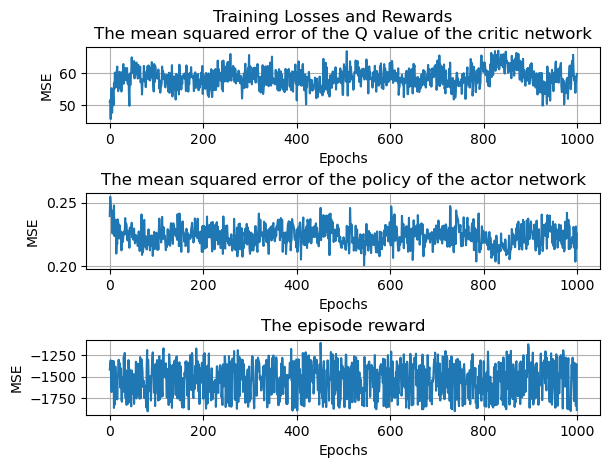

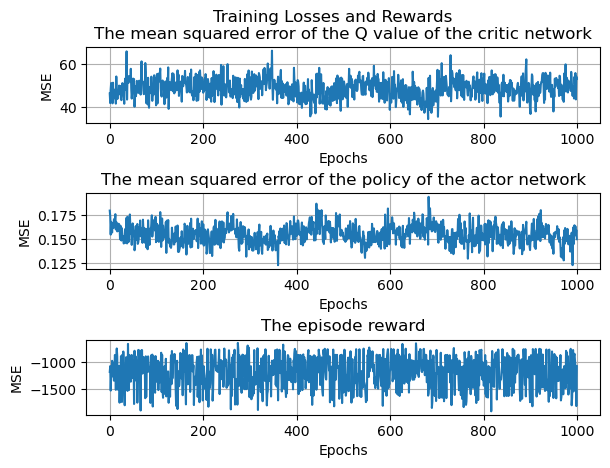

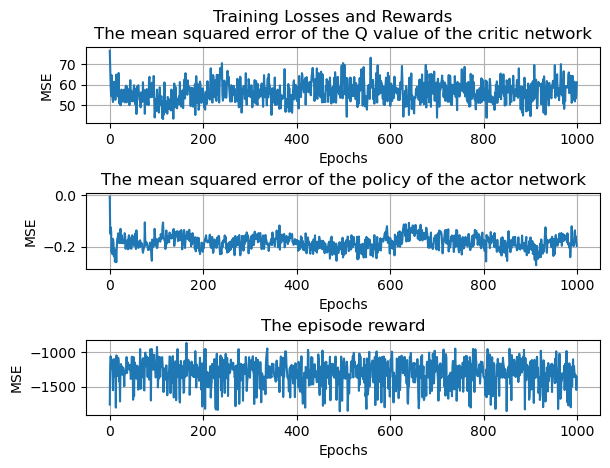

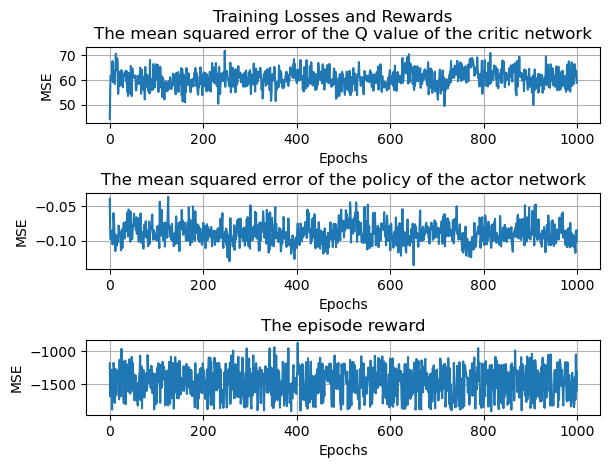

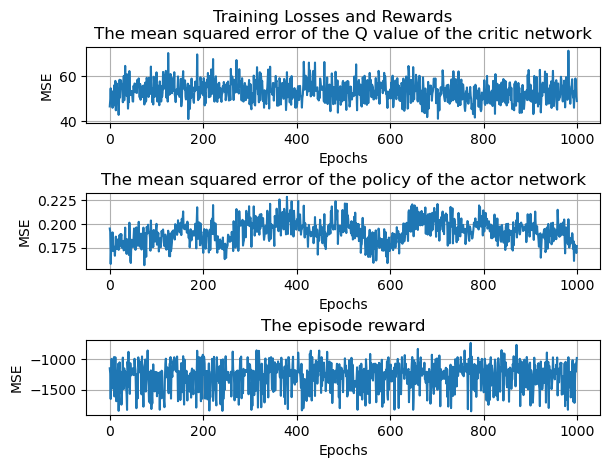

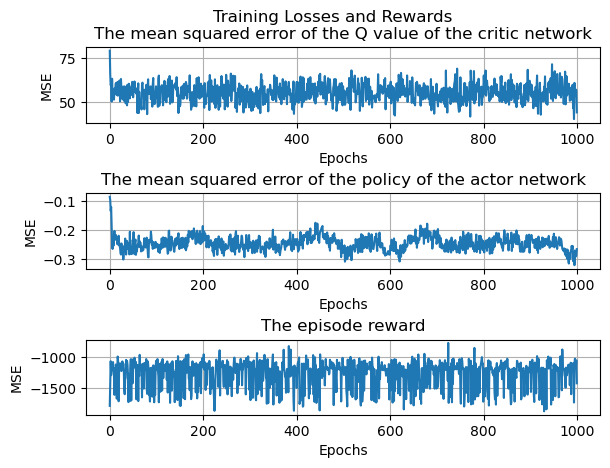

In [246]:
agents = []
cumulative_rewards = []
for i in Tau:
    agent, plot_reward, plot_policy, plot_q = train_network_varying_Tau(Tau = i, noise = gauss_noise, deterministic = False)
    agents.append(agent)
    Plotting(plot_q, plot_policy, plot_reward)
    reward_vector_DDPG_agent = []
    for j in range(100):
        total_reward = run_episode(agent = agent)
        reward_vector_DDPG_agent.append(total_reward)
    cumulative_rewards.append(np.mean(reward_vector_DDPG_agent))
    print(r"The average cumulative reward obtained with ddpg with \Tau = {} agent: {}".format(i, np.mean(reward_vector_DDPG_agent)))


#### 7 Ornstein-Uhlenbeck noise
Implementation of Ornstein-Uhlenbeck noise for the DDPG algorithm: 

In [247]:
class OUActionNoise():
    def __init__(self, std_deviation=1):
        self.std_deviation = std_deviation
        self.noise = 0


    def get_noisy_action(self, action, theta = 0.5):
        
        noise = (1-theta)*self.noise + random.gauss(0, self.std_deviation)
        noisy_action = action + noise
        noisy_action = np.clip(noisy_action, -1., 1.)
        
        #update self.noise to contain most recent noise
        self.evolve_state(noise)
        return noisy_action
    
    def evolve_state(self, noise):
        self.noise = noise

In [11]:
import random
random.randint((1,5),4)


TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

  1%|          | 10/1000 [00:21<36:35,  2.22s/it]

Policy loss:  tensor(-0.1603)
Q loss:  tensor(56.3247)
Episode reward:  -1688.8937468591744


  2%|▏         | 20/1000 [00:43<37:10,  2.28s/it]

Policy loss:  tensor(-0.2028)
Q loss:  tensor(65.8047)
Episode reward:  -997.892869091607


  3%|▎         | 30/1000 [01:06<36:37,  2.27s/it]

Policy loss:  tensor(-0.1903)
Q loss:  tensor(63.2963)
Episode reward:  -1597.574811978391


  4%|▍         | 40/1000 [01:29<36:02,  2.25s/it]

Policy loss:  tensor(-0.1952)
Q loss:  tensor(60.6388)
Episode reward:  -722.7710774973614


  5%|▌         | 50/1000 [01:52<36:52,  2.33s/it]

Policy loss:  tensor(-0.1786)
Q loss:  tensor(62.2314)
Episode reward:  -1490.6327828684723


  6%|▌         | 60/1000 [02:14<35:23,  2.26s/it]

Policy loss:  tensor(-0.1533)
Q loss:  tensor(53.8339)
Episode reward:  -727.6988972887644


  7%|▋         | 70/1000 [02:37<35:06,  2.26s/it]

Policy loss:  tensor(-0.1375)
Q loss:  tensor(54.5882)
Episode reward:  -1357.34279363667


  8%|▊         | 80/1000 [03:00<35:15,  2.30s/it]

Policy loss:  tensor(-0.1577)
Q loss:  tensor(65.4672)
Episode reward:  -1481.4149468709843


  9%|▉         | 90/1000 [03:23<34:51,  2.30s/it]

Policy loss:  tensor(-0.1737)
Q loss:  tensor(64.2665)
Episode reward:  -1531.7793855824125


 10%|█         | 100/1000 [03:46<35:12,  2.35s/it]

Policy loss:  tensor(-0.1638)
Q loss:  tensor(53.8618)
Episode reward:  -828.8551332538688


 11%|█         | 110/1000 [04:09<34:54,  2.35s/it]

Policy loss:  tensor(-0.1797)
Q loss:  tensor(67.4860)
Episode reward:  -1489.1599771693398


 12%|█▏        | 120/1000 [04:32<33:26,  2.28s/it]

Policy loss:  tensor(-0.1897)
Q loss:  tensor(61.1232)
Episode reward:  -1693.3126144185806


 13%|█▎        | 130/1000 [04:55<33:46,  2.33s/it]

Policy loss:  tensor(-0.1828)
Q loss:  tensor(54.3893)
Episode reward:  -1687.1566388761782


 14%|█▍        | 140/1000 [05:18<32:28,  2.27s/it]

Policy loss:  tensor(-0.1952)
Q loss:  tensor(59.7081)
Episode reward:  -1673.5090638336596


 15%|█▌        | 150/1000 [05:42<34:47,  2.46s/it]

Policy loss:  tensor(-0.1877)
Q loss:  tensor(50.9394)
Episode reward:  -1666.4924817728613


 16%|█▌        | 160/1000 [06:05<31:58,  2.28s/it]

Policy loss:  tensor(-0.1975)
Q loss:  tensor(59.8618)
Episode reward:  -1131.9592900722064


 17%|█▋        | 170/1000 [06:28<32:19,  2.34s/it]

Policy loss:  tensor(-0.1876)
Q loss:  tensor(65.2289)
Episode reward:  -1694.6870538621486


 18%|█▊        | 180/1000 [06:51<31:21,  2.29s/it]

Policy loss:  tensor(-0.2244)
Q loss:  tensor(68.3383)
Episode reward:  -1673.1836761616514


 19%|█▉        | 190/1000 [07:14<31:12,  2.31s/it]

Policy loss:  tensor(-0.2373)
Q loss:  tensor(76.2978)
Episode reward:  -1493.81311846635


 20%|██        | 200/1000 [07:37<30:27,  2.28s/it]

Policy loss:  tensor(-0.2403)
Q loss:  tensor(63.7762)
Episode reward:  -1675.523671551708


 21%|██        | 210/1000 [07:59<29:39,  2.25s/it]

Policy loss:  tensor(-0.2460)
Q loss:  tensor(66.8798)
Episode reward:  -1672.3129875256182


 22%|██▏       | 220/1000 [08:22<29:55,  2.30s/it]

Policy loss:  tensor(-0.2068)
Q loss:  tensor(63.9402)
Episode reward:  -1463.4198190400018


 23%|██▎       | 230/1000 [08:45<28:48,  2.24s/it]

Policy loss:  tensor(-0.2168)
Q loss:  tensor(68.1283)
Episode reward:  -1689.4299919276898


 24%|██▍       | 240/1000 [09:09<29:15,  2.31s/it]

Policy loss:  tensor(-0.2137)
Q loss:  tensor(72.6911)
Episode reward:  -1430.2969322909837


 25%|██▌       | 250/1000 [09:31<28:37,  2.29s/it]

Policy loss:  tensor(-0.2191)
Q loss:  tensor(60.7758)
Episode reward:  -1685.4857131500385


 26%|██▌       | 260/1000 [09:55<28:07,  2.28s/it]

Policy loss:  tensor(-0.2158)
Q loss:  tensor(67.9224)
Episode reward:  -1676.2654167885207


 27%|██▋       | 270/1000 [10:18<27:56,  2.30s/it]

Policy loss:  tensor(-0.2321)
Q loss:  tensor(64.7942)
Episode reward:  -1683.298155393422


 28%|██▊       | 280/1000 [10:41<27:57,  2.33s/it]

Policy loss:  tensor(-0.2344)
Q loss:  tensor(68.8011)
Episode reward:  -1033.2984394554285


 29%|██▉       | 290/1000 [11:04<27:31,  2.33s/it]

Policy loss:  tensor(-0.2309)
Q loss:  tensor(67.8218)
Episode reward:  -1390.49799847868


 30%|███       | 300/1000 [11:27<26:56,  2.31s/it]

Policy loss:  tensor(-0.2169)
Q loss:  tensor(66.4366)
Episode reward:  -1503.1029128465598


 31%|███       | 310/1000 [11:51<26:51,  2.34s/it]

Policy loss:  tensor(-0.2088)
Q loss:  tensor(61.5588)
Episode reward:  -846.5745777059225


 32%|███▏      | 320/1000 [12:14<26:39,  2.35s/it]

Policy loss:  tensor(-0.2089)
Q loss:  tensor(71.0589)
Episode reward:  -1644.1203807093864


 33%|███▎      | 330/1000 [12:38<27:01,  2.42s/it]

Policy loss:  tensor(-0.2167)
Q loss:  tensor(66.6724)
Episode reward:  -789.1458082151811


 34%|███▍      | 340/1000 [13:01<25:42,  2.34s/it]

Policy loss:  tensor(-0.2214)
Q loss:  tensor(63.2201)
Episode reward:  -1088.1837190488775


 35%|███▌      | 350/1000 [13:25<25:08,  2.32s/it]

Policy loss:  tensor(-0.2156)
Q loss:  tensor(71.7656)
Episode reward:  -1448.1292846046372


 36%|███▌      | 360/1000 [13:48<25:05,  2.35s/it]

Policy loss:  tensor(-0.2077)
Q loss:  tensor(63.9681)
Episode reward:  -1693.2723799178991


 37%|███▋      | 370/1000 [14:21<43:45,  4.17s/it]

Policy loss:  tensor(-0.2095)
Q loss:  tensor(63.1037)
Episode reward:  -1485.7507574641968


 38%|███▊      | 380/1000 [14:53<35:03,  3.39s/it]

Policy loss:  tensor(-0.1693)
Q loss:  tensor(61.9116)
Episode reward:  -1403.168968118013


 39%|███▉      | 390/1000 [15:23<28:16,  2.78s/it]

Policy loss:  tensor(-0.2136)
Q loss:  tensor(68.4799)
Episode reward:  -1351.8396619739754


 40%|████      | 400/1000 [15:46<19:09,  1.92s/it]

Policy loss:  tensor(-0.1983)
Q loss:  tensor(64.8672)
Episode reward:  -1463.7572286968493


 41%|████      | 410/1000 [16:03<16:25,  1.67s/it]

Policy loss:  tensor(-0.2042)
Q loss:  tensor(53.9767)
Episode reward:  -1168.3022194827897


 42%|████▏     | 420/1000 [16:19<14:56,  1.55s/it]

Policy loss:  tensor(-0.2141)
Q loss:  tensor(67.8849)
Episode reward:  -728.5748773236079


 43%|████▎     | 430/1000 [16:35<14:48,  1.56s/it]

Policy loss:  tensor(-0.2107)
Q loss:  tensor(61.0191)
Episode reward:  -1484.5049586770203


 44%|████▍     | 440/1000 [16:50<14:41,  1.57s/it]

Policy loss:  tensor(-0.1902)
Q loss:  tensor(65.8960)
Episode reward:  -1474.4628493212956


 45%|████▌     | 450/1000 [17:06<14:39,  1.60s/it]

Policy loss:  tensor(-0.1729)
Q loss:  tensor(63.8194)
Episode reward:  -1621.1586694648245


 46%|████▌     | 460/1000 [17:22<14:05,  1.57s/it]

Policy loss:  tensor(-0.1973)
Q loss:  tensor(69.9534)
Episode reward:  -1610.025013093762


 47%|████▋     | 470/1000 [17:38<14:08,  1.60s/it]

Policy loss:  tensor(-0.2168)
Q loss:  tensor(69.7530)
Episode reward:  -1628.629888543902


 48%|████▊     | 480/1000 [17:53<13:26,  1.55s/it]

Policy loss:  tensor(-0.2493)
Q loss:  tensor(65.3785)
Episode reward:  -1691.1454337845346


 49%|████▉     | 490/1000 [18:09<13:23,  1.57s/it]

Policy loss:  tensor(-0.2574)
Q loss:  tensor(75.3934)
Episode reward:  -1108.7093457682513


 50%|█████     | 500/1000 [18:25<13:00,  1.56s/it]

Policy loss:  tensor(-0.2678)
Q loss:  tensor(79.7818)
Episode reward:  -1635.3350671531828


 51%|█████     | 510/1000 [18:41<12:30,  1.53s/it]

Policy loss:  tensor(-0.2460)
Q loss:  tensor(70.5698)
Episode reward:  -1587.9979408190836


 52%|█████▏    | 520/1000 [18:57<12:50,  1.60s/it]

Policy loss:  tensor(-0.2412)
Q loss:  tensor(66.6230)
Episode reward:  -1405.8152095224857


 53%|█████▎    | 530/1000 [19:12<12:26,  1.59s/it]

Policy loss:  tensor(-0.2192)
Q loss:  tensor(58.6119)
Episode reward:  -1673.281943301441


 54%|█████▍    | 540/1000 [19:28<12:15,  1.60s/it]

Policy loss:  tensor(-0.2047)
Q loss:  tensor(66.2680)
Episode reward:  -944.8638998014836


 55%|█████▌    | 550/1000 [19:44<12:09,  1.62s/it]

Policy loss:  tensor(-0.1949)
Q loss:  tensor(54.4988)
Episode reward:  -1485.9951004780016


 56%|█████▌    | 560/1000 [20:00<11:46,  1.60s/it]

Policy loss:  tensor(-0.2089)
Q loss:  tensor(62.3363)
Episode reward:  -1700.2707354942977


 57%|█████▋    | 570/1000 [20:16<11:17,  1.57s/it]

Policy loss:  tensor(-0.2223)
Q loss:  tensor(67.0656)
Episode reward:  -1500.6678044713353


 58%|█████▊    | 580/1000 [20:32<11:25,  1.63s/it]

Policy loss:  tensor(-0.2061)
Q loss:  tensor(60.6801)
Episode reward:  -1165.5914914787056


 59%|█████▉    | 590/1000 [20:48<11:14,  1.64s/it]

Policy loss:  tensor(-0.2249)
Q loss:  tensor(61.7138)
Episode reward:  -1699.0579204280434


 60%|██████    | 600/1000 [21:04<11:14,  1.69s/it]

Policy loss:  tensor(-0.2043)
Q loss:  tensor(68.8290)
Episode reward:  -1454.741740243181


 61%|██████    | 610/1000 [21:20<09:39,  1.49s/it]

Policy loss:  tensor(-0.2412)
Q loss:  tensor(65.4589)
Episode reward:  -1674.113413651814


 62%|██████▏   | 620/1000 [21:35<09:36,  1.52s/it]

Policy loss:  tensor(-0.2379)
Q loss:  tensor(61.8619)
Episode reward:  -1486.1437900115313


 63%|██████▎   | 630/1000 [21:51<09:14,  1.50s/it]

Policy loss:  tensor(-0.1937)
Q loss:  tensor(57.5852)
Episode reward:  -1694.6999180697183


 64%|██████▍   | 640/1000 [22:06<09:10,  1.53s/it]

Policy loss:  tensor(-0.2142)
Q loss:  tensor(56.7601)
Episode reward:  -1683.7694461975575


 65%|██████▌   | 650/1000 [22:21<09:01,  1.55s/it]

Policy loss:  tensor(-0.2194)
Q loss:  tensor(68.3217)
Episode reward:  -1621.99788270966


 66%|██████▌   | 660/1000 [22:37<09:00,  1.59s/it]

Policy loss:  tensor(-0.2255)
Q loss:  tensor(65.5815)
Episode reward:  -1062.8125315050577


 67%|██████▋   | 670/1000 [22:54<08:41,  1.58s/it]

Policy loss:  tensor(-0.2061)
Q loss:  tensor(59.2674)
Episode reward:  -1049.2030457896417


 68%|██████▊   | 680/1000 [23:09<08:17,  1.55s/it]

Policy loss:  tensor(-0.2515)
Q loss:  tensor(63.4430)
Episode reward:  -1503.366743690768


 69%|██████▉   | 690/1000 [23:25<08:03,  1.56s/it]

Policy loss:  tensor(-0.2248)
Q loss:  tensor(61.3620)
Episode reward:  -1483.481609327465


 70%|███████   | 700/1000 [23:40<07:22,  1.48s/it]

Policy loss:  tensor(-0.2572)
Q loss:  tensor(61.9797)
Episode reward:  -1341.2239574332395


 71%|███████   | 710/1000 [23:55<07:13,  1.49s/it]

Policy loss:  tensor(-0.2486)
Q loss:  tensor(68.6578)
Episode reward:  -1215.8381330765596


 72%|███████▏  | 720/1000 [24:11<07:01,  1.50s/it]

Policy loss:  tensor(-0.2543)
Q loss:  tensor(63.3758)
Episode reward:  -1199.9747763162302


 73%|███████▎  | 730/1000 [24:26<06:41,  1.49s/it]

Policy loss:  tensor(-0.2501)
Q loss:  tensor(76.5659)
Episode reward:  -1243.7996536053622


 74%|███████▍  | 740/1000 [24:41<06:37,  1.53s/it]

Policy loss:  tensor(-0.2569)
Q loss:  tensor(60.3858)
Episode reward:  -984.5983124768625


 75%|███████▌  | 750/1000 [24:56<06:14,  1.50s/it]

Policy loss:  tensor(-0.2333)
Q loss:  tensor(57.6475)
Episode reward:  -1340.4300028276582


 76%|███████▌  | 760/1000 [25:12<05:58,  1.49s/it]

Policy loss:  tensor(-0.2342)
Q loss:  tensor(64.5008)
Episode reward:  -1640.0814588028013


 77%|███████▋  | 770/1000 [25:27<05:35,  1.46s/it]

Policy loss:  tensor(-0.2193)
Q loss:  tensor(65.3659)
Episode reward:  -1588.9363720024048


 78%|███████▊  | 780/1000 [25:42<05:41,  1.55s/it]

Policy loss:  tensor(-0.2247)
Q loss:  tensor(65.0287)
Episode reward:  -1625.1994769072012


 79%|███████▉  | 790/1000 [25:58<05:34,  1.59s/it]

Policy loss:  tensor(-0.2274)
Q loss:  tensor(62.3979)
Episode reward:  -1483.654177946638


 80%|████████  | 800/1000 [26:13<04:55,  1.48s/it]

Policy loss:  tensor(-0.2380)
Q loss:  tensor(66.1922)
Episode reward:  -1479.3743044328219


 81%|████████  | 810/1000 [26:29<05:05,  1.61s/it]

Policy loss:  tensor(-0.2229)
Q loss:  tensor(75.3550)
Episode reward:  -741.3439082532615


 82%|████████▏ | 820/1000 [26:44<04:40,  1.56s/it]

Policy loss:  tensor(-0.1976)
Q loss:  tensor(64.5656)
Episode reward:  -1653.6737490621724


 83%|████████▎ | 830/1000 [26:59<04:19,  1.53s/it]

Policy loss:  tensor(-0.2077)
Q loss:  tensor(60.9852)
Episode reward:  -957.0723901964701


 84%|████████▍ | 840/1000 [27:15<04:18,  1.62s/it]

Policy loss:  tensor(-0.2126)
Q loss:  tensor(63.1489)
Episode reward:  -1691.9285139818783


 85%|████████▌ | 850/1000 [27:31<04:00,  1.60s/it]

Policy loss:  tensor(-0.2193)
Q loss:  tensor(65.9942)
Episode reward:  -1686.359415469363


 86%|████████▌ | 860/1000 [27:47<03:32,  1.52s/it]

Policy loss:  tensor(-0.1981)
Q loss:  tensor(57.6326)
Episode reward:  -1023.322248824228


 87%|████████▋ | 870/1000 [28:03<03:53,  1.80s/it]

Policy loss:  tensor(-0.1932)
Q loss:  tensor(58.5798)
Episode reward:  -1679.5421124461127


 88%|████████▊ | 880/1000 [28:19<02:58,  1.49s/it]

Policy loss:  tensor(-0.2218)
Q loss:  tensor(61.0987)
Episode reward:  -1685.420195910568


 89%|████████▉ | 890/1000 [28:34<02:49,  1.54s/it]

Policy loss:  tensor(-0.2110)
Q loss:  tensor(65.0993)
Episode reward:  -951.5962980300026


 90%|█████████ | 900/1000 [28:49<02:35,  1.55s/it]

Policy loss:  tensor(-0.2167)
Q loss:  tensor(66.6355)
Episode reward:  -1442.3964269971048


 91%|█████████ | 910/1000 [29:05<02:18,  1.54s/it]

Policy loss:  tensor(-0.2094)
Q loss:  tensor(56.7070)
Episode reward:  -1422.9165134231225


 92%|█████████▏| 920/1000 [29:20<02:04,  1.56s/it]

Policy loss:  tensor(-0.1884)
Q loss:  tensor(53.9105)
Episode reward:  -1066.176935292362


 93%|█████████▎| 930/1000 [29:35<01:45,  1.51s/it]

Policy loss:  tensor(-0.1937)
Q loss:  tensor(67.9565)
Episode reward:  -1670.432134645069


 94%|█████████▍| 940/1000 [29:50<01:34,  1.57s/it]

Policy loss:  tensor(-0.2016)
Q loss:  tensor(67.8974)
Episode reward:  -1537.6619622825274


 95%|█████████▌| 950/1000 [30:05<01:14,  1.49s/it]

Policy loss:  tensor(-0.2455)
Q loss:  tensor(64.4639)
Episode reward:  -1684.8739245508193


 96%|█████████▌| 960/1000 [30:20<01:00,  1.50s/it]

Policy loss:  tensor(-0.2442)
Q loss:  tensor(72.9863)
Episode reward:  -1603.2642201522322


 97%|█████████▋| 970/1000 [30:35<00:44,  1.48s/it]

Policy loss:  tensor(-0.2646)
Q loss:  tensor(66.4057)
Episode reward:  -1226.9725633645558


 98%|█████████▊| 980/1000 [30:50<00:30,  1.50s/it]

Policy loss:  tensor(-0.2456)
Q loss:  tensor(75.0732)
Episode reward:  -1490.2537239767914


 99%|█████████▉| 990/1000 [31:05<00:15,  1.59s/it]

Policy loss:  tensor(-0.2547)
Q loss:  tensor(77.0631)
Episode reward:  -1635.9301097070634


100%|██████████| 1000/1000 [31:20<00:00,  1.88s/it]

Policy loss:  tensor(-0.2448)
Q loss:  tensor(72.7077)
Episode reward:  -1358.4817672792606


The average cumulative reward obtained with ddpg with \Tau = 0.1 agent: -1456.753630337058


  1%|          | 10/1000 [00:13<24:11,  1.47s/it]

Policy loss:  tensor(0.2043)
Q loss:  tensor(56.4830)
Episode reward:  -1385.8506542647401


  2%|▏         | 20/1000 [00:28<24:08,  1.48s/it]

Policy loss:  tensor(0.2491)
Q loss:  tensor(63.1219)
Episode reward:  -1460.790497562453


  3%|▎         | 30/1000 [00:44<24:39,  1.53s/it]

Policy loss:  tensor(0.2261)
Q loss:  tensor(54.5243)
Episode reward:  -1292.4786381978402


  4%|▍         | 40/1000 [00:59<23:46,  1.49s/it]

Policy loss:  tensor(0.2199)
Q loss:  tensor(54.5215)
Episode reward:  -1377.895767391411


  5%|▌         | 50/1000 [01:14<24:51,  1.57s/it]

Policy loss:  tensor(0.2147)
Q loss:  tensor(60.1044)
Episode reward:  -1002.7948965994349


  6%|▌         | 60/1000 [01:29<24:06,  1.54s/it]

Policy loss:  tensor(0.2232)
Q loss:  tensor(51.0972)
Episode reward:  -1317.5126259395695


  7%|▋         | 70/1000 [01:44<22:53,  1.48s/it]

Policy loss:  tensor(0.2007)
Q loss:  tensor(49.0809)
Episode reward:  -1288.9763274674192


  8%|▊         | 80/1000 [01:59<23:15,  1.52s/it]

Policy loss:  tensor(0.2291)
Q loss:  tensor(54.9911)
Episode reward:  -1188.0913300552213


  9%|▉         | 90/1000 [02:14<22:22,  1.48s/it]

Policy loss:  tensor(0.2269)
Q loss:  tensor(55.8054)
Episode reward:  -1274.4006062113235


 10%|█         | 100/1000 [02:29<23:05,  1.54s/it]

Policy loss:  tensor(0.2293)
Q loss:  tensor(56.8291)
Episode reward:  -1085.827101049581


 11%|█         | 110/1000 [02:44<22:07,  1.49s/it]

Policy loss:  tensor(0.2213)
Q loss:  tensor(56.3619)
Episode reward:  -1297.7978836753725


 12%|█▏        | 120/1000 [03:01<26:32,  1.81s/it]

Policy loss:  tensor(0.2043)
Q loss:  tensor(58.5548)
Episode reward:  -1220.3340287610456


 13%|█▎        | 130/1000 [03:16<21:17,  1.47s/it]

Policy loss:  tensor(0.2155)
Q loss:  tensor(55.5048)
Episode reward:  -1405.6371248260616


 14%|█▍        | 140/1000 [03:52<45:44,  3.19s/it]  

Policy loss:  tensor(0.2518)
Q loss:  tensor(61.7969)
Episode reward:  -1320.6823932984958


 15%|█▌        | 150/1000 [04:12<28:19,  2.00s/it]

Policy loss:  tensor(0.2242)
Q loss:  tensor(57.7086)
Episode reward:  -1490.2626262474885


 16%|█▌        | 160/1000 [04:31<27:42,  1.98s/it]

Policy loss:  tensor(0.2419)
Q loss:  tensor(65.9352)
Episode reward:  -1264.551789981569


 17%|█▋        | 170/1000 [04:51<28:01,  2.03s/it]

Policy loss:  tensor(0.2345)
Q loss:  tensor(57.9326)
Episode reward:  -1207.090022121974


 18%|█▊        | 180/1000 [05:21<45:07,  3.30s/it]

Policy loss:  tensor(0.2002)
Q loss:  tensor(50.9408)
Episode reward:  -1100.5351742775576


 19%|█▉        | 190/1000 [05:46<29:42,  2.20s/it]

Policy loss:  tensor(0.2016)
Q loss:  tensor(48.0740)
Episode reward:  -1295.6077218623946


 20%|██        | 200/1000 [06:07<27:59,  2.10s/it]

Policy loss:  tensor(0.2270)
Q loss:  tensor(57.0833)
Episode reward:  -1247.3249979190387


 21%|██        | 210/1000 [06:29<27:24,  2.08s/it]

Policy loss:  tensor(0.2328)
Q loss:  tensor(58.4119)
Episode reward:  -1255.8440085044995


 22%|██▏       | 220/1000 [06:54<36:56,  2.84s/it]

Policy loss:  tensor(0.2121)
Q loss:  tensor(49.5134)
Episode reward:  -1229.8858785438924


 23%|██▎       | 230/1000 [07:22<41:30,  3.23s/it]

Policy loss:  tensor(0.2201)
Q loss:  tensor(52.3185)
Episode reward:  -1109.6642865485103


 24%|██▍       | 240/1000 [07:50<38:50,  3.07s/it]

Policy loss:  tensor(0.2347)
Q loss:  tensor(57.4482)
Episode reward:  -1130.0243064664214


 25%|██▌       | 250/1000 [08:15<31:08,  2.49s/it]

Policy loss:  tensor(0.2145)
Q loss:  tensor(61.3248)
Episode reward:  -1286.6403056312588


 26%|██▌       | 260/1000 [08:39<29:34,  2.40s/it]

Policy loss:  tensor(0.2290)
Q loss:  tensor(52.9184)
Episode reward:  -1446.351001193712


 27%|██▋       | 270/1000 [09:03<27:57,  2.30s/it]

Policy loss:  tensor(0.2194)
Q loss:  tensor(53.9514)
Episode reward:  -1409.4100418816702


 28%|██▊       | 280/1000 [09:28<31:02,  2.59s/it]

Policy loss:  tensor(0.2221)
Q loss:  tensor(54.9664)
Episode reward:  -1390.4868122626644


 29%|██▉       | 290/1000 [09:53<27:37,  2.33s/it]

Policy loss:  tensor(0.2121)
Q loss:  tensor(51.8304)
Episode reward:  -1018.6717682856495


 30%|███       | 300/1000 [10:16<27:38,  2.37s/it]

Policy loss:  tensor(0.2153)
Q loss:  tensor(56.6992)
Episode reward:  -1422.7939691474169


 31%|███       | 310/1000 [10:40<27:20,  2.38s/it]

Policy loss:  tensor(0.2324)
Q loss:  tensor(64.4249)
Episode reward:  -1217.4758587893102


 32%|███▏      | 320/1000 [11:03<25:51,  2.28s/it]

Policy loss:  tensor(0.2504)
Q loss:  tensor(62.4303)
Episode reward:  -1149.0083661536444


 33%|███▎      | 330/1000 [11:26<26:26,  2.37s/it]

Policy loss:  tensor(0.2159)
Q loss:  tensor(57.9196)
Episode reward:  -1285.9774053926724


 34%|███▍      | 340/1000 [11:49<24:35,  2.23s/it]

Policy loss:  tensor(0.2352)
Q loss:  tensor(61.6761)
Episode reward:  -1270.6392435653415


 35%|███▌      | 350/1000 [12:12<25:26,  2.35s/it]

Policy loss:  tensor(0.2172)
Q loss:  tensor(46.6414)
Episode reward:  -1148.2974929239415


 36%|███▌      | 360/1000 [12:37<25:15,  2.37s/it]

Policy loss:  tensor(0.2183)
Q loss:  tensor(60.6077)
Episode reward:  -1310.752276370133


 37%|███▋      | 370/1000 [12:59<23:32,  2.24s/it]

Policy loss:  tensor(0.2142)
Q loss:  tensor(54.3433)
Episode reward:  -1338.8462690137499


 38%|███▊      | 380/1000 [13:23<25:02,  2.42s/it]

Policy loss:  tensor(0.2352)
Q loss:  tensor(62.3124)
Episode reward:  -1140.0069250027568


 39%|███▉      | 390/1000 [13:48<24:14,  2.38s/it]

Policy loss:  tensor(0.2002)
Q loss:  tensor(52.2522)
Episode reward:  -1307.103691774682


 40%|████      | 400/1000 [14:11<23:16,  2.33s/it]

Policy loss:  tensor(0.2076)
Q loss:  tensor(56.0316)
Episode reward:  -1204.4130789577637


 41%|████      | 410/1000 [14:35<23:01,  2.34s/it]

Policy loss:  tensor(0.2293)
Q loss:  tensor(55.3214)
Episode reward:  -1226.456932439165


 42%|████▏     | 420/1000 [14:59<22:59,  2.38s/it]

Policy loss:  tensor(0.2079)
Q loss:  tensor(45.1414)
Episode reward:  -1016.2546601839409


 43%|████▎     | 430/1000 [15:22<21:27,  2.26s/it]

Policy loss:  tensor(0.2066)
Q loss:  tensor(52.2269)
Episode reward:  -1543.241438463249


 44%|████▍     | 440/1000 [15:45<22:08,  2.37s/it]

Policy loss:  tensor(0.2207)
Q loss:  tensor(66.8297)
Episode reward:  -1227.1821595063557


 45%|████▌     | 450/1000 [16:08<21:04,  2.30s/it]

Policy loss:  tensor(0.2172)
Q loss:  tensor(56.5449)
Episode reward:  -1319.640550266762


 46%|████▌     | 460/1000 [16:31<21:01,  2.34s/it]

Policy loss:  tensor(0.2419)
Q loss:  tensor(61.1749)
Episode reward:  -1176.5468727685486


 47%|████▋     | 470/1000 [16:54<20:02,  2.27s/it]

Policy loss:  tensor(0.2132)
Q loss:  tensor(48.9348)
Episode reward:  -1356.7949363695798


 48%|████▊     | 480/1000 [17:18<21:27,  2.48s/it]

Policy loss:  tensor(0.2303)
Q loss:  tensor(57.2759)
Episode reward:  -1378.074244556233


 49%|████▉     | 490/1000 [17:44<21:38,  2.55s/it]

Policy loss:  tensor(0.2465)
Q loss:  tensor(59.3026)
Episode reward:  -1367.4644521476666


 50%|█████     | 500/1000 [18:08<19:44,  2.37s/it]

Policy loss:  tensor(0.2490)
Q loss:  tensor(71.3592)
Episode reward:  -890.4165098964611


 51%|█████     | 510/1000 [18:32<19:53,  2.44s/it]

Policy loss:  tensor(0.2126)
Q loss:  tensor(52.1608)
Episode reward:  -1505.9831654687557


 52%|█████▏    | 520/1000 [18:56<18:57,  2.37s/it]

Policy loss:  tensor(0.1989)
Q loss:  tensor(52.3901)
Episode reward:  -1334.402880998581


 53%|█████▎    | 530/1000 [19:19<17:52,  2.28s/it]

Policy loss:  tensor(0.2238)
Q loss:  tensor(58.0214)
Episode reward:  -1141.3364243081357


 54%|█████▍    | 540/1000 [19:43<18:00,  2.35s/it]

Policy loss:  tensor(0.2183)
Q loss:  tensor(55.8222)
Episode reward:  -1570.339413891645


 55%|█████▌    | 550/1000 [20:06<16:58,  2.26s/it]

Policy loss:  tensor(0.2138)
Q loss:  tensor(61.5625)
Episode reward:  -1508.832032182085


 56%|█████▌    | 560/1000 [20:29<17:29,  2.39s/it]

Policy loss:  tensor(0.1874)
Q loss:  tensor(48.2513)
Episode reward:  -1279.141971937057


 57%|█████▋    | 570/1000 [20:55<20:04,  2.80s/it]

Policy loss:  tensor(0.1911)
Q loss:  tensor(47.3219)
Episode reward:  -1313.2230488500406


 58%|█████▊    | 580/1000 [21:19<17:08,  2.45s/it]

Policy loss:  tensor(0.2030)
Q loss:  tensor(59.3859)
Episode reward:  -1247.6094290795736


 59%|█████▉    | 590/1000 [21:42<15:26,  2.26s/it]

Policy loss:  tensor(0.2311)
Q loss:  tensor(62.1132)
Episode reward:  -1133.365681255303


 60%|██████    | 600/1000 [22:05<15:30,  2.33s/it]

Policy loss:  tensor(0.2111)
Q loss:  tensor(49.5301)
Episode reward:  -1159.1908167045324


 61%|██████    | 610/1000 [22:28<14:35,  2.25s/it]

Policy loss:  tensor(0.2277)
Q loss:  tensor(51.0829)
Episode reward:  -1320.4573194101895


 62%|██████▏   | 620/1000 [22:51<14:26,  2.28s/it]

Policy loss:  tensor(0.2348)
Q loss:  tensor(60.3149)
Episode reward:  -1130.6567279207434


 63%|██████▎   | 630/1000 [23:13<13:44,  2.23s/it]

Policy loss:  tensor(0.2418)
Q loss:  tensor(59.3566)
Episode reward:  -1303.5783744742826


 64%|██████▍   | 640/1000 [23:36<13:38,  2.27s/it]

Policy loss:  tensor(0.2155)
Q loss:  tensor(53.5964)
Episode reward:  -1248.5428901700773


 65%|██████▌   | 650/1000 [24:00<14:03,  2.41s/it]

Policy loss:  tensor(0.2163)
Q loss:  tensor(61.8025)
Episode reward:  -1292.422208755719


 66%|██████▌   | 660/1000 [24:24<14:21,  2.54s/it]

Policy loss:  tensor(0.2452)
Q loss:  tensor(55.2972)
Episode reward:  -1228.1916218997872


 67%|██████▋   | 670/1000 [25:02<20:30,  3.73s/it]

Policy loss:  tensor(0.2262)
Q loss:  tensor(55.6711)
Episode reward:  -1379.6303021719616


 68%|██████▊   | 680/1000 [25:25<12:30,  2.35s/it]

Policy loss:  tensor(0.2077)
Q loss:  tensor(47.8207)
Episode reward:  -1217.8027908533556


 69%|██████▉   | 690/1000 [25:48<12:20,  2.39s/it]

Policy loss:  tensor(0.2149)
Q loss:  tensor(59.1372)
Episode reward:  -1169.3620092492174


 70%|███████   | 700/1000 [26:12<11:27,  2.29s/it]

Policy loss:  tensor(0.2263)
Q loss:  tensor(53.6686)
Episode reward:  -1425.9591110576025


 71%|███████   | 710/1000 [26:34<11:05,  2.29s/it]

Policy loss:  tensor(0.2125)
Q loss:  tensor(49.6559)
Episode reward:  -1196.6576348947503


 72%|███████▏  | 720/1000 [26:58<11:48,  2.53s/it]

Policy loss:  tensor(0.2110)
Q loss:  tensor(51.4000)
Episode reward:  -1220.2683354965698


 73%|███████▎  | 730/1000 [27:21<10:08,  2.25s/it]

Policy loss:  tensor(0.2204)
Q loss:  tensor(60.5519)
Episode reward:  -1158.8068560660922


 74%|███████▍  | 740/1000 [27:44<09:59,  2.31s/it]

Policy loss:  tensor(0.2475)
Q loss:  tensor(64.9216)
Episode reward:  -1324.775896851238


 75%|███████▌  | 750/1000 [28:07<09:28,  2.28s/it]

Policy loss:  tensor(0.2135)
Q loss:  tensor(48.9497)
Episode reward:  -1203.13765151994


 76%|███████▌  | 760/1000 [28:29<08:55,  2.23s/it]

Policy loss:  tensor(0.2163)
Q loss:  tensor(48.9336)
Episode reward:  -1158.6554540208044


 77%|███████▋  | 770/1000 [28:52<08:34,  2.24s/it]

Policy loss:  tensor(0.2287)
Q loss:  tensor(59.5250)
Episode reward:  -1483.2338278907148


 78%|███████▊  | 780/1000 [29:15<08:17,  2.26s/it]

Policy loss:  tensor(0.2349)
Q loss:  tensor(56.8727)
Episode reward:  -1177.1798459453607


 79%|███████▉  | 790/1000 [29:38<08:22,  2.39s/it]

Policy loss:  tensor(0.2233)
Q loss:  tensor(52.1256)
Episode reward:  -1487.459492611948


 80%|████████  | 800/1000 [30:02<07:45,  2.33s/it]

Policy loss:  tensor(0.2454)
Q loss:  tensor(64.8773)
Episode reward:  -1307.7757820060838


 81%|████████  | 810/1000 [30:25<07:20,  2.32s/it]

Policy loss:  tensor(0.2508)
Q loss:  tensor(64.8142)
Episode reward:  -1271.4044910430675


 82%|████████▏ | 820/1000 [30:49<06:49,  2.27s/it]

Policy loss:  tensor(0.2416)
Q loss:  tensor(58.9717)
Episode reward:  -1337.5588672170363


 83%|████████▎ | 830/1000 [31:11<06:23,  2.26s/it]

Policy loss:  tensor(0.2147)
Q loss:  tensor(50.7861)
Episode reward:  -1248.5981481522313


 84%|████████▍ | 840/1000 [31:34<05:55,  2.22s/it]

Policy loss:  tensor(0.2083)
Q loss:  tensor(57.9251)
Episode reward:  -1246.7176622106115


 85%|████████▌ | 850/1000 [31:56<05:35,  2.24s/it]

Policy loss:  tensor(0.2083)
Q loss:  tensor(48.5954)
Episode reward:  -1021.3087059113183


 86%|████████▌ | 860/1000 [32:19<05:18,  2.27s/it]

Policy loss:  tensor(0.2295)
Q loss:  tensor(64.1195)
Episode reward:  -1218.5684769479954


 87%|████████▋ | 870/1000 [32:41<05:00,  2.31s/it]

Policy loss:  tensor(0.2202)
Q loss:  tensor(54.3035)
Episode reward:  -1198.342101008185


 88%|████████▊ | 880/1000 [33:04<04:34,  2.28s/it]

Policy loss:  tensor(0.2214)
Q loss:  tensor(62.2231)
Episode reward:  -1344.286421307901


 89%|████████▉ | 890/1000 [33:27<04:08,  2.26s/it]

Policy loss:  tensor(0.2230)
Q loss:  tensor(66.5961)
Episode reward:  -1328.7167598438048


 90%|█████████ | 900/1000 [33:50<03:52,  2.32s/it]

Policy loss:  tensor(0.2223)
Q loss:  tensor(55.8438)
Episode reward:  -1327.5654049643588


 91%|█████████ | 910/1000 [34:13<03:25,  2.28s/it]

Policy loss:  tensor(0.2115)
Q loss:  tensor(47.9864)
Episode reward:  -1278.9564166309437


 92%|█████████▏| 920/1000 [34:36<03:00,  2.25s/it]

Policy loss:  tensor(0.2210)
Q loss:  tensor(50.8670)
Episode reward:  -1119.7449801141825


 93%|█████████▎| 930/1000 [34:59<02:40,  2.29s/it]

Policy loss:  tensor(0.2365)
Q loss:  tensor(61.4857)
Episode reward:  -1301.4621716199376


 94%|█████████▍| 940/1000 [35:22<02:18,  2.31s/it]

Policy loss:  tensor(0.2165)
Q loss:  tensor(52.6811)
Episode reward:  -1089.4956887904489


 95%|█████████▌| 950/1000 [35:44<01:54,  2.29s/it]

Policy loss:  tensor(0.2442)
Q loss:  tensor(60.3839)
Episode reward:  -1063.767781978364


 96%|█████████▌| 960/1000 [36:07<01:30,  2.25s/it]

Policy loss:  tensor(0.2173)
Q loss:  tensor(49.3267)
Episode reward:  -1269.729471924158


 97%|█████████▋| 970/1000 [36:30<01:08,  2.30s/it]

Policy loss:  tensor(0.2243)
Q loss:  tensor(51.9031)
Episode reward:  -1259.0893523845095


 98%|█████████▊| 980/1000 [36:54<00:47,  2.35s/it]

Policy loss:  tensor(0.2352)
Q loss:  tensor(60.6306)
Episode reward:  -944.9516296756449


 99%|█████████▉| 990/1000 [37:17<00:23,  2.30s/it]

Policy loss:  tensor(0.2165)
Q loss:  tensor(48.6096)
Episode reward:  -1176.3322706807855


100%|██████████| 1000/1000 [37:41<00:00,  2.26s/it]

Policy loss:  tensor(0.2168)
Q loss:  tensor(53.7511)
Episode reward:  -1338.388487472308


The average cumulative reward obtained with ddpg with \Tau = 0.1 agent: -1350.8148477917257


  1%|          | 10/1000 [00:21<37:15,  2.26s/it]

Policy loss:  tensor(-0.0506)
Q loss:  tensor(53.6472)
Episode reward:  -1400.1788475683247


  2%|▏         | 20/1000 [00:44<37:52,  2.32s/it]

Policy loss:  tensor(-0.0291)
Q loss:  tensor(52.0752)
Episode reward:  -1360.6814428442815


  3%|▎         | 30/1000 [01:07<37:11,  2.30s/it]

Policy loss:  tensor(-0.0538)
Q loss:  tensor(53.1393)
Episode reward:  -1683.7422433484305


  4%|▍         | 40/1000 [01:30<36:59,  2.31s/it]

Policy loss:  tensor(-0.0622)
Q loss:  tensor(55.1308)
Episode reward:  -1578.9478263575654


  5%|▌         | 50/1000 [01:53<35:56,  2.27s/it]

Policy loss:  tensor(-0.0676)
Q loss:  tensor(56.4177)
Episode reward:  -1502.8111979833134


  6%|▌         | 60/1000 [02:16<35:43,  2.28s/it]

Policy loss:  tensor(-0.0493)
Q loss:  tensor(61.8542)
Episode reward:  -966.3468379378048


  7%|▋         | 70/1000 [02:40<35:45,  2.31s/it]

Policy loss:  tensor(-0.0712)
Q loss:  tensor(55.4187)
Episode reward:  -951.6911733196422


  8%|▊         | 80/1000 [03:03<34:50,  2.27s/it]

Policy loss:  tensor(-0.0506)
Q loss:  tensor(46.9120)
Episode reward:  -1022.3270190170595


  9%|▉         | 90/1000 [03:26<34:18,  2.26s/it]

Policy loss:  tensor(-0.0611)
Q loss:  tensor(46.0897)
Episode reward:  -1192.6445275198969


 10%|█         | 100/1000 [03:48<33:29,  2.23s/it]

Policy loss:  tensor(-0.0533)
Q loss:  tensor(47.3429)
Episode reward:  -1169.2444535805878


 11%|█         | 110/1000 [04:11<33:47,  2.28s/it]

Policy loss:  tensor(-0.0370)
Q loss:  tensor(45.0377)
Episode reward:  -1384.0179435037173


 12%|█▏        | 120/1000 [04:34<34:53,  2.38s/it]

Policy loss:  tensor(-0.0198)
Q loss:  tensor(61.9629)
Episode reward:  -1051.9937395708307


 13%|█▎        | 130/1000 [04:58<33:52,  2.34s/it]

Policy loss:  tensor(-0.0492)
Q loss:  tensor(60.1204)
Episode reward:  -1600.89457947997


 14%|█▍        | 140/1000 [05:20<31:53,  2.23s/it]

Policy loss:  tensor(-0.0283)
Q loss:  tensor(54.3540)
Episode reward:  -1668.8602545484825


 15%|█▌        | 150/1000 [05:43<32:51,  2.32s/it]

Policy loss:  tensor(-0.0266)
Q loss:  tensor(52.7154)
Episode reward:  -1513.4505970805264


 16%|█▌        | 160/1000 [06:07<32:52,  2.35s/it]

Policy loss:  tensor(-0.0364)
Q loss:  tensor(52.8391)
Episode reward:  -1134.3827471412214


 17%|█▋        | 170/1000 [06:30<32:11,  2.33s/it]

Policy loss:  tensor(-0.0466)
Q loss:  tensor(55.7923)
Episode reward:  -1702.178816278931


 18%|█▊        | 180/1000 [06:54<32:25,  2.37s/it]

Policy loss:  tensor(-0.0365)
Q loss:  tensor(58.4850)
Episode reward:  -1143.7037271715492


 19%|█▉        | 190/1000 [07:17<31:08,  2.31s/it]

Policy loss:  tensor(-0.0300)
Q loss:  tensor(56.8517)
Episode reward:  -1689.7081795528504


 20%|██        | 200/1000 [07:40<30:37,  2.30s/it]

Policy loss:  tensor(-0.0678)
Q loss:  tensor(51.7982)
Episode reward:  -1035.7878870841691


 21%|██        | 210/1000 [08:03<30:51,  2.34s/it]

Policy loss:  tensor(-0.0479)
Q loss:  tensor(59.1967)
Episode reward:  -1217.4912515421709


 22%|██▏       | 220/1000 [08:26<29:57,  2.30s/it]

Policy loss:  tensor(-0.0425)
Q loss:  tensor(51.9289)
Episode reward:  -1537.6415856270273


 23%|██▎       | 230/1000 [08:50<30:43,  2.39s/it]

Policy loss:  tensor(-0.0452)
Q loss:  tensor(55.5921)
Episode reward:  -1098.6949316630366


 24%|██▍       | 240/1000 [09:13<29:07,  2.30s/it]

Policy loss:  tensor(-0.0602)
Q loss:  tensor(45.8803)
Episode reward:  -1259.7826633469697


 25%|██▌       | 250/1000 [09:36<28:13,  2.26s/it]

Policy loss:  tensor(-0.0482)
Q loss:  tensor(48.7405)
Episode reward:  -1297.0160828635314


 26%|██▌       | 260/1000 [09:59<27:57,  2.27s/it]

Policy loss:  tensor(-0.0594)
Q loss:  tensor(54.9342)
Episode reward:  -1064.976702011983


 27%|██▋       | 270/1000 [10:22<27:48,  2.29s/it]

Policy loss:  tensor(-0.0335)
Q loss:  tensor(49.7855)
Episode reward:  -1200.5011242161436


 28%|██▊       | 280/1000 [10:45<27:26,  2.29s/it]

Policy loss:  tensor(-0.0419)
Q loss:  tensor(50.1787)
Episode reward:  -1498.682224185559


 29%|██▉       | 290/1000 [11:08<27:01,  2.28s/it]

Policy loss:  tensor(-0.0508)
Q loss:  tensor(54.1703)
Episode reward:  -1174.7607978928168


 30%|███       | 300/1000 [11:32<26:59,  2.31s/it]

Policy loss:  tensor(-0.0232)
Q loss:  tensor(55.4053)
Episode reward:  -1125.8219621947555


 31%|███       | 310/1000 [11:55<26:36,  2.31s/it]

Policy loss:  tensor(-0.0383)
Q loss:  tensor(47.0322)
Episode reward:  -1070.6860843589916


 32%|███▏      | 320/1000 [12:18<26:10,  2.31s/it]

Policy loss:  tensor(-0.0492)
Q loss:  tensor(44.9948)
Episode reward:  -1092.9460378995404


 33%|███▎      | 330/1000 [12:42<26:31,  2.37s/it]

Policy loss:  tensor(-0.0415)
Q loss:  tensor(47.4456)
Episode reward:  -1139.0998029194016


 34%|███▍      | 340/1000 [13:06<25:12,  2.29s/it]

Policy loss:  tensor(-0.0564)
Q loss:  tensor(44.8408)
Episode reward:  -1378.9343871634378


 35%|███▌      | 350/1000 [13:29<25:06,  2.32s/it]

Policy loss:  tensor(-0.0382)
Q loss:  tensor(44.7787)
Episode reward:  -1446.727499840819


 36%|███▌      | 360/1000 [13:52<24:33,  2.30s/it]

Policy loss:  tensor(-0.0332)
Q loss:  tensor(55.5145)
Episode reward:  -1622.6224670393196


 37%|███▋      | 370/1000 [14:16<24:35,  2.34s/it]

Policy loss:  tensor(-0.0251)
Q loss:  tensor(49.7252)
Episode reward:  -890.1747122792888


 38%|███▊      | 380/1000 [14:39<24:38,  2.38s/it]

Policy loss:  tensor(-0.0209)
Q loss:  tensor(55.6602)
Episode reward:  -1234.4810046152354


 39%|███▉      | 390/1000 [15:03<24:05,  2.37s/it]

Policy loss:  tensor(-0.0205)
Q loss:  tensor(61.2923)
Episode reward:  -1164.6663272456285


 40%|████      | 400/1000 [15:26<23:51,  2.39s/it]

Policy loss:  tensor(-0.0482)
Q loss:  tensor(50.9125)
Episode reward:  -1295.5699619625807


 41%|████      | 410/1000 [15:50<22:40,  2.31s/it]

Policy loss:  tensor(-0.0456)
Q loss:  tensor(47.6954)
Episode reward:  -1342.2455030362057


 42%|████▏     | 420/1000 [16:13<22:41,  2.35s/it]

Policy loss:  tensor(-0.0579)
Q loss:  tensor(50.8149)
Episode reward:  -1175.604167443272


 43%|████▎     | 430/1000 [16:37<22:12,  2.34s/it]

Policy loss:  tensor(-0.0287)
Q loss:  tensor(54.6717)
Episode reward:  -1282.3593772118309


 44%|████▍     | 440/1000 [17:00<21:35,  2.31s/it]

Policy loss:  tensor(-0.0360)
Q loss:  tensor(49.3288)
Episode reward:  -1525.9281573657233


 45%|████▌     | 450/1000 [17:24<21:43,  2.37s/it]

Policy loss:  tensor(-0.0465)
Q loss:  tensor(51.7788)
Episode reward:  -1412.0371427226182


 46%|████▌     | 460/1000 [17:47<20:52,  2.32s/it]

Policy loss:  tensor(-0.0699)
Q loss:  tensor(56.6272)
Episode reward:  -1083.4152855611499


 47%|████▋     | 470/1000 [18:12<20:59,  2.38s/it]

Policy loss:  tensor(-0.0374)
Q loss:  tensor(57.0300)
Episode reward:  -1449.1642440481405


 48%|████▊     | 480/1000 [18:35<19:56,  2.30s/it]

Policy loss:  tensor(-0.0730)
Q loss:  tensor(52.4881)
Episode reward:  -1193.634370227374


 49%|████▉     | 490/1000 [18:58<19:30,  2.29s/it]

Policy loss:  tensor(-0.0353)
Q loss:  tensor(52.6524)
Episode reward:  -1235.9897960344204


 50%|█████     | 500/1000 [19:21<19:14,  2.31s/it]

Policy loss:  tensor(-0.0481)
Q loss:  tensor(54.2679)
Episode reward:  -1608.3741142580598


 51%|█████     | 510/1000 [19:46<19:16,  2.36s/it]

Policy loss:  tensor(-0.0564)
Q loss:  tensor(48.8857)
Episode reward:  -1509.2489502905657


 52%|█████▏    | 520/1000 [20:10<19:02,  2.38s/it]

Policy loss:  tensor(-0.0710)
Q loss:  tensor(54.3080)
Episode reward:  -1030.3748647233642


 53%|█████▎    | 530/1000 [20:34<19:09,  2.45s/it]

Policy loss:  tensor(-0.0416)
Q loss:  tensor(51.0145)
Episode reward:  -1391.4544309645414


 54%|█████▍    | 540/1000 [20:57<17:57,  2.34s/it]

Policy loss:  tensor(-0.0365)
Q loss:  tensor(52.4791)
Episode reward:  -1433.9270175954816


 55%|█████▌    | 550/1000 [21:21<18:19,  2.44s/it]

Policy loss:  tensor(-0.0474)
Q loss:  tensor(53.8914)
Episode reward:  -1525.9439374346791


 56%|█████▌    | 560/1000 [21:45<17:14,  2.35s/it]

Policy loss:  tensor(-0.0252)
Q loss:  tensor(54.0245)
Episode reward:  -1446.395431993856


 57%|█████▋    | 570/1000 [22:09<17:30,  2.44s/it]

Policy loss:  tensor(-0.0623)
Q loss:  tensor(50.8221)
Episode reward:  -913.4286392926375


 58%|█████▊    | 580/1000 [22:33<16:34,  2.37s/it]

Policy loss:  tensor(-0.0413)
Q loss:  tensor(57.5579)
Episode reward:  -1074.5205143712064


 59%|█████▉    | 590/1000 [22:57<16:13,  2.37s/it]

Policy loss:  tensor(-0.0391)
Q loss:  tensor(54.6392)
Episode reward:  -1221.7962226442094


 60%|██████    | 600/1000 [23:21<15:50,  2.38s/it]

Policy loss:  tensor(-0.0603)
Q loss:  tensor(52.7132)
Episode reward:  -1511.831082487363


 61%|██████    | 610/1000 [23:44<15:18,  2.36s/it]

Policy loss:  tensor(-0.0711)
Q loss:  tensor(52.9156)
Episode reward:  -1516.9378376006202


 62%|██████▏   | 620/1000 [24:07<14:43,  2.33s/it]

Policy loss:  tensor(-0.0651)
Q loss:  tensor(48.7783)
Episode reward:  -1523.5171431911795


 63%|██████▎   | 630/1000 [24:30<14:18,  2.32s/it]

Policy loss:  tensor(-0.0366)
Q loss:  tensor(61.4011)
Episode reward:  -1553.9438868832026


 64%|██████▍   | 640/1000 [24:54<14:03,  2.34s/it]

Policy loss:  tensor(-0.0350)
Q loss:  tensor(56.7774)
Episode reward:  -1420.6050512957454


 65%|██████▌   | 650/1000 [25:17<13:48,  2.37s/it]

Policy loss:  tensor(-0.0655)
Q loss:  tensor(50.8715)
Episode reward:  -1293.110433615253


 66%|██████▌   | 660/1000 [25:41<13:16,  2.34s/it]

Policy loss:  tensor(-0.0544)
Q loss:  tensor(48.3000)
Episode reward:  -1315.8630277369907


 67%|██████▋   | 670/1000 [26:04<12:44,  2.32s/it]

Policy loss:  tensor(-0.0669)
Q loss:  tensor(45.8361)
Episode reward:  -1328.6509878812565


 68%|██████▊   | 680/1000 [26:27<12:26,  2.33s/it]

Policy loss:  tensor(-0.0488)
Q loss:  tensor(48.2453)
Episode reward:  -1322.290854501822


 69%|██████▉   | 690/1000 [26:51<12:18,  2.38s/it]

Policy loss:  tensor(-0.0535)
Q loss:  tensor(59.2224)
Episode reward:  -1158.52183737202


 70%|███████   | 700/1000 [27:14<11:52,  2.37s/it]

Policy loss:  tensor(-0.0589)
Q loss:  tensor(58.6019)
Episode reward:  -1510.7800718551687


 71%|███████   | 710/1000 [27:38<11:18,  2.34s/it]

Policy loss:  tensor(-0.0548)
Q loss:  tensor(60.6946)
Episode reward:  -1514.2458525055772


 72%|███████▏  | 720/1000 [28:01<10:42,  2.30s/it]

Policy loss:  tensor(-0.0568)
Q loss:  tensor(52.3533)
Episode reward:  -1558.2565720773703


 73%|███████▎  | 730/1000 [28:24<10:10,  2.26s/it]

Policy loss:  tensor(-0.0630)
Q loss:  tensor(54.4497)
Episode reward:  -1332.6967059780495


 74%|███████▍  | 740/1000 [28:47<09:58,  2.30s/it]

Policy loss:  tensor(-0.0711)
Q loss:  tensor(51.8457)
Episode reward:  -1089.415327219229


 75%|███████▌  | 750/1000 [29:11<09:49,  2.36s/it]

Policy loss:  tensor(-0.0606)
Q loss:  tensor(50.3933)
Episode reward:  -982.5974522478494


 76%|███████▌  | 760/1000 [29:34<09:25,  2.36s/it]

Policy loss:  tensor(-0.0291)
Q loss:  tensor(50.8860)
Episode reward:  -1129.366144935058


 77%|███████▋  | 770/1000 [29:58<09:04,  2.37s/it]

Policy loss:  tensor(-0.0133)
Q loss:  tensor(56.3771)
Episode reward:  -1626.5899882035314


 78%|███████▊  | 780/1000 [30:21<08:38,  2.36s/it]

Policy loss:  tensor(-0.0482)
Q loss:  tensor(50.0369)
Episode reward:  -1710.7250097468766


 79%|███████▉  | 790/1000 [30:44<08:03,  2.30s/it]

Policy loss:  tensor(-0.0345)
Q loss:  tensor(50.7435)
Episode reward:  -1442.4803384474337


 80%|████████  | 800/1000 [31:07<07:49,  2.35s/it]

Policy loss:  tensor(-0.0319)
Q loss:  tensor(53.9096)
Episode reward:  -1612.7542200184348


 81%|████████  | 810/1000 [31:31<07:50,  2.48s/it]

Policy loss:  tensor(-0.0554)
Q loss:  tensor(56.1502)
Episode reward:  -1294.5846052635918


 82%|████████▏ | 820/1000 [31:55<06:56,  2.31s/it]

Policy loss:  tensor(-0.0490)
Q loss:  tensor(51.1029)
Episode reward:  -1595.7166567771442


 83%|████████▎ | 830/1000 [32:18<06:35,  2.32s/it]

Policy loss:  tensor(-0.0737)
Q loss:  tensor(51.1702)
Episode reward:  -1561.9273962256589


 84%|████████▍ | 840/1000 [32:42<06:14,  2.34s/it]

Policy loss:  tensor(-0.0590)
Q loss:  tensor(49.3022)
Episode reward:  -1313.8209450257916


 85%|████████▌ | 850/1000 [33:05<05:49,  2.33s/it]

Policy loss:  tensor(-0.0664)
Q loss:  tensor(52.9587)
Episode reward:  -1554.2492425871117


 86%|████████▌ | 860/1000 [33:28<05:24,  2.32s/it]

Policy loss:  tensor(-0.0604)
Q loss:  tensor(52.9891)
Episode reward:  -976.2682277477078


 87%|████████▋ | 870/1000 [33:51<05:03,  2.34s/it]

Policy loss:  tensor(-0.0422)
Q loss:  tensor(53.4231)
Episode reward:  -973.857321012575


 88%|████████▊ | 880/1000 [34:14<04:32,  2.27s/it]

Policy loss:  tensor(-0.0176)
Q loss:  tensor(58.9201)
Episode reward:  -1378.4162270824552


 89%|████████▉ | 890/1000 [34:38<04:17,  2.34s/it]

Policy loss:  tensor(-0.0291)
Q loss:  tensor(51.4908)
Episode reward:  -1167.3627033231835


 90%|█████████ | 900/1000 [35:01<03:57,  2.38s/it]

Policy loss:  tensor(-0.0464)
Q loss:  tensor(46.8697)
Episode reward:  -1027.4710893099743


 91%|█████████ | 910/1000 [35:24<03:28,  2.31s/it]

Policy loss:  tensor(-0.0345)
Q loss:  tensor(50.1020)
Episode reward:  -1025.8833915253733


 92%|█████████▏| 920/1000 [35:48<03:05,  2.32s/it]

Policy loss:  tensor(-0.0118)
Q loss:  tensor(51.6365)
Episode reward:  -1564.6523141593923


 93%|█████████▎| 930/1000 [36:11<02:46,  2.37s/it]

Policy loss:  tensor(-0.0470)
Q loss:  tensor(56.1601)
Episode reward:  -982.3850452872296


 94%|█████████▍| 940/1000 [36:34<02:20,  2.34s/it]

Policy loss:  tensor(-0.0392)
Q loss:  tensor(48.8311)
Episode reward:  -1239.541834020001


 95%|█████████▌| 950/1000 [36:58<02:04,  2.49s/it]

Policy loss:  tensor(-0.0655)
Q loss:  tensor(50.8054)
Episode reward:  -978.8576889681831


 96%|█████████▌| 960/1000 [37:22<01:33,  2.33s/it]

Policy loss:  tensor(-0.0425)
Q loss:  tensor(61.3299)
Episode reward:  -1374.8521864166194


 97%|█████████▋| 970/1000 [37:45<01:09,  2.32s/it]

Policy loss:  tensor(-0.0486)
Q loss:  tensor(51.0451)
Episode reward:  -1381.08978386176


 98%|█████████▊| 980/1000 [38:08<00:46,  2.32s/it]

Policy loss:  tensor(-0.0409)
Q loss:  tensor(51.6008)
Episode reward:  -1428.1989937950837


 99%|█████████▉| 990/1000 [38:31<00:23,  2.34s/it]

Policy loss:  tensor(-0.0560)
Q loss:  tensor(51.0622)
Episode reward:  -979.3079675887349


100%|██████████| 1000/1000 [38:55<00:00,  2.34s/it]

Policy loss:  tensor(-0.0347)
Q loss:  tensor(51.8473)
Episode reward:  -1325.9524936129455


The average cumulative reward obtained with ddpg with \Tau = 0.1 agent: -1482.7165347400237


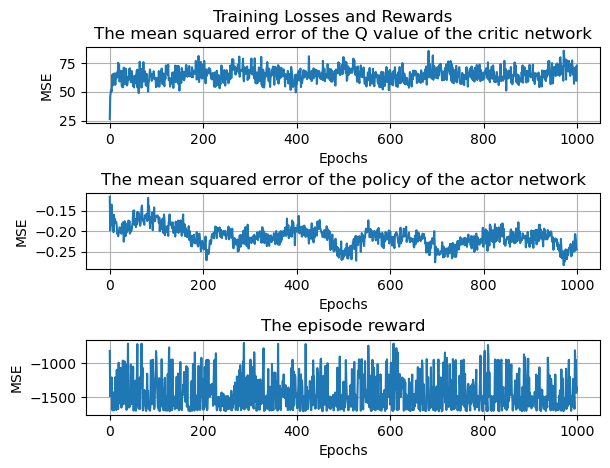

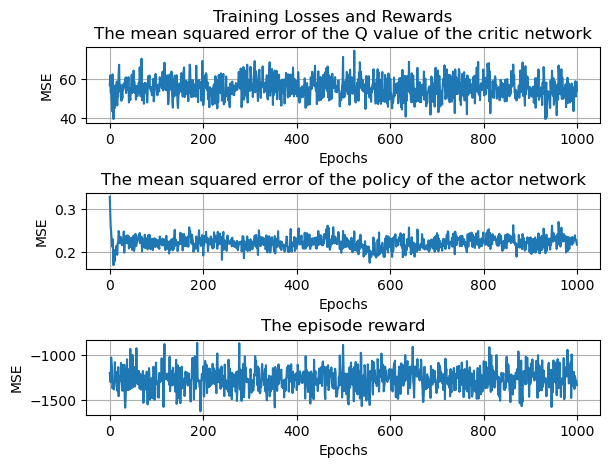

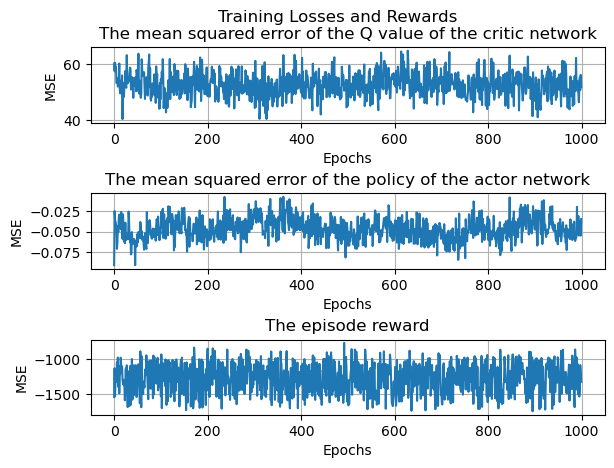

In [248]:
Tau = 0.5
Theta = [0,0.1,0.5,0.9,1]
OU_noise = OUActionNoise()

for t in Theta[0:3]:
    agent, plot_reward, plot_policy, plot_q = train_network_varying_Tau(Tau = i, noise = OU_noise, deterministic = False, theta = t)
    agents.append(agent)

    Plotting(plot_q, plot_policy, plot_reward)
    reward_vector_DDPG_agent = []
    for j in range(100):
        total_reward = run_episode(agent = agent)
        reward_vector_DDPG_agent.append(total_reward)
    cumulative_rewards.append(np.mean(reward_vector_DDPG_agent))
    print(r"The average cumulative reward obtained with ddpg with \Tau = {} agent: {}".format(i, np.mean(reward_vector_DDPG_agent)))
